#### Dependencies

In [53]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import yaml
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda
import mnist_dataset
from hydra import initialize, compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from difflogic import LogicLayer, GroupSum

#### Dataset

Tunable Variables

In [54]:
# True: Removes border of Mnist, False: Keeps black border around digits
remove_border = False
# True: Binarized Images, False: Grayscale Images 
binarize_images = True  
# True: Even distribution of samples, False: Original Mnist distribution 
evenly_partitioned = True
# True: Upscales the samples to 32x32, False: Keeps size unchanged
upscaled_images = True
# Batch size
batch_size = 256

Dataset Transform

In [55]:
# function to binarize an image, threshold is tunable 
def binarize(image, threshold=0.5):
    return (image > threshold).float()  

# define the transformation logic based on the toggle
transform_list = [ToTensor()]
if upscaled_images:
    transform_list.append(Resize((32, 32)))
if binarize_images:
    transform_list.append(Lambda(lambda x: binarize(x)))
    
transform = Compose(transform_list)

In [56]:
train_dataset = mnist_dataset.MNIST('./data-mnist', train=True, download=True, remove_border=remove_border, transform=transform)
test_dataset = mnist_dataset.MNIST('./data-mnist', train=False, remove_border=remove_border, transform=transform)

# drop_last = True means it will drop the last incomplete Batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [57]:
# makes the Dataset evenly partitioned
if evenly_partitioned:
    # code below is used so that all classes have the same number of samples
    train_targets = train_loader.dataset.targets
    test_targets = test_loader.dataset.targets

    train_digits_total = []
    test_digits_total = []

    for i in range(10):
        curr_tot_train = torch.sum(train_targets == i).item()
        curr_tot_test = torch.sum(test_targets == i).item()    
        train_digits_total.append(curr_tot_train)
        test_digits_total.append(curr_tot_test)

    train_digits_total, test_digits_total

    # find the minimum number of samples across all classes
    min_samples_train = min(train_digits_total)
    min_samples_test = min(test_digits_total)

    # function to trim dataset to match the minimum samples for each class and shuffle indices
    def trim_dataset(dataset, targets, min_samples):
        indices = []
        for i in range(10):
            class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
            class_indices = class_indices[:min_samples]  # trim to min_samples
            indices.extend(class_indices)

        # shuffle indices after collecting them
        indices = torch.tensor(indices)
        indices = indices[torch.randperm(indices.size(0))]  

        return Subset(dataset, indices)

    # trim both train and test datasets to ensure all classes have the same number of samples
    trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
    trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

    # create DataLoaders for the trimmed datasets
    trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

    # verify the lengths of the trimmed datasets
    len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

    train_dataset = trimmed_train_dataset
    test_dataset = trimmed_test_dataset
    train_loader = trimmed_train_loader
    test_loader = trimmed_test_loader

In [58]:
sample_size = len(train_loader.dataset) + len(test_loader.dataset)
len(train_loader.dataset), len(test_loader.dataset)

(54210, 8920)

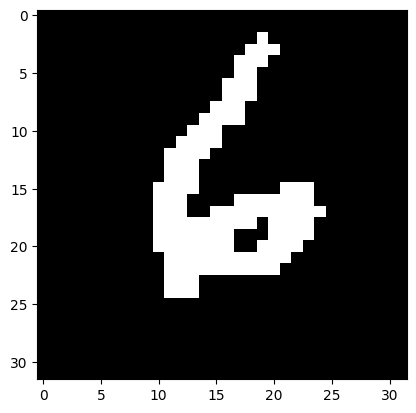

In [72]:
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)

if remove_border:
    image = train_loader.dataset[random_index][0].reshape(20, 20)
elif not remove_border and not upscaled_images:
    image = train_loader.dataset[random_index][0].reshape(28, 28)
else:
    image = train_loader.dataset[random_index][0].reshape(32, 32)
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [62]:
# define first input and the name of the file to be saved
first_in_dim = 1024 # 32x32
filename = "config/mnist_config_32x32.yaml"  

In [63]:
# reads the CSV file into a DataFrame
df = pd.read_csv("config/hyperparameters.csv")

# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_config_32x32.yaml' generated successfully.


#### Model Definition

DiffLogic Class

In [64]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        self.flatten = nn.Flatten()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        x = self.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs)

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [65]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### Model Training

In [71]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="aidays2024"):
    cfg = compose(config_name="mnist_config_32x32")

# training loop for all models
all_models_dict = {}
num_epochs = 150
file_path = 'trained_models/mnist_trained_32x32' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    try:
        # initializes DiffLogic model and moves to CUDA if available
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # optimizer and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        early_stopper = EarlyStopper(patience=5)

        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_loss = 0  # to track loss for an epoch
            
            for batch_inputs, batch_outputs in loop:
                # move data to the appropriate device
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

                # forward pass through the model
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)

                # zero gradients, backpropagates, and updates model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # accumulating the loss for the epoch
                epoch_loss += loss.item()

            # caclulating the average loss for the epoch
            epoch_loss /= len(train_loader)
            all_models_dict[model_name]['losses'].append(epoch_loss)
            print(f'Epoch {epoch+1} Loss: {epoch_loss}')

            # checks for early stopping
            if early_stopper.should_stop(epoch_loss):
                print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
                break

        # saving trained model's state
        model.save(file_path, model_name)

    except Exception as e:
        print(f"ERROR TRAINING {model_name.upper()}: {str(e)}")

print("All models processed.")

training model model_001
LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 33.66it/s]


Epoch 1 Loss: 1.3200857827657175


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 2 Loss: 1.1622535783483485


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 33.96it/s]


Epoch 3 Loss: 1.1566673044015858


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 34.03it/s]


Epoch 4 Loss: 1.1547830922069682


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 33.95it/s]


Epoch 5 Loss: 1.1535322602712659


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 33.63it/s]


Epoch 6 Loss: 1.1527173911284272


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 33.93it/s]


Epoch 7 Loss: 1.1513915136076935


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 8 Loss: 1.150921677086689


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 33.80it/s]


Epoch 9 Loss: 1.1506105780811158


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 33.97it/s]


Epoch 10 Loss: 1.1503392118093103


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 33.90it/s]


Epoch 11 Loss: 1.1502008411049482


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 12 Loss: 1.1501813274638428


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 13 Loss: 1.1499029371001466


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 33.91it/s]


Epoch 14 Loss: 1.1495938554564726


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 33.95it/s]


Epoch 15 Loss: 1.1497959557683637
EarlyStopper Triggered:  1


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 33.91it/s]


Epoch 16 Loss: 1.149231868637272


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 33.56it/s]


Epoch 17 Loss: 1.1491232266088076


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 33.90it/s]


Epoch 18 Loss: 1.1490680750482187


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 19 Loss: 1.1489809377066376


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 33.89it/s]


Epoch 20 Loss: 1.1485866613705913


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 33.85it/s]


Epoch 21 Loss: 1.1486891981042615
EarlyStopper Triggered:  1


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 33.89it/s]


Epoch 22 Loss: 1.1483127236552468


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 23 Loss: 1.1481234541292045


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 33.90it/s]


Epoch 24 Loss: 1.1476310061160344


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 33.90it/s]


Epoch 25 Loss: 1.1475114315422104


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 26 Loss: 1.1476049393077303
EarlyStopper Triggered:  1


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 33.94it/s]


Epoch 27 Loss: 1.1477021628509478
EarlyStopper Triggered:  2


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 33.55it/s]


Epoch 28 Loss: 1.1478432688088398
EarlyStopper Triggered:  3


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 33.95it/s]


Epoch 29 Loss: 1.147690427614933
EarlyStopper Triggered:  4


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 33.96it/s]


Epoch 30 Loss: 1.1475978639580708
EarlyStopper Triggered:  5
Early stopping triggered for model_001 at epoch 30.
training model model_002
LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 1 Loss: 0.8867105201777373


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 33.89it/s]


Epoch 2 Loss: 0.666291721733103


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 3 Loss: 0.6564036894804279


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 33.59it/s]


Epoch 4 Loss: 0.6528171402633683


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 33.85it/s]


Epoch 5 Loss: 0.6503674174942105


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 6 Loss: 0.6489588178818521


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 7 Loss: 0.6475417601532928


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 8 Loss: 0.6464786080786478


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 9 Loss: 0.646013158187296


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 33.81it/s]


Epoch 10 Loss: 0.6457735913032443


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 33.78it/s]


Epoch 11 Loss: 0.6454345604253656


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 33.75it/s]


Epoch 12 Loss: 0.645011757174782


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 33.85it/s]


Epoch 13 Loss: 0.64426504583869


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 33.81it/s]


Epoch 14 Loss: 0.644479503495966
EarlyStopper Triggered:  1


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 33.43it/s]


Epoch 15 Loss: 0.643854189977623


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 33.82it/s]


Epoch 16 Loss: 0.6435856216446225


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 17 Loss: 0.6434868018864293


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 33.74it/s]


Epoch 18 Loss: 0.6433690749800757


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 33.76it/s]


Epoch 19 Loss: 0.6433054125190695


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 33.47it/s]


Epoch 20 Loss: 0.6430937977842979


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 21 Loss: 0.6429191921376896


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 22 Loss: 0.6428598671202389


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 33.74it/s]


Epoch 23 Loss: 0.6427463286016403


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 24 Loss: 0.6428178799815512
EarlyStopper Triggered:  1


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 33.78it/s]


Epoch 25 Loss: 0.6424936041257614


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 33.45it/s]


Epoch 26 Loss: 0.6421642633816445


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 27 Loss: 0.6421359612100717


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 33.77it/s]


Epoch 28 Loss: 0.6419631979081134


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 33.74it/s]


Epoch 29 Loss: 0.6420774308456967
EarlyStopper Triggered:  1


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 33.77it/s]


Epoch 30 Loss: 0.6418240932799947


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 33.37it/s]


Epoch 31 Loss: 0.6422228945243289
EarlyStopper Triggered:  1


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 33.84it/s]


Epoch 32 Loss: 0.6418759030901371
EarlyStopper Triggered:  2


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 33.84it/s]


Epoch 33 Loss: 0.6415302973346344


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 33.82it/s]


Epoch 34 Loss: 0.6414775616079343


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 35 Loss: 0.6414873677955583
EarlyStopper Triggered:  1


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 36 Loss: 0.6413133240500282


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 37 Loss: 0.6414972303492416
EarlyStopper Triggered:  1


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 38 Loss: 0.6411153876011435


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 33.84it/s]


Epoch 39 Loss: 0.6411431978358285
EarlyStopper Triggered:  1


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 40 Loss: 0.6412829053061062
EarlyStopper Triggered:  2


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 41 Loss: 0.6408901278899144


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 42 Loss: 0.6412919202540333
EarlyStopper Triggered:  1


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 43 Loss: 0.640772701184366


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 44 Loss: 0.6409633136561111
EarlyStopper Triggered:  1


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 33.75it/s]


Epoch 45 Loss: 0.6407531876945187


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 33.75it/s]


Epoch 46 Loss: 0.6407073893950876


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 47 Loss: 0.640889893425215
EarlyStopper Triggered:  1


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 33.42it/s]


Epoch 48 Loss: 0.6406033689416625


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 49 Loss: 0.6408342143859909
EarlyStopper Triggered:  1


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 33.75it/s]


Epoch 50 Loss: 0.6404873808949613


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 51 Loss: 0.6406043650809085
EarlyStopper Triggered:  1


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 52 Loss: 0.640384213774912


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 53 Loss: 0.6406542728201304
EarlyStopper Triggered:  1


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 33.30it/s]


Epoch 54 Loss: 0.6403095829208395


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 55 Loss: 0.6403014557529827


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 56 Loss: 0.6401508683829875


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 57 Loss: 0.6402831579279136
EarlyStopper Triggered:  1


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 33.73it/s]


Epoch 58 Loss: 0.6402190797120765
EarlyStopper Triggered:  2


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 33.61it/s]


Epoch 59 Loss: 0.6400025844557674


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 33.86it/s]


Epoch 60 Loss: 0.6399513828862778


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 33.90it/s]


Epoch 61 Loss: 0.6399892946108555
EarlyStopper Triggered:  1


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 62 Loss: 0.6399337464403111


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 33.88it/s]


Epoch 63 Loss: 0.6398135174062717


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 64 Loss: 0.6397177159980592


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 65 Loss: 0.6399665004252496
EarlyStopper Triggered:  1


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 33.83it/s]


Epoch 66 Loss: 0.6402202477823229
EarlyStopper Triggered:  2


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 33.80it/s]


Epoch 67 Loss: 0.6396800935242475


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 33.87it/s]


Epoch 68 Loss: 0.6397794428711361
EarlyStopper Triggered:  1


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 33.81it/s]


Epoch 69 Loss: 0.6397849010725584
EarlyStopper Triggered:  2


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 33.79it/s]


Epoch 70 Loss: 0.6398178302327937
EarlyStopper Triggered:  3


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 71 Loss: 0.6398108465689305
EarlyStopper Triggered:  4


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 33.76it/s]


Epoch 72 Loss: 0.6397050066133827
EarlyStopper Triggered:  5
Early stopping triggered for model_002 at epoch 72.
training model model_003
LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 33.64it/s]


Epoch 1 Loss: 0.6948985245936506


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 33.64it/s]


Epoch 2 Loss: 0.4681947008252273


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 3 Loss: 0.45639705647740736


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 33.34it/s]


Epoch 4 Loss: 0.45102179470849946


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 33.63it/s]


Epoch 5 Loss: 0.4486168323448352


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 6 Loss: 0.4469638307488821


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 33.64it/s]


Epoch 7 Loss: 0.44590536572375633


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 8 Loss: 0.444814963698082


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 33.24it/s]


Epoch 9 Loss: 0.444350978950072


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 33.23it/s]


Epoch 10 Loss: 0.44335821177447804


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 33.63it/s]


Epoch 11 Loss: 0.44284760758895975


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 12 Loss: 0.442845950481392


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 13 Loss: 0.44253753758353953


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 33.28it/s]


Epoch 14 Loss: 0.4421859800982772


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 33.65it/s]


Epoch 15 Loss: 0.44198556272849165


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 33.66it/s]


Epoch 16 Loss: 0.4413224081689315


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 33.66it/s]


Epoch 17 Loss: 0.44135527881335035
EarlyStopper Triggered:  1


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 18 Loss: 0.4404863029210627


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 33.77it/s]


Epoch 19 Loss: 0.44039835156407403


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 20 Loss: 0.44073059956481814
EarlyStopper Triggered:  1


Epoch 21/150: 100%|██████████| 211/211 [00:12<00:00, 17.46it/s]


Epoch 21 Loss: 0.44068054372116033
EarlyStopper Triggered:  2


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 32.87it/s]


Epoch 22 Loss: 0.4401403065842936


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 23 Loss: 0.44004945204961393


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 24 Loss: 0.4401297415222346
EarlyStopper Triggered:  1


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 33.35it/s]


Epoch 25 Loss: 0.43976568715014813


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 26 Loss: 0.439739710410292


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 27 Loss: 0.43976263333260746
EarlyStopper Triggered:  1


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 28 Loss: 0.43951961399985656


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 29 Loss: 0.43915161264428876


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 33.30it/s]


Epoch 30 Loss: 0.43918009023064275
EarlyStopper Triggered:  1


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 31 Loss: 0.438949770138432


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 33.65it/s]


Epoch 32 Loss: 0.4389495206026474


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 33.65it/s]


Epoch 33 Loss: 0.43901692081474114
EarlyStopper Triggered:  1


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 34 Loss: 0.4387827600514934


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 35 Loss: 0.438502830097828


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 33.58it/s]


Epoch 36 Loss: 0.4383671662516677


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 37 Loss: 0.43855021019758295
EarlyStopper Triggered:  1


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 33.68it/s]


Epoch 38 Loss: 0.4384020646089362
EarlyStopper Triggered:  2


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 39 Loss: 0.43808024131350554


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 40 Loss: 0.4382627298263477
EarlyStopper Triggered:  1


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 33.43it/s]


Epoch 41 Loss: 0.4379766524509614


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 42 Loss: 0.4380054281741657
EarlyStopper Triggered:  1


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 43 Loss: 0.4380973428117943
EarlyStopper Triggered:  2


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 33.76it/s]


Epoch 44 Loss: 0.43814802253340907
EarlyStopper Triggered:  3


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 33.77it/s]


Epoch 45 Loss: 0.4377642672952028


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 33.33it/s]


Epoch 46 Loss: 0.437983623826512
EarlyStopper Triggered:  1


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 47 Loss: 0.43785710746270606
EarlyStopper Triggered:  2


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 33.70it/s]


Epoch 48 Loss: 0.43761590172356424


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 49 Loss: 0.43761516883336976


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 33.75it/s]


Epoch 50 Loss: 0.43720051964112444


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 33.74it/s]


Epoch 51 Loss: 0.43732005642172816
EarlyStopper Triggered:  1


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 52 Loss: 0.4376061264956618
EarlyStopper Triggered:  2


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 33.72it/s]


Epoch 53 Loss: 0.43732080225137004
EarlyStopper Triggered:  3


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 54 Loss: 0.43753702260183513
EarlyStopper Triggered:  4


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 33.71it/s]


Epoch 55 Loss: 0.4374452532273058
EarlyStopper Triggered:  5
Early stopping triggered for model_003 at epoch 55.
training model model_004
LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 1 Loss: 0.6038539871938234


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 33.19it/s]


Epoch 2 Loss: 0.37081055903759086


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 33.60it/s]


Epoch 3 Loss: 0.35562395573996014


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 33.60it/s]


Epoch 4 Loss: 0.3490232555477699


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 33.58it/s]


Epoch 5 Loss: 0.34541323669531343


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 33.55it/s]


Epoch 6 Loss: 0.34341289419672494


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 33.57it/s]


Epoch 7 Loss: 0.3416763847461945


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 8 Loss: 0.34019154604439644


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 33.41it/s]


Epoch 9 Loss: 0.33939890383106996


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 33.62it/s]


Epoch 10 Loss: 0.33879633963099515


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 33.66it/s]


Epoch 11 Loss: 0.33809860275834847


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 12 Loss: 0.3373578989012563


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 13 Loss: 0.33704855173576326


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 33.37it/s]


Epoch 14 Loss: 0.33697968154054914


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 33.63it/s]


Epoch 15 Loss: 0.3364796632618711


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 33.61it/s]


Epoch 16 Loss: 0.33641680207316016


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 33.67it/s]


Epoch 17 Loss: 0.33605410061662905


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 33.62it/s]


Epoch 18 Loss: 0.3356376898640563


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 32.95it/s]


Epoch 19 Loss: 0.33549823512699967


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 33.59it/s]


Epoch 20 Loss: 0.33519787543392576


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 33.59it/s]


Epoch 21 Loss: 0.33497720556917693


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 33.59it/s]


Epoch 22 Loss: 0.33497620534010913


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 33.63it/s]


Epoch 23 Loss: 0.3343002909994915


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 33.59it/s]


Epoch 24 Loss: 0.3346282784321135
EarlyStopper Triggered:  1


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 33.23it/s]


Epoch 25 Loss: 0.3343886732894803
EarlyStopper Triggered:  2


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 33.62it/s]


Epoch 26 Loss: 0.3344415957548748
EarlyStopper Triggered:  3


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 33.69it/s]


Epoch 27 Loss: 0.3345327031716842
EarlyStopper Triggered:  4


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 33.65it/s]


Epoch 28 Loss: 0.3343373685866321
EarlyStopper Triggered:  5
Early stopping triggered for model_004 at epoch 28.
training model model_005
LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 33.54it/s]


Epoch 1 Loss: 0.5520963783916519


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 33.10it/s]


Epoch 2 Loss: 0.31751049239832896


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 3 Loss: 0.2994053061095382


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 33.41it/s]


Epoch 4 Loss: 0.29142258451680075


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 5 Loss: 0.28744064249887585


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 6 Loss: 0.28473289893639186


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 33.55it/s]


Epoch 7 Loss: 0.2829897889745562


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 33.01it/s]


Epoch 8 Loss: 0.28136449260212515


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 9 Loss: 0.27983355026768536


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 33.54it/s]


Epoch 10 Loss: 0.2792098654826366


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 33.50it/s]


Epoch 11 Loss: 0.2784899211392539


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 12 Loss: 0.277870105961497


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 33.15it/s]


Epoch 13 Loss: 0.27696357141103956


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 14 Loss: 0.27650849409026407


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 15 Loss: 0.27630583229515165


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 33.45it/s]


Epoch 16 Loss: 0.27605064162379367


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 17 Loss: 0.2754276847324125


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 18 Loss: 0.2749307015720723


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 33.19it/s]


Epoch 19 Loss: 0.2748728430271221


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 33.56it/s]


Epoch 20 Loss: 0.27472273704864597


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 33.57it/s]


Epoch 21 Loss: 0.27491542021309173
EarlyStopper Triggered:  1


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 22 Loss: 0.27446421974680013


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 23 Loss: 0.27440749369470485


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 33.13it/s]


Epoch 24 Loss: 0.27399897956503694


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 33.43it/s]


Epoch 25 Loss: 0.274017477480168
EarlyStopper Triggered:  1


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 33.45it/s]


Epoch 26 Loss: 0.2737245932751965


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 33.46it/s]


Epoch 27 Loss: 0.2735713275235245


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 28 Loss: 0.27364828882190173
EarlyStopper Triggered:  1


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 33.08it/s]


Epoch 29 Loss: 0.27346532840802856


Epoch 30/150: 100%|██████████| 211/211 [00:09<00:00, 23.04it/s]


Epoch 30 Loss: 0.27310208392337726


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 32.61it/s]


Epoch 31 Loss: 0.27327062872946817
EarlyStopper Triggered:  1


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 33.45it/s]


Epoch 32 Loss: 0.27343058820499705
EarlyStopper Triggered:  2


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 33.43it/s]


Epoch 33 Loss: 0.2732801901041412
EarlyStopper Triggered:  3


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 33.06it/s]


Epoch 34 Loss: 0.2729171865354978


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 33.47it/s]


Epoch 35 Loss: 0.27282684724650047


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 33.47it/s]


Epoch 36 Loss: 0.2726507293125145


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 37 Loss: 0.2727047169006947
EarlyStopper Triggered:  1


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 38 Loss: 0.27292692672489816
EarlyStopper Triggered:  2


Epoch 39/150: 100%|██████████| 211/211 [00:09<00:00, 21.12it/s]


Epoch 39 Loss: 0.27268040024274537
EarlyStopper Triggered:  3


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 40 Loss: 0.2723188342002682


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 41 Loss: 0.2724976025450903
EarlyStopper Triggered:  1


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 42 Loss: 0.2724569758616944
EarlyStopper Triggered:  2


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 33.50it/s]


Epoch 43 Loss: 0.27228484158730015


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 33.46it/s]


Epoch 44 Loss: 0.27193393311241826


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 45 Loss: 0.2721510851361497
EarlyStopper Triggered:  1


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 33.09it/s]


Epoch 46 Loss: 0.2723211724615999
EarlyStopper Triggered:  2


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 47 Loss: 0.2720208508070266
EarlyStopper Triggered:  3


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 48 Loss: 0.27181665419559103


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 33.56it/s]


Epoch 49 Loss: 0.27207855682814186
EarlyStopper Triggered:  1


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 33.58it/s]


Epoch 50 Loss: 0.2719101391607276
EarlyStopper Triggered:  2


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 33.57it/s]


Epoch 51 Loss: 0.27197231982562614
EarlyStopper Triggered:  3


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 33.05it/s]


Epoch 52 Loss: 0.2718515185367159
EarlyStopper Triggered:  4


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 53 Loss: 0.2717796571102041


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 33.54it/s]


Epoch 54 Loss: 0.27151786848434845


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 55 Loss: 0.2718375143946877
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 33.51it/s]


Epoch 56 Loss: 0.2717226038546806
EarlyStopper Triggered:  2


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 57 Loss: 0.2716855927585817
EarlyStopper Triggered:  3


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 33.25it/s]


Epoch 58 Loss: 0.27151036928417477


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 33.50it/s]


Epoch 59 Loss: 0.27118998815093215


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 60 Loss: 0.27138299473288224
EarlyStopper Triggered:  1


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 33.47it/s]


Epoch 61 Loss: 0.27147536840995234
EarlyStopper Triggered:  2


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 33.46it/s]


Epoch 62 Loss: 0.2715350458758701
EarlyStopper Triggered:  3


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 32.99it/s]


Epoch 63 Loss: 0.2711711805843099


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 33.44it/s]


Epoch 64 Loss: 0.271281238822088
EarlyStopper Triggered:  1


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 33.43it/s]


Epoch 65 Loss: 0.2711420533516985


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 66 Loss: 0.2713725078687311
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 67 Loss: 0.27093503321530754


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 33.38it/s]


Epoch 68 Loss: 0.2709245616303883


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 33.16it/s]


Epoch 69 Loss: 0.27127470731074266
EarlyStopper Triggered:  1


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 70 Loss: 0.2711391884893595
EarlyStopper Triggered:  2


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 33.48it/s]


Epoch 71 Loss: 0.27110095009501156
EarlyStopper Triggered:  3


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 33.47it/s]


Epoch 72 Loss: 0.27072677725338673


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 33.49it/s]


Epoch 73 Loss: 0.2711904055560717
EarlyStopper Triggered:  1


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 33.26it/s]


Epoch 74 Loss: 0.270890290957042
EarlyStopper Triggered:  2


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 75 Loss: 0.27073432073718395
EarlyStopper Triggered:  3


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 33.52it/s]


Epoch 76 Loss: 0.27092265864538134
EarlyStopper Triggered:  4


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 33.53it/s]


Epoch 77 Loss: 0.27076887754976237
EarlyStopper Triggered:  5
Early stopping triggered for model_005 at epoch 77.
training model model_006
LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 32.87it/s]


Epoch 1 Loss: 1.0992842483276792


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 32.33it/s]


Epoch 2 Loss: 0.7986009933317474


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 32.85it/s]


Epoch 3 Loss: 0.7839685279411147


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 32.84it/s]


Epoch 4 Loss: 0.7764814977218506


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 32.86it/s]


Epoch 5 Loss: 0.772072116293396


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 6 Loss: 0.7687754605489918


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 32.40it/s]


Epoch 7 Loss: 0.7670653819475624


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 32.75it/s]


Epoch 8 Loss: 0.7646719189823382


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 32.77it/s]


Epoch 9 Loss: 0.7635771727001277


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 32.77it/s]


Epoch 10 Loss: 0.7627663114861359


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 11 Loss: 0.7610574385870504


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 32.77it/s]


Epoch 12 Loss: 0.760343894066639


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 32.41it/s]


Epoch 13 Loss: 0.7598947587050325


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 32.76it/s]


Epoch 14 Loss: 0.7590559609973213


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 32.76it/s]


Epoch 15 Loss: 0.7584237521549855


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 16 Loss: 0.7577881406442372


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 17 Loss: 0.7572727413018883


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 32.41it/s]


Epoch 18 Loss: 0.7566233688218924


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 19 Loss: 0.7561328123780404


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 32.76it/s]


Epoch 20 Loss: 0.7558080354738324


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 21 Loss: 0.7554366399300745


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 32.76it/s]


Epoch 22 Loss: 0.7543468557706866


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 32.39it/s]


Epoch 23 Loss: 0.7541516586668574


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 32.73it/s]


Epoch 24 Loss: 0.7539827068800334


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 32.78it/s]


Epoch 25 Loss: 0.7532105573385187


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 26 Loss: 0.7531861934183606


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 32.81it/s]


Epoch 27 Loss: 0.7528048152421978


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 28 Loss: 0.7526867511975674


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 32.41it/s]


Epoch 29 Loss: 0.7523045807348252


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 32.75it/s]


Epoch 30 Loss: 0.752114728600923


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 32.76it/s]


Epoch 31 Loss: 0.7521172654754665
EarlyStopper Triggered:  1


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 32 Loss: 0.751910007838393


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 32.74it/s]


Epoch 33 Loss: 0.751836401706198


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 32.37it/s]


Epoch 34 Loss: 0.7514281296391565


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 32.84it/s]


Epoch 35 Loss: 0.7515379537905951
EarlyStopper Triggered:  1


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 32.89it/s]


Epoch 36 Loss: 0.7513068698620634


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 32.89it/s]


Epoch 37 Loss: 0.7512327071224206


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 32.88it/s]


Epoch 38 Loss: 0.7508737454831489


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 32.84it/s]


Epoch 39 Loss: 0.7508139606156727


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 40 Loss: 0.7502404973946796


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 32.83it/s]


Epoch 41 Loss: 0.7502155218875666


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 42 Loss: 0.7502188114255562
EarlyStopper Triggered:  1


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 43 Loss: 0.7499140755980053


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 44 Loss: 0.7497148878960738


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 32.50it/s]


Epoch 45 Loss: 0.749767967495588
EarlyStopper Triggered:  1


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 32.82it/s]


Epoch 46 Loss: 0.7497200673933919
EarlyStopper Triggered:  2


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 47 Loss: 0.7494963695770315


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 48 Loss: 0.7490170296617077


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 32.79it/s]


Epoch 49 Loss: 0.7491924730218625
EarlyStopper Triggered:  1


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 50 Loss: 0.7489562043777614


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 32.81it/s]


Epoch 51 Loss: 0.7488675202269495


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 32.72it/s]


Epoch 52 Loss: 0.7488174548639656


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 32.70it/s]


Epoch 53 Loss: 0.7486104237814466


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 32.85it/s]


Epoch 54 Loss: 0.7482390968994389


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 32.42it/s]


Epoch 55 Loss: 0.7480734254640445


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 32.78it/s]


Epoch 56 Loss: 0.748058320715864


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 57 Loss: 0.7480363819522451


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 58 Loss: 0.7479187994683034


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 32.81it/s]


Epoch 59 Loss: 0.7474025738826028


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 32.42it/s]


Epoch 60 Loss: 0.747420620458988
EarlyStopper Triggered:  1


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 32.61it/s]


Epoch 61 Loss: 0.7474004159616744


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 32.77it/s]


Epoch 62 Loss: 0.7472875163058476


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 63 Loss: 0.746819187529614


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 32.78it/s]


Epoch 64 Loss: 0.7466406038889243


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 32.78it/s]


Epoch 65 Loss: 0.7466241907150309


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 32.50it/s]


Epoch 66 Loss: 0.7467032387267415
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 32.80it/s]


Epoch 67 Loss: 0.7463609045580526


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 32.83it/s]


Epoch 68 Loss: 0.7463489488321602


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 32.81it/s]


Epoch 69 Loss: 0.7464585834089931
EarlyStopper Triggered:  1


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 32.85it/s]


Epoch 70 Loss: 0.7461792346653094


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 71 Loss: 0.7458935518400004


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 32.85it/s]


Epoch 72 Loss: 0.7464035265365748
EarlyStopper Triggered:  1


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 32.81it/s]


Epoch 73 Loss: 0.7461335656795843
EarlyStopper Triggered:  2


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 32.82it/s]


Epoch 74 Loss: 0.7459517253383152
EarlyStopper Triggered:  3


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 32.82it/s]


Epoch 75 Loss: 0.7459504171021225
EarlyStopper Triggered:  4


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 32.50it/s]


Epoch 76 Loss: 0.7456282747635341


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 32.88it/s]


Epoch 77 Loss: 0.7458663632437613
EarlyStopper Triggered:  1


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 32.90it/s]


Epoch 78 Loss: 0.7457715521000547
EarlyStopper Triggered:  2


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 32.90it/s]


Epoch 79 Loss: 0.7454209278499562


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 32.91it/s]


Epoch 80 Loss: 0.7453437792139294


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 32.93it/s]


Epoch 81 Loss: 0.7455917789611298
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 32.57it/s]


Epoch 82 Loss: 0.7457100645723131
EarlyStopper Triggered:  2


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 32.88it/s]


Epoch 83 Loss: 0.7456932954203488
EarlyStopper Triggered:  3


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 32.92it/s]


Epoch 84 Loss: 0.7453614023359719
EarlyStopper Triggered:  4


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 32.88it/s]


Epoch 85 Loss: 0.7453516950725152
EarlyStopper Triggered:  5
Early stopping triggered for model_006 at epoch 85.
training model model_007
LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 1 Loss: 0.7538383956243213


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 2 Loss: 0.4117478884513109


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 3 Loss: 0.39504258156461675


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 4 Loss: 0.3859960691990947


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 5 Loss: 0.38100875828691927


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 32.60it/s]


Epoch 6 Loss: 0.37755084023390606


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 32.62it/s]


Epoch 7 Loss: 0.37460543615500297


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 32.32it/s]


Epoch 8 Loss: 0.3726928440095284


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 32.60it/s]


Epoch 9 Loss: 0.3715294121468103


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 32.63it/s]


Epoch 10 Loss: 0.3703401757781577


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 32.59it/s]


Epoch 11 Loss: 0.3694143158942266


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 32.58it/s]


Epoch 12 Loss: 0.36825554924137305


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 32.57it/s]


Epoch 13 Loss: 0.3673969864835004


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 32.16it/s]


Epoch 14 Loss: 0.3664578176525888


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 15 Loss: 0.3655702007956372


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 32.54it/s]


Epoch 16 Loss: 0.3648835827694653


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 17 Loss: 0.36433491973570786


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 32.53it/s]


Epoch 18 Loss: 0.36353719649737465


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 32.17it/s]


Epoch 19 Loss: 0.36297899515442655


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 20 Loss: 0.36264843568679533


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 32.54it/s]


Epoch 21 Loss: 0.3619791542582693


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 32.53it/s]


Epoch 22 Loss: 0.3613074567825016


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 32.48it/s]


Epoch 23 Loss: 0.3612619605711359


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 32.48it/s]


Epoch 24 Loss: 0.36064374197997173


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 32.32it/s]


Epoch 25 Loss: 0.36014832909811656


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 32.54it/s]


Epoch 26 Loss: 0.3597191844475901


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 27 Loss: 0.3593917563278411


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 32.49it/s]


Epoch 28 Loss: 0.3592201177022777


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 29 Loss: 0.35909233974432075


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 32.20it/s]


Epoch 30 Loss: 0.3587637078596173


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 31 Loss: 0.3587122509923811


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 32 Loss: 0.35829848199096115


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 33 Loss: 0.35786748618649533


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 32.57it/s]


Epoch 34 Loss: 0.3577266347974327


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 32.20it/s]


Epoch 35 Loss: 0.35751988834964277


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 36 Loss: 0.35716303158591106


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 37 Loss: 0.3568044851500158


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 38 Loss: 0.3563744572155884


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 39 Loss: 0.3565663565112139
EarlyStopper Triggered:  1


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 40 Loss: 0.3561400617214151


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 32.20it/s]


Epoch 41 Loss: 0.3559307456692475


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 32.47it/s]


Epoch 42 Loss: 0.3559975590198981
EarlyStopper Triggered:  1


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 32.60it/s]


Epoch 43 Loss: 0.35560424603567015


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 32.57it/s]


Epoch 44 Loss: 0.3555176703452023


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 32.59it/s]


Epoch 45 Loss: 0.35530357342794894


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 32.22it/s]


Epoch 46 Loss: 0.3551328462935012


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 47 Loss: 0.35505978154405987


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 32.49it/s]


Epoch 48 Loss: 0.3549922276737373


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 49 Loss: 0.3548904861210344


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 32.47it/s]


Epoch 50 Loss: 0.3549488212081264
EarlyStopper Triggered:  1


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 32.23it/s]


Epoch 51 Loss: 0.3545069480314829


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 52 Loss: 0.3544591455836494


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 32.51it/s]


Epoch 53 Loss: 0.354182457840568


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 54 Loss: 0.3540791085910111


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 32.52it/s]


Epoch 55 Loss: 0.35422345411674633
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 32.06it/s]


Epoch 56 Loss: 0.3537361186252797


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 32.56it/s]


Epoch 57 Loss: 0.353758184728919
EarlyStopper Triggered:  1


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 32.60it/s]


Epoch 58 Loss: 0.35350273141417005


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 59 Loss: 0.3533560668838705


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 60 Loss: 0.35362994367163963
EarlyStopper Triggered:  1


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 61 Loss: 0.35293340402978157


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 32.50it/s]


Epoch 62 Loss: 0.35254977395021064


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 32.54it/s]


Epoch 63 Loss: 0.3528530789612665
EarlyStopper Triggered:  1


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 32.55it/s]


Epoch 64 Loss: 0.35299116778880363
EarlyStopper Triggered:  2


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 32.58it/s]


Epoch 65 Loss: 0.3527832637264778
EarlyStopper Triggered:  3


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 32.53it/s]


Epoch 66 Loss: 0.3528269754022303
EarlyStopper Triggered:  4


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 32.16it/s]


Epoch 67 Loss: 0.35289933799624107
EarlyStopper Triggered:  5
Early stopping triggered for model_007 at epoch 67.
training model model_008
LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 32.31it/s]


Epoch 1 Loss: 0.6504617265307354


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 2 Loss: 0.2967323038077885


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 32.40it/s]


Epoch 3 Loss: 0.27585332613904046


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 32.42it/s]


Epoch 4 Loss: 0.2661700538020083


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 5 Loss: 0.26111168810424185


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 32.31it/s]


Epoch 6 Loss: 0.25748271854850824


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 32.32it/s]


Epoch 7 Loss: 0.25460924239594507


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 8 Loss: 0.25306163336398435


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 9 Loss: 0.25142088495020076


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


Epoch 10 Loss: 0.24995422269362988


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 32.29it/s]


Epoch 11 Loss: 0.2485900839461007


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 12 Loss: 0.24719195362745977


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 32.35it/s]


Epoch 13 Loss: 0.24644724896397147


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 32.37it/s]


Epoch 14 Loss: 0.24538293666524674


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 32.12it/s]


Epoch 15 Loss: 0.24461040729069466


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 32.39it/s]


Epoch 16 Loss: 0.2441878340694568


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 17 Loss: 0.2432706461080218


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 18 Loss: 0.24284615953004354


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 32.19it/s]


Epoch 19 Loss: 0.24223293897235115


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 20 Loss: 0.2417964966876189


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


Epoch 21 Loss: 0.24134194633333467


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 22 Loss: 0.24092445478211943


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 23 Loss: 0.24046146430582016


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 32.29it/s]


Epoch 24 Loss: 0.23993794456288225


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


Epoch 25 Loss: 0.23979703424313414


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


Epoch 26 Loss: 0.2393610225586623


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


Epoch 27 Loss: 0.23893324841801966


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 32.30it/s]


Epoch 28 Loss: 0.23885866481072102


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 32.18it/s]


Epoch 29 Loss: 0.23822358926365564


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 30 Loss: 0.23790420417380576


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 31.95it/s]


Epoch 31 Loss: 0.23782433239816772


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 32 Loss: 0.23758752899153465


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 33 Loss: 0.23736573539169908


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 34 Loss: 0.2372021163526201


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 35 Loss: 0.23681416083585335


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 36 Loss: 0.23662196645682274


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 37 Loss: 0.23656469778904934


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 32.23it/s]


Epoch 38 Loss: 0.23626984307478205


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 32.21it/s]


Epoch 39 Loss: 0.23619243447765095


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 32.22it/s]


Epoch 40 Loss: 0.23570486518996417


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 32.22it/s]


Epoch 41 Loss: 0.23565453139712467


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 31.86it/s]


Epoch 42 Loss: 0.23539986114902406


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 32.20it/s]


Epoch 43 Loss: 0.23510454954410884


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 44 Loss: 0.2352390404016883
EarlyStopper Triggered:  1


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 45 Loss: 0.2348823564793138


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 32.21it/s]


Epoch 46 Loss: 0.234831315411782


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 47 Loss: 0.2346277242306486


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 48 Loss: 0.23458578647809863


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 49 Loss: 0.23387950297453652


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 32.33it/s]


Epoch 50 Loss: 0.23395492753384242
EarlyStopper Triggered:  1


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 51 Loss: 0.23399810242793911
EarlyStopper Triggered:  2


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 32.39it/s]


Epoch 52 Loss: 0.23408456954469412
EarlyStopper Triggered:  3


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 32.03it/s]


Epoch 53 Loss: 0.23381807361001225


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 32.37it/s]


Epoch 54 Loss: 0.2334674089586279


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 32.31it/s]


Epoch 55 Loss: 0.23353683883255466
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 32.29it/s]


Epoch 56 Loss: 0.23328302912343649


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 57 Loss: 0.23345466459044273
EarlyStopper Triggered:  1


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 31.88it/s]


Epoch 58 Loss: 0.23298784906623862


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 59 Loss: 0.23308334081118295
EarlyStopper Triggered:  1


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 32.29it/s]


Epoch 60 Loss: 0.23298923607300617
EarlyStopper Triggered:  2


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 61 Loss: 0.23286668313545836


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 62 Loss: 0.23284378571779193


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 32.11it/s]


Epoch 63 Loss: 0.23243883358239892


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 64 Loss: 0.23228225398196145


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 65 Loss: 0.23236812259107992
EarlyStopper Triggered:  1


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 32.35it/s]


Epoch 66 Loss: 0.23213224603621085


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 32.34it/s]


Epoch 67 Loss: 0.23228818045496524
EarlyStopper Triggered:  1


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 68 Loss: 0.23225662610578512
EarlyStopper Triggered:  2


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 31.93it/s]


Epoch 69 Loss: 0.23207636994734296


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 70 Loss: 0.23204157154873997


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 32.31it/s]


Epoch 71 Loss: 0.23206971168609714
EarlyStopper Triggered:  1


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 32.33it/s]


Epoch 72 Loss: 0.23206965674670613
EarlyStopper Triggered:  2


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 73 Loss: 0.2319255180691356


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 74 Loss: 0.23183030410900596


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 32.19it/s]


Epoch 75 Loss: 0.23183179399518905
EarlyStopper Triggered:  1


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


Epoch 76 Loss: 0.23174888021512188


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 77 Loss: 0.23141165127496846


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 78 Loss: 0.2317060521170981
EarlyStopper Triggered:  1


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 79 Loss: 0.23142224508979622
EarlyStopper Triggered:  2


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 80 Loss: 0.23120757215845975


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 81 Loss: 0.23131350440715845
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 82 Loss: 0.23153718632931505
EarlyStopper Triggered:  2


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 83 Loss: 0.23136790483022707
EarlyStopper Triggered:  3


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 31.90it/s]


Epoch 84 Loss: 0.231216031476452
EarlyStopper Triggered:  4


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 85 Loss: 0.23114272918562095


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 32.23it/s]


Epoch 86 Loss: 0.23117352239308558
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 87 Loss: 0.23112350851595032


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 88 Loss: 0.23094719837490466


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 89 Loss: 0.2312967672881386
EarlyStopper Triggered:  1


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 32.30it/s]


Epoch 90 Loss: 0.2310277810828124
EarlyStopper Triggered:  2


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 32.36it/s]


Epoch 91 Loss: 0.2309026612009752


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 32.38it/s]


Epoch 92 Loss: 0.23086248764951964


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 32.34it/s]


Epoch 93 Loss: 0.2308711615297432
EarlyStopper Triggered:  1


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 32.37it/s]


Epoch 94 Loss: 0.2308510155882709


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 95 Loss: 0.23086420183290138
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 32.27it/s]


Epoch 96 Loss: 0.23062751337577087


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 32.23it/s]


Epoch 97 Loss: 0.2309825859690553
EarlyStopper Triggered:  1


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 32.20it/s]


Epoch 98 Loss: 0.2308437474687238
EarlyStopper Triggered:  2


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 32.24it/s]


Epoch 99 Loss: 0.23063166740589436
EarlyStopper Triggered:  3


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 31.92it/s]


Epoch 100 Loss: 0.2305277449383201


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 32.21it/s]


Epoch 101 Loss: 0.23060116682915163
EarlyStopper Triggered:  1


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 32.25it/s]


Epoch 102 Loss: 0.2305080013800763


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 32.22it/s]


Epoch 103 Loss: 0.23020613173284174


Epoch 104/150: 100%|██████████| 211/211 [00:06<00:00, 32.26it/s]


Epoch 104 Loss: 0.23034543509078526
EarlyStopper Triggered:  1


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 32.33it/s]


Epoch 105 Loss: 0.2303126622977186
EarlyStopper Triggered:  2


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 106 Loss: 0.23034871209503494
EarlyStopper Triggered:  3


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 32.19it/s]


Epoch 107 Loss: 0.23029317862254325
EarlyStopper Triggered:  4


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 32.28it/s]


Epoch 108 Loss: 0.23030998375573156
EarlyStopper Triggered:  5
Early stopping triggered for model_008 at epoch 108.
training model model_009
LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 1 Loss: 0.602040260683248


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 2 Loss: 0.23976607377031184


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 3 Loss: 0.2151180538542311


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


Epoch 4 Loss: 0.20523473743400972


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 31.90it/s]


Epoch 5 Loss: 0.19894929391371524


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 6 Loss: 0.19481070465037517


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 7 Loss: 0.19224024049914268


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


Epoch 8 Loss: 0.1898676254473159


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 9 Loss: 0.18800717934284453


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 10 Loss: 0.1864957658228684


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 11 Loss: 0.18501716679205008


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 31.93it/s]


Epoch 12 Loss: 0.18393329331927308


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 31.92it/s]


Epoch 13 Loss: 0.18282601387118685


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 14 Loss: 0.18211653101904374


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 32.02it/s]


Epoch 15 Loss: 0.18142453280131146


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


Epoch 16 Loss: 0.18063822698087725


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 17 Loss: 0.17993694904072852


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 18 Loss: 0.1797262987939299


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 31.67it/s]


Epoch 19 Loss: 0.17907356958436405


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 31.93it/s]


Epoch 20 Loss: 0.17873521651645974


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 21 Loss: 0.1780032331575388


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 31.93it/s]


Epoch 22 Loss: 0.17728530975594306


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 31.95it/s]


Epoch 23 Loss: 0.17729410442096133
EarlyStopper Triggered:  1


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 31.92it/s]


Epoch 24 Loss: 0.17703345442472668


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 31.54it/s]


Epoch 25 Loss: 0.17658164632639475


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 31.95it/s]


Epoch 26 Loss: 0.17646831850297295


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 27 Loss: 0.17571549509892578


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 28 Loss: 0.17558432262107163


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 29 Loss: 0.1751116639736228


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 31.57it/s]


Epoch 30 Loss: 0.17502761108990372


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 31 Loss: 0.17439744185359374


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 31.51it/s]


Epoch 32 Loss: 0.17439782491302322
EarlyStopper Triggered:  1


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 33 Loss: 0.17400684435746516


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 32.02it/s]


Epoch 34 Loss: 0.17404656350446504
EarlyStopper Triggered:  1


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 31.67it/s]


Epoch 35 Loss: 0.17360141232841453


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 36 Loss: 0.17350247008703965


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 37 Loss: 0.17314028985293595


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 38 Loss: 0.17304883643619803


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 39 Loss: 0.17300806757151674


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 40 Loss: 0.17282662938545681


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 41 Loss: 0.17265571859694967


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 31.91it/s]


Epoch 42 Loss: 0.1720892349353356


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 32.02it/s]


Epoch 43 Loss: 0.1718791525651044


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 44 Loss: 0.17174640770435776


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 45 Loss: 0.17157177069876606


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 46 Loss: 0.17129541863246608


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 47 Loss: 0.17119833587625927


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 48 Loss: 0.1710680012396664


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 32.04it/s]


Epoch 49 Loss: 0.17108989921154577
EarlyStopper Triggered:  1


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 31.60it/s]


Epoch 50 Loss: 0.17087133558182283


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 51 Loss: 0.17079608008407388


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 31.86it/s]


Epoch 52 Loss: 0.170690301369544


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 53 Loss: 0.17036590145820318


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 54 Loss: 0.17024577825516532


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 55 Loss: 0.16998990610924886


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 31.64it/s]


Epoch 56 Loss: 0.17008785801951598
EarlyStopper Triggered:  1


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 32.03it/s]


Epoch 57 Loss: 0.16998143108813224


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 58 Loss: 0.16991255622527124


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 59 Loss: 0.16982238344855202


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 60 Loss: 0.16959177472622253


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 31.54it/s]


Epoch 61 Loss: 0.16948648201409813


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 62 Loss: 0.16955709597688126
EarlyStopper Triggered:  1


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 32.03it/s]


Epoch 63 Loss: 0.1692948808069934


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 32.02it/s]


Epoch 64 Loss: 0.16924284445290375


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 32.03it/s]


Epoch 65 Loss: 0.1690492566132057


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 66 Loss: 0.16918322080585207
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 67 Loss: 0.16903771311687765


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 68 Loss: 0.16905269684425817
EarlyStopper Triggered:  1


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 31.90it/s]


Epoch 69 Loss: 0.16883299607478164


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 32.05it/s]


Epoch 70 Loss: 0.16848740660453804


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 71 Loss: 0.16874317616101994
EarlyStopper Triggered:  1


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 72 Loss: 0.16875392912113588
EarlyStopper Triggered:  2


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 73 Loss: 0.16861352594849388
EarlyStopper Triggered:  3


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 74 Loss: 0.16831922538825272


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 75 Loss: 0.16848078895772492
EarlyStopper Triggered:  1


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 31.64it/s]


Epoch 76 Loss: 0.16814789696251406


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 31.93it/s]


Epoch 77 Loss: 0.16825376449218749
EarlyStopper Triggered:  1


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 78 Loss: 0.16791055074983685


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 79 Loss: 0.1679198462554134
EarlyStopper Triggered:  1


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 80 Loss: 0.167915543286622
EarlyStopper Triggered:  2


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 31.62it/s]


Epoch 81 Loss: 0.16804506097828203
EarlyStopper Triggered:  3


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 31.94it/s]


Epoch 82 Loss: 0.16778783442563028


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 31.98it/s]


Epoch 83 Loss: 0.16772643020894198


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 31.99it/s]


Epoch 84 Loss: 0.16773916474196063
EarlyStopper Triggered:  1


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 85 Loss: 0.16751091703300716


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 31.95it/s]


Epoch 86 Loss: 0.16750162072125738


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 31.45it/s]


Epoch 87 Loss: 0.1674707403452986


Epoch 88/150: 100%|██████████| 211/211 [00:13<00:00, 15.42it/s]


Epoch 88 Loss: 0.16727144321791995


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 31.06it/s]


Epoch 89 Loss: 0.16736541851483178
EarlyStopper Triggered:  1


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 32.01it/s]


Epoch 90 Loss: 0.16732310947919585
EarlyStopper Triggered:  2


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 31.66it/s]


Epoch 91 Loss: 0.16723328807076746


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 32.05it/s]


Epoch 92 Loss: 0.16720862800109712


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 31.97it/s]


Epoch 93 Loss: 0.16697909809180023


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 32.00it/s]


Epoch 94 Loss: 0.16717061837211097
EarlyStopper Triggered:  1


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 32.04it/s]


Epoch 95 Loss: 0.1669647980489745


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


Epoch 96 Loss: 0.16683766304758885


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 32.02it/s]


Epoch 97 Loss: 0.1668372256443695


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 32.04it/s]


Epoch 98 Loss: 0.1669064140784378
EarlyStopper Triggered:  1


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 32.07it/s]


Epoch 99 Loss: 0.1668893023374911
EarlyStopper Triggered:  2


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 32.07it/s]


Epoch 100 Loss: 0.1668626373971261
EarlyStopper Triggered:  3


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 31.96it/s]


Epoch 101 Loss: 0.16688072275109997
EarlyStopper Triggered:  4


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 31.60it/s]


Epoch 102 Loss: 0.1669074370271611
EarlyStopper Triggered:  5
Early stopping triggered for model_009 at epoch 102.
training model model_010
LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 31.62it/s]


Epoch 1 Loss: 0.5805616472567157


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 31.56it/s]


Epoch 2 Loss: 0.2084849965716436


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 3 Loss: 0.17983357714180628


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 4 Loss: 0.16748293756629173


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 31.47it/s]


Epoch 5 Loss: 0.1607219676852242


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 6 Loss: 0.15641645374106825


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 7 Loss: 0.15334795903664938


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 8 Loss: 0.15075968252825733


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 9 Loss: 0.14896857634677402


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 10 Loss: 0.14733655518995198


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 11 Loss: 0.1458925490640088


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 12 Loss: 0.1447820178989077


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 13 Loss: 0.14376200183422186


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 14 Loss: 0.1429735679311807


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 31.23it/s]


Epoch 15 Loss: 0.14195652669190775


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 16 Loss: 0.14115892612207392


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 31.73it/s]


Epoch 17 Loss: 0.14071432702071193


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 31.71it/s]


Epoch 18 Loss: 0.140058266472023


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 19 Loss: 0.13946151592621003


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 31.65it/s]


Epoch 20 Loss: 0.1389727634014228


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 31.23it/s]


Epoch 21 Loss: 0.13859849610017294


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 22 Loss: 0.13842017297782036


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 23 Loss: 0.13794352088046702


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 24 Loss: 0.13762545919278965


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 25 Loss: 0.13692396122086295


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 31.47it/s]


Epoch 26 Loss: 0.1365150004963015


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 31.72it/s]


Epoch 27 Loss: 0.13636530573437086


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 28 Loss: 0.13601517042002229


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 31.73it/s]


Epoch 29 Loss: 0.13561737938955395


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 30 Loss: 0.13520710240488537


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 31 Loss: 0.1350096422475263


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 32 Loss: 0.13484082427428432


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 31.63it/s]


Epoch 33 Loss: 0.134596599069755


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 34 Loss: 0.13415481982294694


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 35 Loss: 0.13406495677236963


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 36 Loss: 0.13402615291130818


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 37 Loss: 0.1336602181304365


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 38 Loss: 0.13355830011547107


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 39 Loss: 0.13303524932182578


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 40 Loss: 0.13308772441036718
EarlyStopper Triggered:  1


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 31.72it/s]


Epoch 41 Loss: 0.13285875115280169


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 31.20it/s]


Epoch 42 Loss: 0.13285225604564926


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 43 Loss: 0.1325741948692116


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 44 Loss: 0.1325347431194351


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 45 Loss: 0.13230118640063598


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 46 Loss: 0.1320874109710143


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 47 Loss: 0.13203933637955628


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 31.67it/s]


Epoch 48 Loss: 0.13190681636550802


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 49 Loss: 0.13184400990145614


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 50 Loss: 0.1316507859723964


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 31.71it/s]


Epoch 51 Loss: 0.13139067511506985


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 31.47it/s]


Epoch 52 Loss: 0.13132461386604993


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 53 Loss: 0.1312145008766583


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 54 Loss: 0.1310916082868591


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 55 Loss: 0.1308148443232888


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 56 Loss: 0.1308008343212589


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 31.17it/s]


Epoch 57 Loss: 0.13090809434128117
EarlyStopper Triggered:  1


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 31.71it/s]


Epoch 58 Loss: 0.13066082314835034


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 31.71it/s]


Epoch 59 Loss: 0.13030443417154344


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 31.72it/s]


Epoch 60 Loss: 0.13027288006473367


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 61 Loss: 0.13026068403978697


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 31.42it/s]


Epoch 62 Loss: 0.13003290142870813


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 31.73it/s]


Epoch 63 Loss: 0.13011499755534167
EarlyStopper Triggered:  1


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 64 Loss: 0.1300992903456795
EarlyStopper Triggered:  2


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 65 Loss: 0.12993118424424227


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 66 Loss: 0.12981643004957844


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 31.42it/s]


Epoch 67 Loss: 0.12975678830139845


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 68 Loss: 0.1298200221002828
EarlyStopper Triggered:  1


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 31.71it/s]


Epoch 69 Loss: 0.12969723487464935


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 70 Loss: 0.12960151361240244


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 71 Loss: 0.12956013935613972


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 31.48it/s]


Epoch 72 Loss: 0.1294771595333348


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 73 Loss: 0.12942507053007082


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 74 Loss: 0.12933649531086103


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 31.63it/s]


Epoch 75 Loss: 0.12924491906728228


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 31.68it/s]


Epoch 76 Loss: 0.12880446408259633


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 31.73it/s]


Epoch 77 Loss: 0.1291252095514908
EarlyStopper Triggered:  1


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 31.52it/s]


Epoch 78 Loss: 0.12878620973683075


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 31.73it/s]


Epoch 79 Loss: 0.12890877626966177
EarlyStopper Triggered:  1


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 80 Loss: 0.12867444668600359


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 81 Loss: 0.12874419147943392
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 82 Loss: 0.1286693465147298


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 31.44it/s]


Epoch 83 Loss: 0.1286370375224556


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 84 Loss: 0.1286157846573292


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 85 Loss: 0.12848205906511817


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 31.65it/s]


Epoch 86 Loss: 0.12818722399375876


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 87 Loss: 0.1284761269343673
EarlyStopper Triggered:  1


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 88 Loss: 0.12832830326435363
EarlyStopper Triggered:  2


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 89 Loss: 0.12827311186184215
EarlyStopper Triggered:  3


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 90 Loss: 0.1281433131626266


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 91 Loss: 0.12830215758880284
EarlyStopper Triggered:  1


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 92 Loss: 0.12806125391528608


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 31.42it/s]


Epoch 93 Loss: 0.12802774036821807


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 94 Loss: 0.12821324914452614
EarlyStopper Triggered:  1


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 31.72it/s]


Epoch 95 Loss: 0.12793517870394663


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 96 Loss: 0.12796278901521196
EarlyStopper Triggered:  1


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 97 Loss: 0.12769097724583064


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 31.52it/s]


Epoch 98 Loss: 0.12787531295146823
EarlyStopper Triggered:  1


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 99 Loss: 0.12786511535506925
EarlyStopper Triggered:  2


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 100 Loss: 0.12776967361851171
EarlyStopper Triggered:  3


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 101 Loss: 0.1275510217719112


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 102 Loss: 0.12779543816502803
EarlyStopper Triggered:  1


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 31.60it/s]


Epoch 103 Loss: 0.12750639909428058


Epoch 104/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 104 Loss: 0.12770612162703796
EarlyStopper Triggered:  1


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 105 Loss: 0.12753998087400145
EarlyStopper Triggered:  2


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 106 Loss: 0.1273529985724407


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 107 Loss: 0.12731748543456517


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


Epoch 108 Loss: 0.12766949149317877
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:06<00:00, 31.72it/s]


Epoch 109 Loss: 0.1272242204960957


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 110 Loss: 0.1272614577736494
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 31.63it/s]


Epoch 111 Loss: 0.12717996562976336


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 112 Loss: 0.12726672135867673
EarlyStopper Triggered:  1


Epoch 113/150: 100%|██████████| 211/211 [00:06<00:00, 31.47it/s]


Epoch 113 Loss: 0.12738024039667836
EarlyStopper Triggered:  2


Epoch 114/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 114 Loss: 0.12695531053247572


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 115 Loss: 0.1269522109095215


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 116 Loss: 0.12689533168076594


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 117 Loss: 0.1270377420845317
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 118 Loss: 0.1270441706149383
EarlyStopper Triggered:  2


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 119 Loss: 0.12713009972421363
EarlyStopper Triggered:  3


Epoch 120/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 120 Loss: 0.12701763479793413
EarlyStopper Triggered:  4


Epoch 121/150: 100%|██████████| 211/211 [00:06<00:00, 31.78it/s]


Epoch 121 Loss: 0.12681216709744986


Epoch 122/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 122 Loss: 0.12697204913757068
EarlyStopper Triggered:  1


Epoch 123/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 123 Loss: 0.12703428294194513
EarlyStopper Triggered:  2


Epoch 124/150: 100%|██████████| 211/211 [00:06<00:00, 31.47it/s]


Epoch 124 Loss: 0.12679742046384884


Epoch 125/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 125 Loss: 0.12680176929334852
EarlyStopper Triggered:  1


Epoch 126/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 126 Loss: 0.12666932815854717


Epoch 127/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 127 Loss: 0.1268450593287526
EarlyStopper Triggered:  1


Epoch 128/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 128 Loss: 0.12665162858953605


Epoch 129/150: 100%|██████████| 211/211 [00:06<00:00, 31.43it/s]


Epoch 129 Loss: 0.12675327344721218
EarlyStopper Triggered:  1


Epoch 130/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 130 Loss: 0.12658859518295726


Epoch 131/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 131 Loss: 0.12662873151375612
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 132 Loss: 0.12634746827333124


Epoch 133/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 133 Loss: 0.12636491599040628
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


Epoch 134 Loss: 0.12647324895945158
EarlyStopper Triggered:  2


Epoch 135/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 135 Loss: 0.1263269165992651


Epoch 136/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 136 Loss: 0.12660132029346183
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 137 Loss: 0.12645564507982893
EarlyStopper Triggered:  2


Epoch 138/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 138 Loss: 0.12642830458214496
EarlyStopper Triggered:  3


Epoch 139/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 139 Loss: 0.12639872539158153
EarlyStopper Triggered:  4


Epoch 140/150: 100%|██████████| 211/211 [00:06<00:00, 31.50it/s]


Epoch 140 Loss: 0.12622601211248546


Epoch 141/150: 100%|██████████| 211/211 [00:06<00:00, 31.76it/s]


Epoch 141 Loss: 0.12647135146737867
EarlyStopper Triggered:  1


Epoch 142/150: 100%|██████████| 211/211 [00:06<00:00, 31.77it/s]


Epoch 142 Loss: 0.12635341757848614
EarlyStopper Triggered:  2


Epoch 143/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 143 Loss: 0.12627566294224965
EarlyStopper Triggered:  3


Epoch 144/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 144 Loss: 0.12624038979935798
EarlyStopper Triggered:  4


Epoch 145/150: 100%|██████████| 211/211 [00:06<00:00, 31.45it/s]


Epoch 145 Loss: 0.12625728577308057
EarlyStopper Triggered:  5
Early stopping triggered for model_010 at epoch 145.
training model model_011
LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 1 Loss: 1.0924691126657613


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 2 Loss: 0.6991844760441142


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 3 Loss: 0.6775738511367656


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 4 Loss: 0.6671351677138749


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 5 Loss: 0.6600344997955359


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 31.55it/s]


Epoch 6 Loss: 0.6541914091490085


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 7 Loss: 0.6496904152628784


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 8 Loss: 0.6459430424119817


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 31.86it/s]


Epoch 9 Loss: 0.643489936469019


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 10 Loss: 0.6414335086578631


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 31.51it/s]


Epoch 11 Loss: 0.6396352276545765


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 12 Loss: 0.6376210967479837


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 13 Loss: 0.6355367128382957


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 14 Loss: 0.6341680533158766


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 31.75it/s]


Epoch 15 Loss: 0.6329133509193224


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 31.51it/s]


Epoch 16 Loss: 0.6318699595159916


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 17 Loss: 0.6315489957168141


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 18 Loss: 0.630676076933209


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 19 Loss: 0.6295443060924443


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 31.62it/s]


Epoch 20 Loss: 0.6294458907831213


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 21 Loss: 0.6286450848201858


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 31.51it/s]


Epoch 22 Loss: 0.6282144316624734


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 23 Loss: 0.627462810030019


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 24 Loss: 0.626725972808431


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 25 Loss: 0.6265122465720677


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 31.42it/s]


Epoch 26 Loss: 0.6257915161400501


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 31.62it/s]


Epoch 27 Loss: 0.6252181279090205


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 28 Loss: 0.6246338216722186


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 29 Loss: 0.6242012488925235


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 30 Loss: 0.6241127449140825


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 31 Loss: 0.6232908008296478


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 31.44it/s]


Epoch 32 Loss: 0.6223687033261537


Epoch 33/150: 100%|██████████| 211/211 [00:08<00:00, 25.02it/s]


Epoch 33 Loss: 0.6224278014786269
EarlyStopper Triggered:  1


Epoch 34/150: 100%|██████████| 211/211 [00:09<00:00, 23.33it/s]


Epoch 34 Loss: 0.6220292636290145


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 35 Loss: 0.6213308721062238


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 36 Loss: 0.6211567460288305


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 31.54it/s]


Epoch 37 Loss: 0.6211305884628403


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 38 Loss: 0.6204554727208225


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 39 Loss: 0.6199216965642915


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 40 Loss: 0.6197554056480108


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 31.74it/s]


Epoch 41 Loss: 0.6194350710536771


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 31.55it/s]


Epoch 42 Loss: 0.6195405552463318
EarlyStopper Triggered:  1


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 43 Loss: 0.619420156475226


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 44 Loss: 0.6190872966967896


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 45 Loss: 0.6188792656002847


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 31.89it/s]


Epoch 46 Loss: 0.6188526563257696


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 47 Loss: 0.6183707391692048


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 31.50it/s]


Epoch 48 Loss: 0.6182583701018389


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 49 Loss: 0.618111415839214


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 50 Loss: 0.6177082781097651


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 31.88it/s]


Epoch 51 Loss: 0.6179322577884062
EarlyStopper Triggered:  1


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 52 Loss: 0.6179042051203479
EarlyStopper Triggered:  2


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 31.51it/s]


Epoch 53 Loss: 0.6174500600920528


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 54 Loss: 0.6171917109220456


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 55 Loss: 0.6170638591201812


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 56 Loss: 0.6169729433842746


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 31.86it/s]


Epoch 57 Loss: 0.6169031000497613


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 31.59it/s]


Epoch 58 Loss: 0.6168355664091525


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 59 Loss: 0.6161881336214569


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 60 Loss: 0.6161164208930805


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 61 Loss: 0.6157305186685874


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 62 Loss: 0.6155051074580954


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 31.53it/s]


Epoch 63 Loss: 0.6157050833494875
EarlyStopper Triggered:  1


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 64 Loss: 0.6153549930842636


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 31.86it/s]


Epoch 65 Loss: 0.615204151705454


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 31.88it/s]


Epoch 66 Loss: 0.6148786840730563


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 67 Loss: 0.6150524921066879
EarlyStopper Triggered:  1


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 31.45it/s]


Epoch 68 Loss: 0.6147514091309334


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 69 Loss: 0.6146553133131016


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 70 Loss: 0.6147237178906995
EarlyStopper Triggered:  1


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 31.79it/s]


Epoch 71 Loss: 0.6144029007785037


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 72 Loss: 0.614353251740323


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 31.48it/s]


Epoch 73 Loss: 0.6142511532590667


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 31.70it/s]


Epoch 74 Loss: 0.6142711184156997
EarlyStopper Triggered:  1


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 75 Loss: 0.6142131360582395


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 76 Loss: 0.6142099427929694


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 77 Loss: 0.6138819787135135


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 31.52it/s]


Epoch 78 Loss: 0.6138748919825365


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 79 Loss: 0.613804408898548


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 31.82it/s]


Epoch 80 Loss: 0.613625966872451


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 81 Loss: 0.6136965182115336
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 82 Loss: 0.6135070479976699


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 31.46it/s]


Epoch 83 Loss: 0.6133177195302452


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 31.85it/s]


Epoch 84 Loss: 0.6131866509375989


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 31.81it/s]


Epoch 85 Loss: 0.613171888585291


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 31.84it/s]


Epoch 86 Loss: 0.6133059552240779
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 31.80it/s]


Epoch 87 Loss: 0.6128187806376567


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 31.56it/s]


Epoch 88 Loss: 0.613009859837253
EarlyStopper Triggered:  1


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 89 Loss: 0.6129079751872845
EarlyStopper Triggered:  2


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 31.87it/s]


Epoch 90 Loss: 0.6129084622220538
EarlyStopper Triggered:  3


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 91 Loss: 0.6129380112610144
EarlyStopper Triggered:  4


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 31.83it/s]


Epoch 92 Loss: 0.6130431421223056
EarlyStopper Triggered:  5
Early stopping triggered for model_011 at epoch 92.
training model model_012
LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 31.11it/s]


Epoch 1 Loss: 0.8314978349249433


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 2 Loss: 0.37112794934625704


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 3 Loss: 0.34778195469038353


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 4 Loss: 0.3378563679273715


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 31.32it/s]


Epoch 5 Loss: 0.33127561317604887


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 31.10it/s]


Epoch 6 Loss: 0.3260881483021226


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 7 Loss: 0.32230511169438714


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 8 Loss: 0.3199157469293555


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 9 Loss: 0.3173129137816655


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 10 Loss: 0.31490579568274396


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 31.13it/s]


Epoch 11 Loss: 0.3136172731723328


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 12 Loss: 0.311979629702796


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 13 Loss: 0.3109744906000274


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 14 Loss: 0.30910494462687804


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 31.43it/s]


Epoch 15 Loss: 0.3082223131696973


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 31.45it/s]


Epoch 16 Loss: 0.3069586224341351


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 31.05it/s]


Epoch 17 Loss: 0.3066030696491892


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 31.18it/s]


Epoch 18 Loss: 0.3056057165479573


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 19 Loss: 0.3050185998794386


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 20 Loss: 0.30378045006589505


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 21 Loss: 0.3033194864503976


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 31.10it/s]


Epoch 22 Loss: 0.30236249874173476


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 23 Loss: 0.30169183620234036


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 24 Loss: 0.30143115290117756


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 31.43it/s]


Epoch 25 Loss: 0.3006919521776578


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 26 Loss: 0.30009292906588364


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 31.11it/s]


Epoch 27 Loss: 0.2995982882903166


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 31.31it/s]


Epoch 28 Loss: 0.29892671110664193


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 29 Loss: 0.298496293307636


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 30 Loss: 0.2978252846460406


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 31.31it/s]


Epoch 31 Loss: 0.2975563154614985


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 31.00it/s]


Epoch 32 Loss: 0.2969491874145363


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 33 Loss: 0.29659701188685267


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 31.34it/s]


Epoch 34 Loss: 0.2964773361038752


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 35 Loss: 0.2960324066223875


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 31.23it/s]


Epoch 36 Loss: 0.2958362958303118


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 31.05it/s]


Epoch 37 Loss: 0.29546733851777873


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 31.27it/s]


Epoch 38 Loss: 0.2952299743604061


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 39 Loss: 0.2946911789597987


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 40 Loss: 0.29428996907948657


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 31.33it/s]


Epoch 41 Loss: 0.2938602707490621


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 31.03it/s]


Epoch 42 Loss: 0.29359718113476996


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 43 Loss: 0.29339310261166884


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 44 Loss: 0.293158820488314


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 31.44it/s]


Epoch 45 Loss: 0.29282162731882505


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 46 Loss: 0.2924943467238654


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 47 Loss: 0.29206903998493217


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 31.15it/s]


Epoch 48 Loss: 0.29202687609069


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 49 Loss: 0.29194470562260677


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 50 Loss: 0.29149380020724114


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 51 Loss: 0.2914221538776439


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 31.37it/s]


Epoch 52 Loss: 0.29122682218813034


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 30.99it/s]


Epoch 53 Loss: 0.2909222330722303


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 54 Loss: 0.29065110649674536


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 55 Loss: 0.2906571970535828
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 56 Loss: 0.2904598887834866


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 57 Loss: 0.2904203610323761


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 31.02it/s]


Epoch 58 Loss: 0.2900534544955403


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 31.34it/s]


Epoch 59 Loss: 0.29016934687662216
EarlyStopper Triggered:  1


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 60 Loss: 0.28981417795276504


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 61 Loss: 0.2898440688745142
EarlyStopper Triggered:  1


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 62 Loss: 0.28957968024806613


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 31.20it/s]


Epoch 63 Loss: 0.2895331230675696


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 64 Loss: 0.28950052328619963


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 65 Loss: 0.2893027304916254


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 66 Loss: 0.28903773698349194


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 31.31it/s]


Epoch 67 Loss: 0.288977376331906


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 31.14it/s]


Epoch 68 Loss: 0.288874491232228


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 69 Loss: 0.2888232518301924


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 70 Loss: 0.28885293849956145
EarlyStopper Triggered:  1


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 31.26it/s]


Epoch 71 Loss: 0.28879446324675656


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 72 Loss: 0.2885431476511999


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 31.02it/s]


Epoch 73 Loss: 0.2886208049894823
EarlyStopper Triggered:  1


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 31.30it/s]


Epoch 74 Loss: 0.2886595650312346
EarlyStopper Triggered:  2


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 75 Loss: 0.2883395488780122


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 76 Loss: 0.28827117857271267


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 31.35it/s]


Epoch 77 Loss: 0.2882834198330597
EarlyStopper Triggered:  1


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 31.00it/s]


Epoch 78 Loss: 0.2879059820827519


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 31.30it/s]


Epoch 79 Loss: 0.28801615006283454
EarlyStopper Triggered:  1


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 80 Loss: 0.28782395808807804


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 31.39it/s]


Epoch 81 Loss: 0.28763785087385113


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 31.40it/s]


Epoch 82 Loss: 0.28765952012402407
EarlyStopper Triggered:  1


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 31.36it/s]


Epoch 83 Loss: 0.287310418450792


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 31.09it/s]


Epoch 84 Loss: 0.2874469405527423
EarlyStopper Triggered:  1


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 31.33it/s]


Epoch 85 Loss: 0.28731520864257015
EarlyStopper Triggered:  2


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 31.34it/s]


Epoch 86 Loss: 0.28740084406136285
EarlyStopper Triggered:  3


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 87 Loss: 0.2871334263985573


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 31.38it/s]


Epoch 88 Loss: 0.28743149660795014
EarlyStopper Triggered:  1


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 31.02it/s]


Epoch 89 Loss: 0.2873748170229677
EarlyStopper Triggered:  2


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 31.44it/s]


Epoch 90 Loss: 0.287282363810354
EarlyStopper Triggered:  3


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 31.41it/s]


Epoch 91 Loss: 0.2872382401954633
EarlyStopper Triggered:  4


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 31.42it/s]


Epoch 92 Loss: 0.2873149070559298
EarlyStopper Triggered:  5
Early stopping triggered for model_012 at epoch 92.
training model model_013
LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 30.97it/s]


Epoch 1 Loss: 0.7351970645882278


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 2 Loss: 0.2605249372555984


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.54it/s]


Epoch 3 Loss: 0.2343601901123825


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 4 Loss: 0.22223572320210605


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 5 Loss: 0.2152655867440412


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 6 Loss: 0.2107378139552762


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 7 Loss: 0.20730311200320536


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 30.52it/s]


Epoch 8 Loss: 0.20432794852172922


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 9 Loss: 0.20217899145877763


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 10 Loss: 0.2002735222967682


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 11 Loss: 0.1986628258920615


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 12 Loss: 0.19721344316948464


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 13 Loss: 0.19646035005866344


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 14 Loss: 0.19493656990953417


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 30.70it/s]


Epoch 15 Loss: 0.19421851803743162


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 16 Loss: 0.1932665518038558


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 17 Loss: 0.19203073888090086


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 30.53it/s]


Epoch 18 Loss: 0.1915448706377816


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 19 Loss: 0.1909730965620308


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 20 Loss: 0.1900703120875819


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 21 Loss: 0.18936833700638123


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 22 Loss: 0.18887848387620795


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 30.70it/s]


Epoch 23 Loss: 0.1884167886245599


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 24 Loss: 0.18776924997996822


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 25 Loss: 0.18777611409604808
EarlyStopper Triggered:  1


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 26 Loss: 0.18723592234494058


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 27 Loss: 0.18670590256614195


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 28 Loss: 0.18620667740707122


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 29 Loss: 0.1861681215814179


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 30 Loss: 0.18574186898415374


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 31 Loss: 0.18546471091635544


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 32 Loss: 0.18481314729583462


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 33 Loss: 0.18417974638137063


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 34 Loss: 0.1839979779223505


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 35 Loss: 0.18369844463278942


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 36 Loss: 0.18331072927706096


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 37 Loss: 0.1830707162016544


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 30.51it/s]


Epoch 38 Loss: 0.18237316389311978


Epoch 39/150: 100%|██████████| 211/211 [00:12<00:00, 16.67it/s]


Epoch 39 Loss: 0.18227193119880444


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 40 Loss: 0.18210269478062943


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 30.98it/s]


Epoch 41 Loss: 0.18187101197329328


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 42 Loss: 0.18160729248261132


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 43 Loss: 0.18162210537099394
EarlyStopper Triggered:  1


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 44 Loss: 0.18123528353462826


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 30.14it/s]


Epoch 45 Loss: 0.18114837810646414


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 46 Loss: 0.1807118595268671


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 47 Loss: 0.18065711164217726


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 48 Loss: 0.18050783976408535


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 49 Loss: 0.18044721282293227


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 31.02it/s]


Epoch 50 Loss: 0.179972604068722


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 31.01it/s]


Epoch 51 Loss: 0.1797268704299463


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 30.75it/s]


Epoch 52 Loss: 0.17989659963922347
EarlyStopper Triggered:  1


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 31.00it/s]


Epoch 53 Loss: 0.17965914106793984


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 31.02it/s]


Epoch 54 Loss: 0.17963351885502937


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 30.97it/s]


Epoch 55 Loss: 0.17936345024546912


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 56 Loss: 0.17915419861412654


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 30.73it/s]


Epoch 57 Loss: 0.17901172611230196


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 58 Loss: 0.17908226684536743
EarlyStopper Triggered:  1


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 59 Loss: 0.17883870934571794


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 60 Loss: 0.17867812380016984


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 61 Loss: 0.17838556502964398


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 62 Loss: 0.1782925139397205


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 63 Loss: 0.17833441628787713
EarlyStopper Triggered:  1


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 64 Loss: 0.17807562241529867


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 65 Loss: 0.17776145538427549


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 66 Loss: 0.1779966568771251
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 30.33it/s]


Epoch 67 Loss: 0.1776483287814377


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 68 Loss: 0.17764124115817323


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 69 Loss: 0.1775906885363211


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 70 Loss: 0.17736248137710287


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 71 Loss: 0.17735436059442575


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 72 Loss: 0.1773205100748133


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 73 Loss: 0.1772144037098053


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 74 Loss: 0.17724715787971185
EarlyStopper Triggered:  1


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 75 Loss: 0.17713771204619252


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 76 Loss: 0.17703950021995163


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 77 Loss: 0.1769462866690238


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 78 Loss: 0.1768172343001284


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 79 Loss: 0.17679479653687113


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 80 Loss: 0.1764910357674554


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 81 Loss: 0.1766132851498489
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 82 Loss: 0.1764317388491245


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 30.72it/s]


Epoch 83 Loss: 0.1763838690141172


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 30.70it/s]


Epoch 84 Loss: 0.1762062480662764


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 85 Loss: 0.1761226278763914


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 86 Loss: 0.17597650780371818


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 87 Loss: 0.17597667042973253
EarlyStopper Triggered:  1


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 30.68it/s]


Epoch 88 Loss: 0.17592456853911254


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 89 Loss: 0.17592163035150532


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 90 Loss: 0.17578111982063307


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 91 Loss: 0.1757817404605839
EarlyStopper Triggered:  1


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 92 Loss: 0.1757907475076294
EarlyStopper Triggered:  2


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 93 Loss: 0.1756756001350138


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 94 Loss: 0.1754617339045057


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 95 Loss: 0.17519131092782422


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 96 Loss: 0.17535537856376082
EarlyStopper Triggered:  1


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 30.73it/s]


Epoch 97 Loss: 0.1752680758017168
EarlyStopper Triggered:  2


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 98 Loss: 0.17537882323786078
EarlyStopper Triggered:  3


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 99 Loss: 0.17537057970608005
EarlyStopper Triggered:  4


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 100 Loss: 0.17506629031589155


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 101 Loss: 0.17513413010827827
EarlyStopper Triggered:  1


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 102 Loss: 0.17513927163030388
EarlyStopper Triggered:  2


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 103 Loss: 0.17511037857617018
EarlyStopper Triggered:  3


Epoch 104/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 104 Loss: 0.17486118657517788


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 105 Loss: 0.1747681359479022


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 106 Loss: 0.1749599271966862
EarlyStopper Triggered:  1


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 107 Loss: 0.17475543008408945


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 108 Loss: 0.17484146013265833
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 109 Loss: 0.17473852095844034


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 110 Loss: 0.1746418183232373


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 111 Loss: 0.17450605899405192


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 112 Loss: 0.1744437927107225


Epoch 113/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 113 Loss: 0.17455276640036882
EarlyStopper Triggered:  1


Epoch 114/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 114 Loss: 0.17466515729860602
EarlyStopper Triggered:  2


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 115 Loss: 0.1742791717215353


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 116 Loss: 0.17458096588477465
EarlyStopper Triggered:  1


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 117 Loss: 0.17436380456913111
EarlyStopper Triggered:  2


Epoch 118/150: 100%|██████████| 211/211 [00:06<00:00, 30.50it/s]


Epoch 118 Loss: 0.174427977394662
EarlyStopper Triggered:  3


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 31.01it/s]


Epoch 119 Loss: 0.17425041364759522


Epoch 120/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 120 Loss: 0.17414215076426018


Epoch 121/150: 100%|██████████| 211/211 [00:06<00:00, 30.98it/s]


Epoch 121 Loss: 0.17422499402927447
EarlyStopper Triggered:  1


Epoch 122/150: 100%|██████████| 211/211 [00:06<00:00, 30.70it/s]


Epoch 122 Loss: 0.1740040477234812


Epoch 123/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 123 Loss: 0.17404736214540123
EarlyStopper Triggered:  1


Epoch 124/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 124 Loss: 0.17407518154237797
EarlyStopper Triggered:  2


Epoch 125/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 125 Loss: 0.17406073564015143
EarlyStopper Triggered:  3


Epoch 126/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 126 Loss: 0.17399676538453868


Epoch 127/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 127 Loss: 0.17383553975467453


Epoch 128/150: 100%|██████████| 211/211 [00:06<00:00, 30.99it/s]


Epoch 128 Loss: 0.1738327365878485


Epoch 129/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 129 Loss: 0.17384548153700277
EarlyStopper Triggered:  1


Epoch 130/150: 100%|██████████| 211/211 [00:06<00:00, 30.98it/s]


Epoch 130 Loss: 0.17355719801697497


Epoch 131/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 131 Loss: 0.1737212895305846
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:06<00:00, 30.71it/s]


Epoch 132 Loss: 0.1736263436346639
EarlyStopper Triggered:  2


Epoch 133/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 133 Loss: 0.17367403332709339
EarlyStopper Triggered:  3


Epoch 134/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 134 Loss: 0.17376990231442135
EarlyStopper Triggered:  4


Epoch 135/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 135 Loss: 0.17352386905905068


Epoch 136/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 136 Loss: 0.17361547285638404
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:06<00:00, 30.45it/s]


Epoch 137 Loss: 0.17348706902098515


Epoch 138/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 138 Loss: 0.1734366873508832


Epoch 139/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 139 Loss: 0.1734680437475489
EarlyStopper Triggered:  1


Epoch 140/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 140 Loss: 0.17348915257604633
EarlyStopper Triggered:  2


Epoch 141/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 141 Loss: 0.1734877263611403
EarlyStopper Triggered:  3


Epoch 142/150: 100%|██████████| 211/211 [00:06<00:00, 30.65it/s]


Epoch 142 Loss: 0.17347321578015992
EarlyStopper Triggered:  4


Epoch 143/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 143 Loss: 0.1733221304136222


Epoch 144/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 144 Loss: 0.17340432479520934
EarlyStopper Triggered:  1


Epoch 145/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 145 Loss: 0.17315536648482496


Epoch 146/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 146 Loss: 0.1733111701514878
EarlyStopper Triggered:  1


Epoch 147/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 147 Loss: 0.17328037559462728
EarlyStopper Triggered:  2


Epoch 148/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 148 Loss: 0.17333039132113837
EarlyStopper Triggered:  3


Epoch 149/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 149 Loss: 0.1730653773055148


Epoch 150/150: 100%|██████████| 211/211 [00:06<00:00, 30.78it/s]


Epoch 150 Loss: 0.17323561001141174
EarlyStopper Triggered:  1
training model model_014
LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 30.52it/s]


Epoch 1 Loss: 0.6960820385893997


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 2 Loss: 0.21141696702927948


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 3 Loss: 0.18237101567402567


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 4 Loss: 0.16983366056835703


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 30.47it/s]


Epoch 5 Loss: 0.1628446014854919


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 6 Loss: 0.1576737771694954


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 30.31it/s]


Epoch 7 Loss: 0.1539920965965616


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 8 Loss: 0.15157249779233953


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 9 Loss: 0.14940559613660642


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 10 Loss: 0.14742754271806427


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 11 Loss: 0.146004129755915


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 30.49it/s]


Epoch 12 Loss: 0.14470869642296946


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 13 Loss: 0.143272271476515


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 14 Loss: 0.14232389141435656


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 15 Loss: 0.14110195097509753


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 16 Loss: 0.14025108764931185


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 17 Loss: 0.13939961662107056


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 18 Loss: 0.1386676095789274


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 19 Loss: 0.1378168005787416


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 20 Loss: 0.1371660570516397


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 21 Loss: 0.1368248281674661


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 30.43it/s]


Epoch 22 Loss: 0.13621043071264127


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 23 Loss: 0.13574106166602484


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 30.33it/s]


Epoch 24 Loss: 0.1353917348924383


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 25 Loss: 0.13500135121000045


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 26 Loss: 0.13439308520221765


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 27 Loss: 0.1340508242478615


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 28 Loss: 0.1335682841455859


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 29 Loss: 0.13323415081401604


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 30 Loss: 0.13292039231359


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 31 Loss: 0.13242536559156023


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 32 Loss: 0.13213322471456798


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 33 Loss: 0.13171602229972823


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 34 Loss: 0.1316628215921898


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 35 Loss: 0.13123379542989083


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 36 Loss: 0.13118513520688815


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 37 Loss: 0.1307046763933833


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 38 Loss: 0.13062781303259985


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 30.51it/s]


Epoch 39 Loss: 0.13029455414244764


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 40 Loss: 0.1300299783397611


Epoch 41/150: 100%|██████████| 211/211 [00:08<00:00, 23.65it/s]


Epoch 41 Loss: 0.12968604184252677


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 42 Loss: 0.1294592160905806


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 43 Loss: 0.12942126362868872


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 44 Loss: 0.12915364955757164


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 45 Loss: 0.12902269501820948


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 46 Loss: 0.12862558067025423


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 47 Loss: 0.1284842632044149


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 30.32it/s]


Epoch 48 Loss: 0.12830845838514332


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 49 Loss: 0.1280645488291836


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 50 Loss: 0.12793840960839234


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 51 Loss: 0.127829901872354


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 30.51it/s]


Epoch 52 Loss: 0.12745597569761752


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 30.32it/s]


Epoch 53 Loss: 0.12738613112413757


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 54 Loss: 0.12709671907318432


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 55 Loss: 0.12714701617198657
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 56 Loss: 0.12704400206382785


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 30.51it/s]


Epoch 57 Loss: 0.126750388661035


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 58 Loss: 0.12677756286709868
EarlyStopper Triggered:  1


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 59 Loss: 0.12668171648946883


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 30.69it/s]


Epoch 60 Loss: 0.1263280197991518


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 30.69it/s]


Epoch 61 Loss: 0.12654530622417032
EarlyStopper Triggered:  1


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 62 Loss: 0.12631767442678038


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 63 Loss: 0.12631285833581737


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 64 Loss: 0.12598974704215354


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 65 Loss: 0.1259646830497656


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 66 Loss: 0.125959648911657


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 30.66it/s]


Epoch 67 Loss: 0.12582499234716107


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 68 Loss: 0.12576491477223428


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 30.66it/s]


Epoch 69 Loss: 0.12562354659379554


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 30.69it/s]


Epoch 70 Loss: 0.1255702971040096


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 71 Loss: 0.1254313728178036


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 72 Loss: 0.12529446488283943


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 73 Loss: 0.12508486259033105


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 30.50it/s]


Epoch 74 Loss: 0.12519664170283157
EarlyStopper Triggered:  1


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 30.71it/s]


Epoch 75 Loss: 0.12500259182078602


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 76 Loss: 0.12490540291814269


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 77 Loss: 0.12490294792072146


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 78 Loss: 0.12472618795643539


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 79 Loss: 0.12476357951513742
EarlyStopper Triggered:  1


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 80 Loss: 0.12476650314137942
EarlyStopper Triggered:  2


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 81 Loss: 0.1245170450269743


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 82 Loss: 0.12458733891451758
EarlyStopper Triggered:  1


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 30.29it/s]


Epoch 83 Loss: 0.12446267081061606


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 84 Loss: 0.12422728834773147


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 85 Loss: 0.12421214374012955


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 30.66it/s]


Epoch 86 Loss: 0.12399492411083858


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 30.66it/s]


Epoch 87 Loss: 0.12406457320100547
EarlyStopper Triggered:  1


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 30.33it/s]


Epoch 88 Loss: 0.12402855575894395
EarlyStopper Triggered:  2


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 30.60it/s]


Epoch 89 Loss: 0.12400886961291832
EarlyStopper Triggered:  3


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 90 Loss: 0.12382541011209935


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 91 Loss: 0.12384891247112535
EarlyStopper Triggered:  1


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 30.49it/s]


Epoch 92 Loss: 0.1236340482712279


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 93 Loss: 0.12379403366672642
EarlyStopper Triggered:  1


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 94 Loss: 0.12362059952262316


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 95 Loss: 0.12362840808212912
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


Epoch 96 Loss: 0.12352716939425816


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 30.63it/s]


Epoch 97 Loss: 0.12339099320171586


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 98 Loss: 0.12329950409244866


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 99 Loss: 0.12346111271368151
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 30.53it/s]


Epoch 100 Loss: 0.12338873006440985
EarlyStopper Triggered:  2


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 101 Loss: 0.12309439061715712


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 102 Loss: 0.12320549563359248
EarlyStopper Triggered:  1


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 103 Loss: 0.12316274637811402
EarlyStopper Triggered:  2


Epoch 104/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 104 Loss: 0.12301977190763144


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 105 Loss: 0.12305720454997444
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 106 Loss: 0.12298744075693445


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 107 Loss: 0.12291378811885967


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 108 Loss: 0.12296305017872657
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 109 Loss: 0.12282321771131002


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 30.61it/s]


Epoch 110 Loss: 0.12275750834853974


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 111 Loss: 0.12270209394008487


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 30.49it/s]


Epoch 112 Loss: 0.12278319281961264
EarlyStopper Triggered:  1


Epoch 113/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 113 Loss: 0.12258021126545629


Epoch 114/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 114 Loss: 0.12248471461108006


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 115 Loss: 0.12263714380823437
EarlyStopper Triggered:  1


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 116 Loss: 0.12266839914570046
EarlyStopper Triggered:  2


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 117 Loss: 0.12259053002659914
EarlyStopper Triggered:  3


Epoch 118/150: 100%|██████████| 211/211 [00:06<00:00, 30.51it/s]


Epoch 118 Loss: 0.12258706026823345
EarlyStopper Triggered:  4


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 119 Loss: 0.12252028220361408
EarlyStopper Triggered:  5
Early stopping triggered for model_014 at epoch 119.
training model model_015
LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 1 Loss: 0.6805383429506017


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 2 Loss: 0.1783973555515037


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 3 Loss: 0.14708909415342777


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.88it/s]


Epoch 4 Loss: 0.13315805169626077


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 5 Loss: 0.12595914204409042


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 6 Loss: 0.12132028470538855


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 30.15it/s]


Epoch 7 Loss: 0.11744494265333633


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 8 Loss: 0.11463597978827457


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 9 Loss: 0.11250186642608434


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 10 Loss: 0.11088422865447937


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 11 Loss: 0.10933725045713719


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 12 Loss: 0.10800548353055554


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 13 Loss: 0.10664046627099638


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 14 Loss: 0.1057912597803849


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 15 Loss: 0.10448571383847838


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 16 Loss: 0.10376997696362969


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 30.29it/s]


Epoch 17 Loss: 0.10320302869489228


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 18 Loss: 0.10227567271276451


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 19 Loss: 0.10184326745187734


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 20 Loss: 0.1012710303739351


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 21 Loss: 0.1008070261640448


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 30.15it/s]


Epoch 22 Loss: 0.10013580555201577


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 23 Loss: 0.09979890527493969


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 24 Loss: 0.09919521158549913


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 30.11it/s]


Epoch 25 Loss: 0.09880647990890966


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 26 Loss: 0.09839080839080228


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 27 Loss: 0.09816750957739152


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 28 Loss: 0.09778810443109975


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 29 Loss: 0.09749631353199116


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 30 Loss: 0.09711732043951618


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 31 Loss: 0.09656295007675496


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 32 Loss: 0.09626048617817538


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 33 Loss: 0.09625291219211599


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 34 Loss: 0.09584915555586439


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 35 Loss: 0.09566559699460794


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 36 Loss: 0.09528141272836284


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 30.17it/s]


Epoch 37 Loss: 0.09478495598556913


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 38 Loss: 0.09471357803726822


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 39 Loss: 0.09451570488935088


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 30.05it/s]


Epoch 40 Loss: 0.09429684308380874


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 41 Loss: 0.09409972621355005


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 29.92it/s]


Epoch 42 Loss: 0.09378288057830501


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 43 Loss: 0.09363479169642898


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 44 Loss: 0.09335488071103783


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 45 Loss: 0.0931180150776513


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 46 Loss: 0.09299797027469572


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 47 Loss: 0.09269836276232714


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 48 Loss: 0.09260145670451365


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 49 Loss: 0.09251696243991189


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.86it/s]


Epoch 50 Loss: 0.09230867511920918


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 30.10it/s]


Epoch 51 Loss: 0.09194879614545441


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 52 Loss: 0.09196582805217929
EarlyStopper Triggered:  1


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 53 Loss: 0.09187639834380837


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 54 Loss: 0.09172220436340069


Epoch 55/150: 100%|██████████| 211/211 [00:09<00:00, 23.17it/s]


Epoch 55 Loss: 0.091436580392957


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 56 Loss: 0.09128188216225153


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 30.16it/s]


Epoch 57 Loss: 0.09114916457550369


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 58 Loss: 0.09105040019003664


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 29.64it/s]


Epoch 59 Loss: 0.0910487657660914


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 60 Loss: 0.09078544217224964


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 61 Loss: 0.09066598449676078


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 62 Loss: 0.09057403092169725


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 63 Loss: 0.09048057170635367


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 64 Loss: 0.09036482992447352


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 65 Loss: 0.09028439818413767


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 66 Loss: 0.09006675953080631


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 67 Loss: 0.09000036408103959


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 68 Loss: 0.08988310818242846


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 69 Loss: 0.08981399494907204


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 70 Loss: 0.08978011983545597


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 30.15it/s]


Epoch 71 Loss: 0.08971657120117343


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 30.16it/s]


Epoch 72 Loss: 0.08952624697487185


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 29.89it/s]


Epoch 73 Loss: 0.08940412573995368


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 74 Loss: 0.08940145198566625


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 75 Loss: 0.08939206127080795


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 30.17it/s]


Epoch 76 Loss: 0.0893217139152797


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 30.16it/s]


Epoch 77 Loss: 0.08921321454700915


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 78 Loss: 0.08909758682143352


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 79 Loss: 0.08906815557342877


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 80 Loss: 0.08898591278898957


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 81 Loss: 0.08883017967486463


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 82 Loss: 0.08881147361853213


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 83 Loss: 0.0885937086250175


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 84 Loss: 0.08867978408327931
EarlyStopper Triggered:  1


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 85 Loss: 0.08860387471708443
EarlyStopper Triggered:  2


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 86 Loss: 0.08845865821964781


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 30.14it/s]


Epoch 87 Loss: 0.08838006818914183


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 29.91it/s]


Epoch 88 Loss: 0.08829577947260177


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 30.31it/s]


Epoch 89 Loss: 0.08825186547047924


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 90 Loss: 0.08821119289232866


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 91 Loss: 0.08812322714235815


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 92 Loss: 0.087902227565681


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 30.06it/s]


Epoch 93 Loss: 0.08810610824767501
EarlyStopper Triggered:  1


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 94 Loss: 0.08794955135475661
EarlyStopper Triggered:  2


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 95 Loss: 0.08793589647179866
EarlyStopper Triggered:  3


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 96 Loss: 0.08762846254888364


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 97 Loss: 0.08780853680500862
EarlyStopper Triggered:  1


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 98 Loss: 0.08766540203267086
EarlyStopper Triggered:  2


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 99 Loss: 0.08759299243018999


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 100 Loss: 0.08772501212739722
EarlyStopper Triggered:  1


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 101 Loss: 0.08758947744504059


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 102 Loss: 0.08746448442525176


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 103 Loss: 0.08745395641509258


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 29.74it/s]


Epoch 104 Loss: 0.08747837296627949
EarlyStopper Triggered:  1


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 29.62it/s]


Epoch 105 Loss: 0.08732541242006449


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 30.14it/s]


Epoch 106 Loss: 0.08735385273769455
EarlyStopper Triggered:  1


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 107 Loss: 0.08712815562878794


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 108 Loss: 0.08726150950927809
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:06<00:00, 30.31it/s]


Epoch 109 Loss: 0.08705367282857421


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 110 Loss: 0.08706268740992465
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 111 Loss: 0.08712217684086374
EarlyStopper Triggered:  2


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 112 Loss: 0.08704586126589622


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 113 Loss: 0.08695118157546436


Epoch 114/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 114 Loss: 0.0869781584895118
EarlyStopper Triggered:  1


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 115 Loss: 0.08680935252867422


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 30.18it/s]


Epoch 116 Loss: 0.0868955447447593
EarlyStopper Triggered:  1


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 117 Loss: 0.08682065871169135
EarlyStopper Triggered:  2


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 118 Loss: 0.08678301902854013


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 119 Loss: 0.08672168763173742


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 27.82it/s]


Epoch 120 Loss: 0.08669682933361388


Epoch 121/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 121 Loss: 0.08657055724846421


Epoch 122/150: 100%|██████████| 211/211 [00:06<00:00, 30.14it/s]


Epoch 122 Loss: 0.0864799935501882


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 123 Loss: 0.08643177886891633


Epoch 124/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 124 Loss: 0.08646137595373216
EarlyStopper Triggered:  1


Epoch 125/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 125 Loss: 0.08643211865765149
EarlyStopper Triggered:  2


Epoch 126/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 126 Loss: 0.08637421541038122


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 30.11it/s]


Epoch 127 Loss: 0.08644136777034922
EarlyStopper Triggered:  1


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 29.86it/s]


Epoch 128 Loss: 0.08625533762963929


Epoch 129/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 129 Loss: 0.08628365229362471
EarlyStopper Triggered:  1


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 30.13it/s]


Epoch 130 Loss: 0.08630180430023335
EarlyStopper Triggered:  2


Epoch 131/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 131 Loss: 0.08621789155957804


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 132 Loss: 0.08610671480689121


Epoch 133/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 133 Loss: 0.0861674354416513
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 134 Loss: 0.08614530007157876
EarlyStopper Triggered:  2


Epoch 135/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 135 Loss: 0.0860261529975693


Epoch 136/150: 100%|██████████| 211/211 [00:06<00:00, 30.19it/s]


Epoch 136 Loss: 0.08610470022859006
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 137 Loss: 0.08598310011248725


Epoch 138/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 138 Loss: 0.08593348115889755


Epoch 139/150: 100%|██████████| 211/211 [00:06<00:00, 30.22it/s]


Epoch 139 Loss: 0.08601025457754426
EarlyStopper Triggered:  1


Epoch 140/150: 100%|██████████| 211/211 [00:06<00:00, 30.25it/s]


Epoch 140 Loss: 0.08573899444899324


Epoch 141/150: 100%|██████████| 211/211 [00:06<00:00, 30.23it/s]


Epoch 141 Loss: 0.08584795783960855
EarlyStopper Triggered:  1


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 142 Loss: 0.08575298175804381
EarlyStopper Triggered:  2


Epoch 143/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 143 Loss: 0.0857107890666393


Epoch 144/150: 100%|██████████| 211/211 [00:06<00:00, 30.27it/s]


Epoch 144 Loss: 0.08571778912555696
EarlyStopper Triggered:  1


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 30.10it/s]


Epoch 145 Loss: 0.08562661508116462


Epoch 146/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 146 Loss: 0.0856554557420883
EarlyStopper Triggered:  1


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 147 Loss: 0.08577118613483953
EarlyStopper Triggered:  2


Epoch 148/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 148 Loss: 0.08568107426930902
EarlyStopper Triggered:  3


Epoch 149/150: 100%|██████████| 211/211 [00:06<00:00, 30.24it/s]


Epoch 149 Loss: 0.085515403757454


Epoch 150/150: 100%|██████████| 211/211 [00:06<00:00, 30.29it/s]


Epoch 150 Loss: 0.08559802360967456
EarlyStopper Triggered:  1
training model model_016
LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 1 Loss: 1.245472195660648


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 2 Loss: 0.7343245354073865


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.83it/s]


Epoch 3 Loss: 0.7068659319547298


Epoch 4/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 4 Loss: 0.6920680316203385


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 5 Loss: 0.6827380975551252


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 30.76it/s]


Epoch 6 Loss: 0.6759484135067825


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 7 Loss: 0.6705344171995572


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 8 Loss: 0.6666874890446822


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 30.83it/s]


Epoch 9 Loss: 0.6633150391092191


Epoch 10/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 10 Loss: 0.6603979346848944


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 11 Loss: 0.6568125714637534


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 12 Loss: 0.6540864546711764


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 30.69it/s]


Epoch 13 Loss: 0.6517298351134415


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 14 Loss: 0.6505264512862882


Epoch 15/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 15 Loss: 0.6486782689126369


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 30.98it/s]


Epoch 16 Loss: 0.6471210424152543


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 30.96it/s]


Epoch 17 Loss: 0.6456262311127674


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 30.65it/s]


Epoch 18 Loss: 0.6447077150784177


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 19 Loss: 0.6435975225031785


Epoch 20/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 20 Loss: 0.6428290722171071


Epoch 21/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 21 Loss: 0.6414109349651369


Epoch 22/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 22 Loss: 0.6400735429389375


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 30.68it/s]


Epoch 23 Loss: 0.6394193102402111


Epoch 24/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 24 Loss: 0.6384187257334448


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 25 Loss: 0.6374817512656936


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 30.83it/s]


Epoch 26 Loss: 0.6368936182861149


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 27 Loss: 0.6357571018966653


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 28 Loss: 0.634958930838463


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 29 Loss: 0.6342553692039231


Epoch 30/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 30 Loss: 0.633043335960513


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 31 Loss: 0.6320205166076149


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 32 Loss: 0.6316178081670465


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 33 Loss: 0.6310293139294229


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 34 Loss: 0.6298530759276303


Epoch 35/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 35 Loss: 0.6289964399726008


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 36 Loss: 0.6288920872453694


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 37 Loss: 0.628073084213156


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 38 Loss: 0.6269184392937752


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 39 Loss: 0.6260974010317495


Epoch 40/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 40 Loss: 0.6254795487343245


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 41 Loss: 0.6253107845088451


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 42 Loss: 0.6248954940050931


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 43 Loss: 0.6247409051066478


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 44 Loss: 0.6242989784044548


Epoch 45/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 45 Loss: 0.623872835760355


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 46 Loss: 0.6237485654935704


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 47 Loss: 0.6230426476157414


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 48 Loss: 0.6230737971894511
EarlyStopper Triggered:  1


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 49 Loss: 0.6221698946307267


Epoch 50/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 50 Loss: 0.6218427025775486


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 51 Loss: 0.6213479796165169


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 52 Loss: 0.621140592210743


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 53 Loss: 0.6206917858067112


Epoch 54/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 54 Loss: 0.6203552079589228


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 55 Loss: 0.6200040118857135


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 56 Loss: 0.6199785607513667


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 30.97it/s]


Epoch 57 Loss: 0.6198743065137701


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 30.55it/s]


Epoch 58 Loss: 0.619758251006027


Epoch 59/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 59 Loss: 0.6190708526724991


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 60 Loss: 0.6192273430995415
EarlyStopper Triggered:  1


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 61 Loss: 0.618762770477126


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 62 Loss: 0.618704848672222


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 63 Loss: 0.618425251385815


Epoch 64/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 64 Loss: 0.6183278931454542


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 30.81it/s]


Epoch 65 Loss: 0.6178445830699794


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 66 Loss: 0.6178392445218627


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 67 Loss: 0.6174513290987191


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 68 Loss: 0.6173728541766651


Epoch 69/150: 100%|██████████| 211/211 [00:06<00:00, 30.48it/s]


Epoch 69 Loss: 0.6170068428501337


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 70 Loss: 0.6167282599791143


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 71 Loss: 0.6167076640946872


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 72 Loss: 0.6168220720346496
EarlyStopper Triggered:  1


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 73 Loss: 0.6165382620645395


Epoch 74/150: 100%|██████████| 211/211 [00:06<00:00, 30.52it/s]


Epoch 74 Loss: 0.6161913297576919


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 75 Loss: 0.616071220688582


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 76 Loss: 0.6158276423342754


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 77 Loss: 0.615738558478686


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 78 Loss: 0.6151897702554179


Epoch 79/150: 100%|██████████| 211/211 [00:06<00:00, 30.57it/s]


Epoch 79 Loss: 0.6153996697446099
EarlyStopper Triggered:  1


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 80 Loss: 0.614925119124235


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 81 Loss: 0.6145319693593095


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 82 Loss: 0.6146777478849945
EarlyStopper Triggered:  1


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 30.69it/s]


Epoch 83 Loss: 0.6142802353251621


Epoch 84/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 84 Loss: 0.6143682937434637
EarlyStopper Triggered:  1


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 85 Loss: 0.6142544869077337


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 86 Loss: 0.6142726885315168
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 87 Loss: 0.6137685593966178


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 88 Loss: 0.6139650414665503
EarlyStopper Triggered:  1


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 89 Loss: 0.6137100565728096


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 90 Loss: 0.6136784915974733


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 91 Loss: 0.6135032302582221


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 92 Loss: 0.6135572452139407
EarlyStopper Triggered:  1


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 30.64it/s]


Epoch 93 Loss: 0.6132790263019295


Epoch 94/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 94 Loss: 0.6129650433072923


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 95 Loss: 0.6126663482588843


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 96 Loss: 0.6124333282107677


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 97 Loss: 0.6121218049115008


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 98 Loss: 0.6119840250840716


Epoch 99/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 99 Loss: 0.6123214643232828
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 30.81it/s]


Epoch 100 Loss: 0.6117857949359614


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 101 Loss: 0.6118345468060832
EarlyStopper Triggered:  1


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 102 Loss: 0.6119211353513814
EarlyStopper Triggered:  2


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 103 Loss: 0.6116479560260835


Epoch 104/150: 100%|██████████| 211/211 [00:06<00:00, 30.58it/s]


Epoch 104 Loss: 0.6116243143479715


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 30.95it/s]


Epoch 105 Loss: 0.6114159404718092


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 30.94it/s]


Epoch 106 Loss: 0.6109023652956382


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 30.93it/s]


Epoch 107 Loss: 0.6107222593222922


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 108 Loss: 0.610417781682662


Epoch 109/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 109 Loss: 0.6101211664068471


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 110 Loss: 0.6105226923962408
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 111 Loss: 0.6101059536219888


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 112 Loss: 0.6102585309292425
EarlyStopper Triggered:  1


Epoch 113/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 113 Loss: 0.6098951314743032


Epoch 114/150: 100%|██████████| 211/211 [00:06<00:00, 30.68it/s]


Epoch 114 Loss: 0.6099247338932007
EarlyStopper Triggered:  1


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 115 Loss: 0.6099159199112874
EarlyStopper Triggered:  2


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 116 Loss: 0.6097333026789998


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 117 Loss: 0.6099018458154477
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 118 Loss: 0.6097919506986721
EarlyStopper Triggered:  2


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 30.66it/s]


Epoch 119 Loss: 0.6095621237827281


Epoch 120/150: 100%|██████████| 211/211 [00:06<00:00, 30.92it/s]


Epoch 120 Loss: 0.609316240517354


Epoch 121/150: 100%|██████████| 211/211 [00:06<00:00, 30.86it/s]


Epoch 121 Loss: 0.6094784528573125
EarlyStopper Triggered:  1


Epoch 122/150: 100%|██████████| 211/211 [00:06<00:00, 30.83it/s]


Epoch 122 Loss: 0.6095325510606108
EarlyStopper Triggered:  2


Epoch 123/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 123 Loss: 0.6095799152243784
EarlyStopper Triggered:  3


Epoch 124/150: 100%|██████████| 211/211 [00:06<00:00, 30.56it/s]


Epoch 124 Loss: 0.609185060691528


Epoch 125/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 125 Loss: 0.6094227504678544
EarlyStopper Triggered:  1


Epoch 126/150: 100%|██████████| 211/211 [00:06<00:00, 30.78it/s]


Epoch 126 Loss: 0.6093904926967727
EarlyStopper Triggered:  2


Epoch 127/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 127 Loss: 0.6093239605447185
EarlyStopper Triggered:  3


Epoch 128/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 128 Loss: 0.6090350374106244


Epoch 129/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 129 Loss: 0.6087846192879481


Epoch 130/150: 100%|██████████| 211/211 [00:09<00:00, 22.60it/s]


Epoch 130 Loss: 0.6088211881162235
EarlyStopper Triggered:  1


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 30.07it/s]


Epoch 131 Loss: 0.6088344230360029
EarlyStopper Triggered:  2


Epoch 132/150: 100%|██████████| 211/211 [00:06<00:00, 30.84it/s]


Epoch 132 Loss: 0.6088174116323092
EarlyStopper Triggered:  3


Epoch 133/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 133 Loss: 0.6087420905531664


Epoch 134/150: 100%|██████████| 211/211 [00:06<00:00, 30.85it/s]


Epoch 134 Loss: 0.6087758905552776
EarlyStopper Triggered:  1


Epoch 135/150: 100%|██████████| 211/211 [00:06<00:00, 30.59it/s]


Epoch 135 Loss: 0.6085815126785621


Epoch 136/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 136 Loss: 0.6083279449513699


Epoch 137/150: 100%|██████████| 211/211 [00:06<00:00, 30.88it/s]


Epoch 137 Loss: 0.6083743630169991
EarlyStopper Triggered:  1


Epoch 138/150: 100%|██████████| 211/211 [00:06<00:00, 30.87it/s]


Epoch 138 Loss: 0.6081955771368157


Epoch 139/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 139 Loss: 0.608442231235516
EarlyStopper Triggered:  1


Epoch 140/150: 100%|██████████| 211/211 [00:06<00:00, 30.52it/s]


Epoch 140 Loss: 0.6082690645115637
EarlyStopper Triggered:  2


Epoch 141/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 141 Loss: 0.6080564152932189


Epoch 142/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 142 Loss: 0.6080394817823076


Epoch 143/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 143 Loss: 0.607758427084475


Epoch 144/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 144 Loss: 0.6080274353219375
EarlyStopper Triggered:  1


Epoch 145/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 145 Loss: 0.6081623583216521
EarlyStopper Triggered:  2


Epoch 146/150: 100%|██████████| 211/211 [00:06<00:00, 30.89it/s]


Epoch 146 Loss: 0.6079521159638729
EarlyStopper Triggered:  3


Epoch 147/150: 100%|██████████| 211/211 [00:06<00:00, 30.78it/s]


Epoch 147 Loss: 0.6077854987084959
EarlyStopper Triggered:  4


Epoch 148/150: 100%|██████████| 211/211 [00:06<00:00, 30.90it/s]


Epoch 148 Loss: 0.6075861969592482


Epoch 149/150: 100%|██████████| 211/211 [00:06<00:00, 30.91it/s]


Epoch 149 Loss: 0.6078026299321952
EarlyStopper Triggered:  1


Epoch 150/150: 100%|██████████| 211/211 [00:06<00:00, 30.67it/s]


Epoch 150 Loss: 0.6075355867865813
training model model_017
LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 1 Loss: 0.9844503826952593


Epoch 2/150: 100%|██████████| 211/211 [00:06<00:00, 30.28it/s]


Epoch 2 Loss: 0.3967369697593019


Epoch 3/150: 100%|██████████| 211/211 [00:06<00:00, 30.26it/s]


Epoch 3 Loss: 0.3667837372378117


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 4 Loss: 0.35159316801975177


Epoch 5/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 5 Loss: 0.342250414584792


Epoch 6/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 6 Loss: 0.3364096194464863


Epoch 7/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 7 Loss: 0.33149207864723385


Epoch 8/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 8 Loss: 0.3278500102549828


Epoch 9/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 9 Loss: 0.3249074434064981


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 30.07it/s]


Epoch 10 Loss: 0.32248299840579553


Epoch 11/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 11 Loss: 0.31996270573557195


Epoch 12/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 12 Loss: 0.3177454479570859


Epoch 13/150: 100%|██████████| 211/211 [00:06<00:00, 30.31it/s]


Epoch 13 Loss: 0.31639361257113635


Epoch 14/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 14 Loss: 0.3149817759853233


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 15 Loss: 0.3134645212721069


Epoch 16/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 16 Loss: 0.31178909967817336


Epoch 17/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 17 Loss: 0.3108476534415411


Epoch 18/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 18 Loss: 0.30954237432602355


Epoch 19/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 19 Loss: 0.3085412866342943


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 20 Loss: 0.307752836688935


Epoch 21/150: 100%|██████████| 211/211 [00:12<00:00, 16.75it/s]


Epoch 21 Loss: 0.30693429741948197


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 28.92it/s]


Epoch 22 Loss: 0.3063128407283795


Epoch 23/150: 100%|██████████| 211/211 [00:06<00:00, 30.43it/s]


Epoch 23 Loss: 0.3053618826010777


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.92it/s]


Epoch 24 Loss: 0.30456347161353015


Epoch 25/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 25 Loss: 0.3039429395886559


Epoch 26/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 26 Loss: 0.3034347715138378


Epoch 27/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 27 Loss: 0.30237713346704287


Epoch 28/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 28 Loss: 0.3020810884009152


Epoch 29/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 29 Loss: 0.30140390996744953


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 30.09it/s]


Epoch 30 Loss: 0.3006025561983285


Epoch 31/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 31 Loss: 0.3004512591680075


Epoch 32/150: 100%|██████████| 211/211 [00:06<00:00, 30.47it/s]


Epoch 32 Loss: 0.299869369291096


Epoch 33/150: 100%|██████████| 211/211 [00:06<00:00, 30.46it/s]


Epoch 33 Loss: 0.2991549753991897


Epoch 34/150: 100%|██████████| 211/211 [00:06<00:00, 30.42it/s]


Epoch 34 Loss: 0.2988831792808923


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 29.93it/s]


Epoch 35 Loss: 0.29783071813886963


Epoch 36/150: 100%|██████████| 211/211 [00:06<00:00, 30.21it/s]


Epoch 36 Loss: 0.29763536841321003


Epoch 37/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 37 Loss: 0.29702079720180147


Epoch 38/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 38 Loss: 0.29665008678252897


Epoch 39/150: 100%|██████████| 211/211 [00:06<00:00, 30.43it/s]


Epoch 39 Loss: 0.2961485563498427


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 30.10it/s]


Epoch 40 Loss: 0.29572108400759817


Epoch 41/150: 100%|██████████| 211/211 [00:06<00:00, 30.45it/s]


Epoch 41 Loss: 0.2956218207379762


Epoch 42/150: 100%|██████████| 211/211 [00:06<00:00, 30.43it/s]


Epoch 42 Loss: 0.2948867763710384


Epoch 43/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 43 Loss: 0.29455677389706164


Epoch 44/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 44 Loss: 0.29408775014521005


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 30.10it/s]


Epoch 45 Loss: 0.29392297575646786


Epoch 46/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 46 Loss: 0.29359734884101324


Epoch 47/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 47 Loss: 0.2932147731713032


Epoch 48/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 48 Loss: 0.2929596277035273


Epoch 49/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 49 Loss: 0.29275914947257237


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 50 Loss: 0.29219525142600394


Epoch 51/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 51 Loss: 0.2918089973700047


Epoch 52/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 52 Loss: 0.2914385170438404


Epoch 53/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 53 Loss: 0.2913430915007269


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 54 Loss: 0.29077555899319724


Epoch 55/150: 100%|██████████| 211/211 [00:06<00:00, 30.42it/s]


Epoch 55 Loss: 0.29058418824429366


Epoch 56/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 56 Loss: 0.29019957349322495


Epoch 57/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 57 Loss: 0.2899446923875269


Epoch 58/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 58 Loss: 0.289876477521697


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 30.12it/s]


Epoch 59 Loss: 0.28980545989012113


Epoch 60/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 60 Loss: 0.28945842236216907


Epoch 61/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 61 Loss: 0.28916206152231616


Epoch 62/150: 100%|██████████| 211/211 [00:06<00:00, 30.33it/s]


Epoch 62 Loss: 0.28897527503730713


Epoch 63/150: 100%|██████████| 211/211 [00:06<00:00, 30.31it/s]


Epoch 63 Loss: 0.2882541933317566


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 30.07it/s]


Epoch 64 Loss: 0.28843387838403534
EarlyStopper Triggered:  1


Epoch 65/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 65 Loss: 0.2883008732622473
EarlyStopper Triggered:  2


Epoch 66/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 66 Loss: 0.2883077874598391
EarlyStopper Triggered:  3


Epoch 67/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 67 Loss: 0.2879948707544018


Epoch 68/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 68 Loss: 0.28777815759962644


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 30.11it/s]


Epoch 69 Loss: 0.2877943937663674
EarlyStopper Triggered:  1


Epoch 70/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 70 Loss: 0.2876327285244929


Epoch 71/150: 100%|██████████| 211/211 [00:06<00:00, 30.42it/s]


Epoch 71 Loss: 0.2876924905739485
EarlyStopper Triggered:  1


Epoch 72/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 72 Loss: 0.2872843116085746


Epoch 73/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 73 Loss: 0.28733347989536856
EarlyStopper Triggered:  1


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 74 Loss: 0.2869585778751066


Epoch 75/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 75 Loss: 0.28692281510615836


Epoch 76/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 76 Loss: 0.28680393010686


Epoch 77/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 77 Loss: 0.28653053273609796


Epoch 78/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 78 Loss: 0.2864624948998504


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 79 Loss: 0.28597281581022405


Epoch 80/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 80 Loss: 0.2861666184394147
EarlyStopper Triggered:  1


Epoch 81/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 81 Loss: 0.28600103094285545
EarlyStopper Triggered:  2


Epoch 82/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 82 Loss: 0.2857337388242615


Epoch 83/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 83 Loss: 0.2854064542302733


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 29.93it/s]


Epoch 84 Loss: 0.2857120753728854
EarlyStopper Triggered:  1


Epoch 85/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 85 Loss: 0.2851164736045607


Epoch 86/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 86 Loss: 0.28517359344970505
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 87 Loss: 0.2853105685915183
EarlyStopper Triggered:  2


Epoch 88/150: 100%|██████████| 211/211 [00:06<00:00, 30.30it/s]


Epoch 88 Loss: 0.2848732607535239


Epoch 89/150: 100%|██████████| 211/211 [00:06<00:00, 30.16it/s]


Epoch 89 Loss: 0.28474801340711237


Epoch 90/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 90 Loss: 0.2845282411583248


Epoch 91/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 91 Loss: 0.28452345895938835


Epoch 92/150: 100%|██████████| 211/211 [00:06<00:00, 30.46it/s]


Epoch 92 Loss: 0.28476174196109943
EarlyStopper Triggered:  1


Epoch 93/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 93 Loss: 0.28461859660391964
EarlyStopper Triggered:  2


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 30.07it/s]


Epoch 94 Loss: 0.2841734041123648


Epoch 95/150: 100%|██████████| 211/211 [00:06<00:00, 30.45it/s]


Epoch 95 Loss: 0.2842295208445038
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:06<00:00, 30.45it/s]


Epoch 96 Loss: 0.28411998112965914


Epoch 97/150: 100%|██████████| 211/211 [00:06<00:00, 30.42it/s]


Epoch 97 Loss: 0.28399429778272084


Epoch 98/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 98 Loss: 0.2838120244144269


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 30.05it/s]


Epoch 99 Loss: 0.2838666710799902
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:06<00:00, 30.32it/s]


Epoch 100 Loss: 0.2835918373858301


Epoch 101/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 101 Loss: 0.2835843757820025


Epoch 102/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 102 Loss: 0.28315124800018154


Epoch 103/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 103 Loss: 0.2832728989819853
EarlyStopper Triggered:  1


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 30.06it/s]


Epoch 104 Loss: 0.2832510709949514
EarlyStopper Triggered:  2


Epoch 105/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 105 Loss: 0.28325993988831477
EarlyStopper Triggered:  3


Epoch 106/150: 100%|██████████| 211/211 [00:06<00:00, 30.20it/s]


Epoch 106 Loss: 0.28303290614353066


Epoch 107/150: 100%|██████████| 211/211 [00:06<00:00, 30.44it/s]


Epoch 107 Loss: 0.2828931721493241


Epoch 108/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 108 Loss: 0.28285285172662755


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 30.09it/s]


Epoch 109 Loss: 0.28280729349040873


Epoch 110/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 110 Loss: 0.28275294902684234


Epoch 111/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 111 Loss: 0.28254445883033924


Epoch 112/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 112 Loss: 0.2825612082696532
EarlyStopper Triggered:  1


Epoch 113/150: 100%|██████████| 211/211 [00:06<00:00, 30.41it/s]


Epoch 113 Loss: 0.28254792922627286
EarlyStopper Triggered:  2


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 30.08it/s]


Epoch 114 Loss: 0.28262369140645355
EarlyStopper Triggered:  3


Epoch 115/150: 100%|██████████| 211/211 [00:06<00:00, 30.43it/s]


Epoch 115 Loss: 0.2821972683911


Epoch 116/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 116 Loss: 0.28241413779948177
EarlyStopper Triggered:  1


Epoch 117/150: 100%|██████████| 211/211 [00:06<00:00, 30.37it/s]


Epoch 117 Loss: 0.282246000249998
EarlyStopper Triggered:  2


Epoch 118/150: 100%|██████████| 211/211 [00:06<00:00, 30.36it/s]


Epoch 118 Loss: 0.28217361563692683


Epoch 119/150: 100%|██████████| 211/211 [00:06<00:00, 30.16it/s]


Epoch 119 Loss: 0.2822090588558594
EarlyStopper Triggered:  1


Epoch 120/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 120 Loss: 0.28219924066087654
EarlyStopper Triggered:  2


Epoch 121/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 121 Loss: 0.28194913301319074


Epoch 122/150: 100%|██████████| 211/211 [00:06<00:00, 30.42it/s]


Epoch 122 Loss: 0.2819388749099279


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 123 Loss: 0.2819423547825131
EarlyStopper Triggered:  1


Epoch 124/150: 100%|██████████| 211/211 [00:06<00:00, 30.34it/s]


Epoch 124 Loss: 0.28195189666709397
EarlyStopper Triggered:  2


Epoch 125/150: 100%|██████████| 211/211 [00:06<00:00, 30.45it/s]


Epoch 125 Loss: 0.28188995129671185


Epoch 126/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 126 Loss: 0.2817590517279768


Epoch 127/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 127 Loss: 0.2813258078633328


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 128 Loss: 0.28158146828316166
EarlyStopper Triggered:  1


Epoch 129/150: 100%|██████████| 211/211 [00:06<00:00, 30.35it/s]


Epoch 129 Loss: 0.281486412199632
EarlyStopper Triggered:  2


Epoch 130/150: 100%|██████████| 211/211 [00:06<00:00, 30.40it/s]


Epoch 130 Loss: 0.28148337666270773
EarlyStopper Triggered:  3


Epoch 131/150: 100%|██████████| 211/211 [00:06<00:00, 30.39it/s]


Epoch 131 Loss: 0.2815432408423788
EarlyStopper Triggered:  4


Epoch 132/150: 100%|██████████| 211/211 [00:06<00:00, 30.38it/s]


Epoch 132 Loss: 0.2816239633458116
EarlyStopper Triggered:  5
Early stopping triggered for model_017 at epoch 132.
training model model_018
LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 1 Loss: 0.8891158366498507


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 2 Loss: 0.276227239094755


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 3 Loss: 0.24476813743143536


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 4 Loss: 0.23064140607291034


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 29.75it/s]


Epoch 5 Loss: 0.22259105523677877


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 6 Loss: 0.21698589359782972


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 7 Loss: 0.2122325223951645


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 29.57it/s]


Epoch 8 Loss: 0.20912561780277206


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 9 Loss: 0.20653049308006163


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 10 Loss: 0.20415034007689561


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 11 Loss: 0.2019787302989351


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 12 Loss: 0.2003783487907191


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 13 Loss: 0.19897309884780728


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 29.74it/s]


Epoch 14 Loss: 0.19718239800926382


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 15 Loss: 0.1958966784785791


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 29.73it/s]


Epoch 16 Loss: 0.1945051877241219


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 17 Loss: 0.19372093840860788


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 18 Loss: 0.19263175841613217


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 19 Loss: 0.19215507128970374


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 29.54it/s]


Epoch 20 Loss: 0.1910178104326284


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 29.07it/s]


Epoch 21 Loss: 0.19054757444873432


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 22 Loss: 0.18998795548405426


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 23 Loss: 0.1891266803828219


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 24 Loss: 0.18844359664675173


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 29.22it/s]


Epoch 25 Loss: 0.18761727866041047


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 29.72it/s]


Epoch 26 Loss: 0.18697752661012806


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 27 Loss: 0.1863163544325614


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 28 Loss: 0.18585132444387098


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 29.74it/s]


Epoch 29 Loss: 0.1848892474907111


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 29.46it/s]


Epoch 30 Loss: 0.18479865979089413


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 31 Loss: 0.1839444405138991


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 29.92it/s]


Epoch 32 Loss: 0.18346196251282867


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 29.86it/s]


Epoch 33 Loss: 0.18309640882487013


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 34 Loss: 0.18283921818344015


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 35 Loss: 0.18231855647422224


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 29.51it/s]


Epoch 36 Loss: 0.18202423457573413


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 37 Loss: 0.18144424644883353


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 38 Loss: 0.181122553324031


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 39 Loss: 0.18081130480727367


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 29.41it/s]


Epoch 40 Loss: 0.1806747311507575


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 29.74it/s]


Epoch 41 Loss: 0.18011528509008246


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 29.49it/s]


Epoch 42 Loss: 0.1796754468064352


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 43 Loss: 0.17951979470828752


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 44 Loss: 0.17942490081874632


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 29.44it/s]


Epoch 45 Loss: 0.179169441641821


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 46 Loss: 0.178763024002683


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 47 Loss: 0.1784876142951944


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 48 Loss: 0.17819126106464164


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 49 Loss: 0.17796863488914158


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.45it/s]


Epoch 50 Loss: 0.17782792293287059


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 51 Loss: 0.17781810320869212


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 29.73it/s]


Epoch 52 Loss: 0.17725043267800686


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 53 Loss: 0.17750707660079443
EarlyStopper Triggered:  1


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 54 Loss: 0.17715814990093698


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 29.49it/s]


Epoch 55 Loss: 0.17694498840305803


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 56 Loss: 0.17652717894165101


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 57 Loss: 0.17638394666935417


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 58 Loss: 0.17624781897383265


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 29.60it/s]


Epoch 59 Loss: 0.1762067868386773


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 29.50it/s]


Epoch 60 Loss: 0.17599104172409877


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 61 Loss: 0.17573473925573113


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 62 Loss: 0.1756571523849261


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 63 Loss: 0.1755010514639192


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 64 Loss: 0.1752966709091328


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 29.51it/s]


Epoch 65 Loss: 0.17498507762434107


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 66 Loss: 0.17504780252624194
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 67 Loss: 0.17477755609595122


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 68 Loss: 0.1746112534172619


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 69 Loss: 0.17423269827908155


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 29.49it/s]


Epoch 70 Loss: 0.1742801936884534
EarlyStopper Triggered:  1


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 29.86it/s]


Epoch 71 Loss: 0.17425097489588634
EarlyStopper Triggered:  2


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 72 Loss: 0.17417874431126024


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 73 Loss: 0.17377176210955855


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 74 Loss: 0.17369835961985824


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 29.41it/s]


Epoch 75 Loss: 0.17342543701393995


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 29.62it/s]


Epoch 76 Loss: 0.17359870366232377
EarlyStopper Triggered:  1


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 77 Loss: 0.1735396129686721
EarlyStopper Triggered:  2


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 78 Loss: 0.17346392212179376
EarlyStopper Triggered:  3


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 79 Loss: 0.1732857383346281


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 29.51it/s]


Epoch 80 Loss: 0.17329646533820997
EarlyStopper Triggered:  1


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 81 Loss: 0.17307447357269426


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 82 Loss: 0.1727999785411566


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 83 Loss: 0.1730505925367803
EarlyStopper Triggered:  1


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 84 Loss: 0.17286809928220756
EarlyStopper Triggered:  2


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 28.86it/s]


Epoch 85 Loss: 0.17241727711153776


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 86 Loss: 0.17263086798531416
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 87 Loss: 0.17236957095097044


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 88 Loss: 0.1724476211341092
EarlyStopper Triggered:  1


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 29.75it/s]


Epoch 89 Loss: 0.17247357550104284
EarlyStopper Triggered:  2


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 90 Loss: 0.1723176367068322


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 91 Loss: 0.17205567576538897


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 92 Loss: 0.17199093809454352


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 29.58it/s]


Epoch 93 Loss: 0.1721008510899023
EarlyStopper Triggered:  1


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 94 Loss: 0.17206688882360574
EarlyStopper Triggered:  2


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 29.44it/s]


Epoch 95 Loss: 0.17190035698759923


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 96 Loss: 0.17166956437887082


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 97 Loss: 0.17155080106805803


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 98 Loss: 0.17160456235969437
EarlyStopper Triggered:  1


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 29.86it/s]


Epoch 99 Loss: 0.1714904597169552


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 29.40it/s]


Epoch 100 Loss: 0.17149115450243882
EarlyStopper Triggered:  1


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 101 Loss: 0.17129355503887783


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 102 Loss: 0.1713339084579431
EarlyStopper Triggered:  1


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 103 Loss: 0.1711745830841909


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 104 Loss: 0.17123236156039373
EarlyStopper Triggered:  1


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 29.46it/s]


Epoch 105 Loss: 0.17102595005425


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 106 Loss: 0.17101540848647018


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 107 Loss: 0.1709781933353482


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 108 Loss: 0.17098047285313658
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 109 Loss: 0.1708503062459304


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 29.52it/s]


Epoch 110 Loss: 0.17070402803121537


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 111 Loss: 0.1708929330059017
EarlyStopper Triggered:  1


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 112 Loss: 0.17071244373951613
EarlyStopper Triggered:  2


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 29.85it/s]


Epoch 113 Loss: 0.17065369434057084


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 29.53it/s]


Epoch 114 Loss: 0.17070331369596023
EarlyStopper Triggered:  1


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 115 Loss: 0.1705168239967465


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 29.84it/s]


Epoch 116 Loss: 0.17025286535573084


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 117 Loss: 0.17046991985392085
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 118 Loss: 0.17027794117377357
EarlyStopper Triggered:  2


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 29.52it/s]


Epoch 119 Loss: 0.1703501090962667
EarlyStopper Triggered:  3


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 29.83it/s]


Epoch 120 Loss: 0.17003040806702427


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 121 Loss: 0.17023898366814938
EarlyStopper Triggered:  1


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 122 Loss: 0.17002561645136613


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 123 Loss: 0.1701948474784554
EarlyStopper Triggered:  1


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 29.46it/s]


Epoch 124 Loss: 0.16992779072850384


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 125 Loss: 0.17015637894507163
EarlyStopper Triggered:  1


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 126 Loss: 0.1699147605771902


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 29.65it/s]


Epoch 127 Loss: 0.16992311886197975
EarlyStopper Triggered:  1


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 29.75it/s]


Epoch 128 Loss: 0.16990126604178551


Epoch 129/150: 100%|██████████| 211/211 [00:09<00:00, 21.71it/s]


Epoch 129 Loss: 0.16961214917147846


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 29.75it/s]


Epoch 130 Loss: 0.16953832634411048


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 131 Loss: 0.16960616341852686
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 132 Loss: 0.16948203815939597


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 133 Loss: 0.16949538573624243
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 134 Loss: 0.16960904973414218
EarlyStopper Triggered:  2


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 135 Loss: 0.16918208337131854


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 29.77it/s]


Epoch 136 Loss: 0.16964382112529272
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 29.75it/s]


Epoch 137 Loss: 0.16932716625482291
EarlyStopper Triggered:  2


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 29.50it/s]


Epoch 138 Loss: 0.16952775083831642
EarlyStopper Triggered:  3


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 139 Loss: 0.16925012821551724
EarlyStopper Triggered:  4


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 29.74it/s]


Epoch 140 Loss: 0.1693515667241273
EarlyStopper Triggered:  5
Early stopping triggered for model_018 at epoch 140.
training model model_019
LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 1 Loss: 0.8662444232683809


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 28.73it/s]


Epoch 2 Loss: 0.225580416278487


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 29.21it/s]


Epoch 3 Loss: 0.19068058274820354


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 4 Loss: 0.1759242225552476


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 5 Loss: 0.16748597939211501


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 6 Loss: 0.1615256355722446


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 28.96it/s]


Epoch 7 Loss: 0.15703105605456574


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 8 Loss: 0.1540240138723215


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 9 Loss: 0.15108203300559495


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 10 Loss: 0.14866798854517857


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 11 Loss: 0.14627239787235594


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 12 Loss: 0.14471430291181056


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 28.99it/s]


Epoch 13 Loss: 0.1432654800589237


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 14 Loss: 0.14165072566964113


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 15 Loss: 0.14050236264319607


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 16 Loss: 0.13926029645744212


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 17 Loss: 0.138351793929556


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 18 Loss: 0.1374100797730134


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 19 Loss: 0.13655850034084202


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 28.96it/s]


Epoch 20 Loss: 0.13550862535921832


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 21 Loss: 0.13490369227423102


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 22 Loss: 0.13418558219754756


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 23 Loss: 0.13325241584879105


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 24 Loss: 0.13258277055584408


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 25 Loss: 0.13217433857814656


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 26 Loss: 0.13154243914885322


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 27 Loss: 0.1309381229560407


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 29.02it/s]


Epoch 28 Loss: 0.13040134630960748


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 29 Loss: 0.1298590624148057


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 30 Loss: 0.12938896941662056


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 31 Loss: 0.1289502929154656


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 29.04it/s]


Epoch 32 Loss: 0.12837863931788254


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 33 Loss: 0.12805027873130753


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 34 Loss: 0.1278609824640905


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 35 Loss: 0.12735312836299226


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 29.01it/s]


Epoch 36 Loss: 0.12671611248073772


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 29.13it/s]


Epoch 37 Loss: 0.12646448201245636


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 38 Loss: 0.12603160461386326


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 39 Loss: 0.12581594472111934


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 40 Loss: 0.1255178639998979


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 28.90it/s]


Epoch 41 Loss: 0.12526600932815465


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 42 Loss: 0.12499253135131413


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 43 Loss: 0.12459837762401893


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 44 Loss: 0.1245198887588322


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 45 Loss: 0.12418126174254683


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 46 Loss: 0.12409006668471542


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 47 Loss: 0.12363966675107274


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 48 Loss: 0.12358843134822674


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 49 Loss: 0.12346535086004638


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 50 Loss: 0.12304864589976541


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 29.09it/s]


Epoch 51 Loss: 0.12285026465039359


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 52 Loss: 0.1224903110628943


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 53 Loss: 0.12246945413737856


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 29.09it/s]


Epoch 54 Loss: 0.12224273872137296


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 29.12it/s]


Epoch 55 Loss: 0.12230716368175025
EarlyStopper Triggered:  1


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 29.19it/s]


Epoch 56 Loss: 0.1220143354818041


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 57 Loss: 0.1217811789262271


Epoch 58/150: 100%|██████████| 211/211 [00:08<00:00, 23.72it/s]


Epoch 58 Loss: 0.12173717252928412


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 28.92it/s]


Epoch 59 Loss: 0.12152724678232286


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 60 Loss: 0.12122371422943615


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 61 Loss: 0.12076438053933204


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 62 Loss: 0.12101044021393692
EarlyStopper Triggered:  1


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 63 Loss: 0.12080806984872763
EarlyStopper Triggered:  2


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 64 Loss: 0.1204906213396884


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 28.91it/s]


Epoch 65 Loss: 0.12034845465561986


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 66 Loss: 0.12030204311270512


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 67 Loss: 0.12019469197994564


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 68 Loss: 0.12012856871101707


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 29.02it/s]


Epoch 69 Loss: 0.1198749134465889


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 70 Loss: 0.11981813135956353


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 71 Loss: 0.11970070350349148


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 29.21it/s]


Epoch 72 Loss: 0.1196434920243929


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 73 Loss: 0.11939384291678128


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 74 Loss: 0.1193586496761279


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 75 Loss: 0.11927484884105519


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 76 Loss: 0.11900393092860437


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 77 Loss: 0.11888059684916473


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 78 Loss: 0.11899531828954626
EarlyStopper Triggered:  1


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 79 Loss: 0.1189121605456504
EarlyStopper Triggered:  2


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 80 Loss: 0.11860992395228985


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 81 Loss: 0.11849503517601039


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 82 Loss: 0.11847216441686069


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 28.95it/s]


Epoch 83 Loss: 0.11838134842036814


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 84 Loss: 0.11829037339000849


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 85 Loss: 0.11817394853014138


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 86 Loss: 0.11819773917660814
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 29.18it/s]


Epoch 87 Loss: 0.1179803070844037


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 88 Loss: 0.11792949897743342


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 28.88it/s]


Epoch 89 Loss: 0.11785113010299107


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 90 Loss: 0.11766886846038066


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 91 Loss: 0.11771532926243904
EarlyStopper Triggered:  1


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 92 Loss: 0.11761998630287093


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 29.08it/s]


Epoch 93 Loss: 0.11759604504535022


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 94 Loss: 0.11747136575037008


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 95 Loss: 0.11749927255916012
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 29.16it/s]


Epoch 96 Loss: 0.11735983083366615


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 97 Loss: 0.11720968760061024


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 98 Loss: 0.11715750443758963


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 28.88it/s]


Epoch 99 Loss: 0.11717586696679361
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 100 Loss: 0.11713521603662018


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 101 Loss: 0.11699087423675736


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 102 Loss: 0.11687230810136327


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 29.00it/s]


Epoch 103 Loss: 0.11691430507376523
EarlyStopper Triggered:  1


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 104 Loss: 0.11659475029343858


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 29.39it/s]


Epoch 105 Loss: 0.11678671917069483
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 29.39it/s]


Epoch 106 Loss: 0.1168296150838052
EarlyStopper Triggered:  2


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 107 Loss: 0.11657128996458078


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 108 Loss: 0.11668463944679519
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 109 Loss: 0.11626370622098339


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 110 Loss: 0.11649079348463444
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 111 Loss: 0.11631949013899241
EarlyStopper Triggered:  2


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 112 Loss: 0.11627100837165825
EarlyStopper Triggered:  3


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 29.00it/s]


Epoch 113 Loss: 0.11631249659096866
EarlyStopper Triggered:  4


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 114 Loss: 0.11606865440014653


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 115 Loss: 0.11626239512874
EarlyStopper Triggered:  1


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 116 Loss: 0.11611055630149361
EarlyStopper Triggered:  2


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 117 Loss: 0.11614817445524124
EarlyStopper Triggered:  3


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 28.93it/s]


Epoch 118 Loss: 0.11606193574922427


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 119 Loss: 0.11605265743169574


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 120 Loss: 0.1158337331477517


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 121 Loss: 0.11574400494288066


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 122 Loss: 0.11582105184860722
EarlyStopper Triggered:  1


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.39it/s]


Epoch 123 Loss: 0.11562882434483926


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 124 Loss: 0.11578139574687761
EarlyStopper Triggered:  1


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 125 Loss: 0.11566950799587317
EarlyStopper Triggered:  2


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 126 Loss: 0.11555070781792436


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 127 Loss: 0.11555180278614213
EarlyStopper Triggered:  1


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 29.17it/s]


Epoch 128 Loss: 0.11561579818523193
EarlyStopper Triggered:  2


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 129 Loss: 0.11538955377455633


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 130 Loss: 0.1153811753875163


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 29.38it/s]


Epoch 131 Loss: 0.11532521359598483


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 132 Loss: 0.11524680350013362


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 133 Loss: 0.11533293645029187
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 134 Loss: 0.11510348958037647


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 29.40it/s]


Epoch 135 Loss: 0.11510353289725007
EarlyStopper Triggered:  1


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 29.41it/s]


Epoch 136 Loss: 0.11510371279526865
EarlyStopper Triggered:  2


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 28.93it/s]


Epoch 137 Loss: 0.11503599165824796


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 29.12it/s]


Epoch 138 Loss: 0.11506953254401223
EarlyStopper Triggered:  1


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 139 Loss: 0.11474025282900571


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 140 Loss: 0.11494576304944887
EarlyStopper Triggered:  1


Epoch 141/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 141 Loss: 0.11487406650374622
EarlyStopper Triggered:  2


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 28.92it/s]


Epoch 142 Loss: 0.1148769618271975
EarlyStopper Triggered:  3


Epoch 143/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 143 Loss: 0.11490506898232822
EarlyStopper Triggered:  4


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 144 Loss: 0.11479304888137129
EarlyStopper Triggered:  5
Early stopping triggered for model_019 at epoch 144.
training model model_020
LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 28.23it/s]


Epoch 1 Loss: 0.8476436987194703


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 2 Loss: 0.19571450751493688


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 3 Loss: 0.15840511788803174


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 4 Loss: 0.14271731621236927


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 5 Loss: 0.13383300537872905


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 6 Loss: 0.1273782420434271


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 7 Loss: 0.12331495782413598


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 28.30it/s]


Epoch 8 Loss: 0.11990880935289065


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 28.76it/s]


Epoch 9 Loss: 0.11742274859638152


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 10 Loss: 0.11521469347562148


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 11 Loss: 0.11314390663517875


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 28.30it/s]


Epoch 12 Loss: 0.11175421698106157


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 28.86it/s]


Epoch 13 Loss: 0.11010369169959412


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 14 Loss: 0.10867577398949878


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 15 Loss: 0.10747095940056153


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 16 Loss: 0.10657369891143131


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 17 Loss: 0.10565044330536175


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 18 Loss: 0.10468889183001809


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 19 Loss: 0.10390937851840606


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 28.78it/s]


Epoch 20 Loss: 0.10312481382982046


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 21 Loss: 0.10253276877117286


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 28.21it/s]


Epoch 22 Loss: 0.10193355462096412


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


Epoch 23 Loss: 0.10122370801465691


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


Epoch 24 Loss: 0.10073366308250427


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 25 Loss: 0.10024123385777889


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 26 Loss: 0.09957314900900481


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 28.51it/s]


Epoch 27 Loss: 0.09906489949496533


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 28 Loss: 0.09851494343448


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 29 Loss: 0.09796162860995024


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 30 Loss: 0.09741092457064786


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 28.46it/s]


Epoch 31 Loss: 0.09716537975131666


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 28.77it/s]


Epoch 32 Loss: 0.09677450862810506


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 33 Loss: 0.09626354656666221


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 34 Loss: 0.09579575916479359


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 28.78it/s]


Epoch 35 Loss: 0.09553215255143642


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 28.48it/s]


Epoch 36 Loss: 0.0950323178082974


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 28.78it/s]


Epoch 37 Loss: 0.09479332376831251


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 38 Loss: 0.09428250235167478


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


Epoch 39 Loss: 0.09387878537570225


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 28.45it/s]


Epoch 40 Loss: 0.09373371605877173


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 28.73it/s]


Epoch 41 Loss: 0.09356954762886326


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 28.70it/s]


Epoch 42 Loss: 0.09328359341136476


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 43 Loss: 0.09278610672994518


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 44 Loss: 0.09261139139788509


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 28.53it/s]


Epoch 45 Loss: 0.09237772176015123


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 46 Loss: 0.09215450437288268


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 47 Loss: 0.09190539124086365


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 48 Loss: 0.09164625173766762


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 28.55it/s]


Epoch 49 Loss: 0.09158010282210106


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 50 Loss: 0.09142268325687337


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 51 Loss: 0.09114455380725613


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 52 Loss: 0.09083584280633114


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 53 Loss: 0.09076920852469504


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 28.49it/s]


Epoch 54 Loss: 0.0905709431663412


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 28.67it/s]


Epoch 55 Loss: 0.09046551739539666


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 56 Loss: 0.09022822823585236


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 57 Loss: 0.09011425771910608


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 58 Loss: 0.08988141449879303


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 28.42it/s]


Epoch 59 Loss: 0.08972595776221644


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 60 Loss: 0.08963786325080661


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 28.72it/s]


Epoch 61 Loss: 0.08942550925622642


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 62 Loss: 0.08930212187860699


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 63 Loss: 0.08904046916620748


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 28.49it/s]


Epoch 64 Loss: 0.08904161304022738
EarlyStopper Triggered:  1


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 65 Loss: 0.08873490539659035


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 28.77it/s]


Epoch 66 Loss: 0.08858240331941984


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 67 Loss: 0.0885275820342532


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 68 Loss: 0.08827595255978118


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 28.48it/s]


Epoch 69 Loss: 0.08829724979030128
EarlyStopper Triggered:  1


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 70 Loss: 0.0881471168281322


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 28.70it/s]


Epoch 71 Loss: 0.08794886370076349


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 72 Loss: 0.0878530032034196


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 28.54it/s]


Epoch 73 Loss: 0.08765512430532134


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 74 Loss: 0.08763520906144948


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 75 Loss: 0.08760205769072622


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 76 Loss: 0.08742326569398276


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 77 Loss: 0.08736340959227105


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 28.45it/s]


Epoch 78 Loss: 0.08719991345393187


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 79 Loss: 0.08707923857852459


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


Epoch 80 Loss: 0.08705770058389178


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 28.33it/s]


Epoch 81 Loss: 0.08681199606557802


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 28.32it/s]


Epoch 82 Loss: 0.08681714785872084
EarlyStopper Triggered:  1


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 28.68it/s]


Epoch 83 Loss: 0.0867150873018565


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 28.45it/s]


Epoch 84 Loss: 0.0866979495711052


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 28.77it/s]


Epoch 85 Loss: 0.08654743621167685


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 86 Loss: 0.08659895833345843
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 28.39it/s]


Epoch 87 Loss: 0.08653438094866896


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 88 Loss: 0.08639741394088805


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 89 Loss: 0.08630192362313614


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 90 Loss: 0.08624837904138577


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 91 Loss: 0.08608119837874238


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 28.48it/s]


Epoch 92 Loss: 0.08610039682658048
EarlyStopper Triggered:  1


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 93 Loss: 0.08599777789180002


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 28.78it/s]


Epoch 94 Loss: 0.08589924689633942


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 95 Loss: 0.08590165918687086
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 28.46it/s]


Epoch 96 Loss: 0.08574522583218545


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 28.54it/s]


Epoch 97 Loss: 0.08562173059512798


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 98 Loss: 0.08550420631063378


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 28.70it/s]


Epoch 99 Loss: 0.0853982372673092


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 100 Loss: 0.08547262525531055
EarlyStopper Triggered:  1


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 28.48it/s]


Epoch 101 Loss: 0.08538516218870358


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 28.89it/s]


Epoch 102 Loss: 0.08533360285107702


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 103 Loss: 0.08518209808994953


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 104 Loss: 0.08497259281319014


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 28.47it/s]


Epoch 105 Loss: 0.08516282329623642
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 106 Loss: 0.08515489533813357
EarlyStopper Triggered:  2


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 28.68it/s]


Epoch 107 Loss: 0.0850690955449734
EarlyStopper Triggered:  3


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 28.79it/s]


Epoch 108 Loss: 0.08484694136277642


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 109 Loss: 0.08483137577036474


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 28.50it/s]


Epoch 110 Loss: 0.08490233035303117
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 111 Loss: 0.08472867887914826


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 112 Loss: 0.08458835477180271


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 113 Loss: 0.0846307014229426
EarlyStopper Triggered:  1


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 114 Loss: 0.08446896931776637


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 115 Loss: 0.08447983397365466
EarlyStopper Triggered:  1


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 28.86it/s]


Epoch 116 Loss: 0.08441730482589149


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 28.91it/s]


Epoch 117 Loss: 0.08444566668481199
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 118 Loss: 0.08439872103061043


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 119 Loss: 0.0843921246037691


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 28.40it/s]


Epoch 120 Loss: 0.08430194110805653


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 28.83it/s]


Epoch 121 Loss: 0.0843086206670198
EarlyStopper Triggered:  1


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 28.86it/s]


Epoch 122 Loss: 0.08418385922169568


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 28.84it/s]


Epoch 123 Loss: 0.08405661334734148


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 124 Loss: 0.08396232481390524


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 28.36it/s]


Epoch 125 Loss: 0.08406683808530631
EarlyStopper Triggered:  1


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 28.86it/s]


Epoch 126 Loss: 0.08405392495833423
EarlyStopper Triggered:  2


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 127 Loss: 0.0840756217585599
EarlyStopper Triggered:  3


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 28.78it/s]


Epoch 128 Loss: 0.08397842961727835
EarlyStopper Triggered:  4


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 28.77it/s]


Epoch 129 Loss: 0.0839059128106036


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 28.43it/s]


Epoch 130 Loss: 0.0837593740862344


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 28.80it/s]


Epoch 131 Loss: 0.0838723555992245
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 28.72it/s]


Epoch 132 Loss: 0.08368177477080511


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 28.87it/s]


Epoch 133 Loss: 0.0837548238540594
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 28.54it/s]


Epoch 134 Loss: 0.08367155265842272


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 28.70it/s]


Epoch 135 Loss: 0.0833484869102374


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 28.81it/s]


Epoch 136 Loss: 0.08354088715902877
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 137 Loss: 0.08354126700489674
EarlyStopper Triggered:  2


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 28.70it/s]


Epoch 138 Loss: 0.08351358387610512
EarlyStopper Triggered:  3


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 28.20it/s]


Epoch 139 Loss: 0.08345779124723746
EarlyStopper Triggered:  4


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 28.82it/s]


Epoch 140 Loss: 0.08338673043440631
EarlyStopper Triggered:  5
Early stopping triggered for model_020 at epoch 140.
training model model_021
LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 29.48it/s]


Epoch 1 Loss: 1.5454395462326764


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 2 Loss: 0.9141235760278166


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 3 Loss: 0.8626120415243593


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 4 Loss: 0.8347819828786921


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 5 Loss: 0.8197388199146437


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 6 Loss: 0.8080375215188678


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 7 Loss: 0.8001406314531107


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 8 Loss: 0.7940222225088746


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 29.66it/s]


Epoch 9 Loss: 0.7897660693003022


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 10 Loss: 0.7845516209374617


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 11 Loss: 0.7792485602639659


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 12 Loss: 0.7740232965654342


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 29.92it/s]


Epoch 13 Loss: 0.7697230977637807


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 29.57it/s]


Epoch 14 Loss: 0.7661766578673309


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 15 Loss: 0.7634447050514607


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 16 Loss: 0.7597947438561488


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 17 Loss: 0.7575461866322478


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 29.79it/s]


Epoch 18 Loss: 0.7540427917962077


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 30.04it/s]


Epoch 19 Loss: 0.7512439614848564


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 29.92it/s]


Epoch 20 Loss: 0.748426831921276


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 21 Loss: 0.7469272819003576


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 22 Loss: 0.7447194216683448


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 23 Loss: 0.7429852844160822


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.68it/s]


Epoch 24 Loss: 0.7410666007966571


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 25 Loss: 0.7395793576689772


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 26 Loss: 0.7385795325074835


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 27 Loss: 0.7367899549992855


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 28 Loss: 0.7355016702652646


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 29.65it/s]


Epoch 29 Loss: 0.7347826481111676


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 30 Loss: 0.7330356470724172


Epoch 31/150: 100%|██████████| 211/211 [00:13<00:00, 15.85it/s]


Epoch 31 Loss: 0.7317695262287137


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 29.14it/s]


Epoch 32 Loss: 0.730651223939769


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 29.60it/s]


Epoch 33 Loss: 0.729727341382423


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 29.87it/s]


Epoch 34 Loss: 0.7291385808832673


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 35 Loss: 0.7282896137786034


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 36 Loss: 0.7274171752513647


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 37 Loss: 0.7267859742564662


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 29.55it/s]


Epoch 38 Loss: 0.7260698770158986


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 39 Loss: 0.7248146069862599


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 29.91it/s]


Epoch 40 Loss: 0.7241939075505887


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 41 Loss: 0.7227142694735378


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 29.91it/s]


Epoch 42 Loss: 0.721896436868921


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 29.65it/s]


Epoch 43 Loss: 0.721554872038071


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 29.89it/s]


Epoch 44 Loss: 0.7208446757239081


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 29.71it/s]


Epoch 45 Loss: 0.7202532090815548


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 29.93it/s]


Epoch 46 Loss: 0.7193279011052124


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 29.54it/s]


Epoch 47 Loss: 0.7184651966380271


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 48 Loss: 0.7182789524947173


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 49 Loss: 0.717619409088937


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 50 Loss: 0.7173515938790205


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 29.89it/s]


Epoch 51 Loss: 0.7166806422924235


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 52 Loss: 0.7158255086351525


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 53 Loss: 0.7152873276810281


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 29.91it/s]


Epoch 54 Loss: 0.7148649232615945


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 55 Loss: 0.7143798974075324


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 56 Loss: 0.7134886272447131


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 29.58it/s]


Epoch 57 Loss: 0.7133534690406447


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 58 Loss: 0.7130140691189738


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 59 Loss: 0.7122658491414706


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 60 Loss: 0.7122846234120056
EarlyStopper Triggered:  1


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 61 Loss: 0.711969363131402


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 62 Loss: 0.7120390473531879
EarlyStopper Triggered:  1


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 29.49it/s]


Epoch 63 Loss: 0.7118223568529781


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 64 Loss: 0.7110826339039431


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 65 Loss: 0.7107853384973166


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 30.04it/s]


Epoch 66 Loss: 0.7103944229387569


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 29.81it/s]


Epoch 67 Loss: 0.7101363788909829


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 68 Loss: 0.7098691436686748


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 69 Loss: 0.7092910222765187


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 70 Loss: 0.709013963835103


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 71 Loss: 0.7082781951542023


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 29.59it/s]


Epoch 72 Loss: 0.7080256130962495


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 73 Loss: 0.7075957082297304


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 74 Loss: 0.7071108500906657


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 75 Loss: 0.7071770519005676
EarlyStopper Triggered:  1


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 76 Loss: 0.7067260752548885


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 29.66it/s]


Epoch 77 Loss: 0.70640869561008


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 78 Loss: 0.7063210682656068


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 79 Loss: 0.7057024122124756


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 80 Loss: 0.7052198815910912


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 81 Loss: 0.7049865651568661


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 29.48it/s]


Epoch 82 Loss: 0.704453247986596


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 83 Loss: 0.7045040965920981
EarlyStopper Triggered:  1


Epoch 84/150: 100%|██████████| 211/211 [00:09<00:00, 23.09it/s]


Epoch 84 Loss: 0.7041066236957946


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 29.47it/s]


Epoch 85 Loss: 0.7032870084734609


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 86 Loss: 0.7034134044963039
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 87 Loss: 0.702880175401388


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 88 Loss: 0.7028425898730639


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 89 Loss: 0.7026311867334509


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 90 Loss: 0.7022579759713069


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 91 Loss: 0.7019840327883162


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 29.63it/s]


Epoch 92 Loss: 0.7017282139306971


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 29.90it/s]


Epoch 93 Loss: 0.7016355398298352


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 94 Loss: 0.7007886687744268


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 95 Loss: 0.7010028276015137
EarlyStopper Triggered:  1


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 96 Loss: 0.7005198333336079


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 29.80it/s]


Epoch 97 Loss: 0.7006969160426443
EarlyStopper Triggered:  1


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 98 Loss: 0.6999730292695968


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 99 Loss: 0.7002054605803736
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 30.04it/s]


Epoch 100 Loss: 0.7000183286663626
EarlyStopper Triggered:  2


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 101 Loss: 0.6995827627889921


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 29.50it/s]


Epoch 102 Loss: 0.6994900463607664


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 103 Loss: 0.6995659922827248
EarlyStopper Triggered:  1


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 104 Loss: 0.6991746899182587


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 105 Loss: 0.6993071989957836
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 106 Loss: 0.6988307236690345


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 28.76it/s]


Epoch 107 Loss: 0.6988723676268975
EarlyStopper Triggered:  1


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 108 Loss: 0.6985962124429372


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 109 Loss: 0.6984983354903608


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 29.93it/s]


Epoch 110 Loss: 0.6984348932269357


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 111 Loss: 0.6984353753815877
EarlyStopper Triggered:  1


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 29.59it/s]


Epoch 112 Loss: 0.6982678389311182


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 113 Loss: 0.6981966749985089


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 114 Loss: 0.6979505629730376


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 29.94it/s]


Epoch 115 Loss: 0.6978014859082204


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 116 Loss: 0.6974852844351807


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 29.70it/s]


Epoch 117 Loss: 0.6977579699275854
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 118 Loss: 0.6971286457950849


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 119 Loss: 0.6966923370019458


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 120 Loss: 0.6968505985696518
EarlyStopper Triggered:  1


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 121 Loss: 0.696666001712702


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 29.68it/s]


Epoch 122 Loss: 0.6966720898276837
EarlyStopper Triggered:  1


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.97it/s]


Epoch 123 Loss: 0.6965631045321166


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 124 Loss: 0.6965804917229219
EarlyStopper Triggered:  1


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 125 Loss: 0.6966097401912396
EarlyStopper Triggered:  2


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 29.95it/s]


Epoch 126 Loss: 0.6965175596538195


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 29.88it/s]


Epoch 127 Loss: 0.6962725171855244


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 29.78it/s]


Epoch 128 Loss: 0.696029426023212


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 129 Loss: 0.6958530021073748


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 30.04it/s]


Epoch 130 Loss: 0.6957510836268637


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 131 Loss: 0.6955615263979877


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 29.91it/s]


Epoch 132 Loss: 0.6952533386383962


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 29.82it/s]


Epoch 133 Loss: 0.6950904311170448


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 134 Loss: 0.6947965379710617


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 29.96it/s]


Epoch 135 Loss: 0.6943453936290696


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 136 Loss: 0.694563764302201
EarlyStopper Triggered:  1


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 29.24it/s]


Epoch 137 Loss: 0.6946146316483709
EarlyStopper Triggered:  2


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 30.04it/s]


Epoch 138 Loss: 0.6942980309239463


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 139 Loss: 0.6940681022623627


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 29.98it/s]


Epoch 140 Loss: 0.6941444658771857
EarlyStopper Triggered:  1


Epoch 141/150: 100%|██████████| 211/211 [00:07<00:00, 30.02it/s]


Epoch 141 Loss: 0.6938580275114897


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 29.76it/s]


Epoch 142 Loss: 0.6939856174153478
EarlyStopper Triggered:  1


Epoch 143/150: 100%|██████████| 211/211 [00:07<00:00, 30.01it/s]


Epoch 143 Loss: 0.69409438828324
EarlyStopper Triggered:  2


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 30.00it/s]


Epoch 144 Loss: 0.6939737450180168
EarlyStopper Triggered:  3


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 145 Loss: 0.6937622033773034


Epoch 146/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 146 Loss: 0.6936429258417863


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 29.70it/s]


Epoch 147 Loss: 0.6932922602769968


Epoch 148/150: 100%|██████████| 211/211 [00:07<00:00, 30.05it/s]


Epoch 148 Loss: 0.6933244105410961
EarlyStopper Triggered:  1


Epoch 149/150: 100%|██████████| 211/211 [00:07<00:00, 30.03it/s]


Epoch 149 Loss: 0.6927010168739571


Epoch 150/150: 100%|██████████| 211/211 [00:07<00:00, 29.99it/s]


Epoch 150 Loss: 0.692816287167004
EarlyStopper Triggered:  1
training model model_022
LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 1 Loss: 1.2923810449940132


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 28.95it/s]


Epoch 2 Loss: 0.509788095634299


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 29.20it/s]


Epoch 3 Loss: 0.4595203645796071


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 29.24it/s]


Epoch 4 Loss: 0.4357225532688346


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 5 Loss: 0.4232973449070808


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 6 Loss: 0.41365256025133645


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 29.00it/s]


Epoch 7 Loss: 0.4072828347300203


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 8 Loss: 0.40093479965393397


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 9 Loss: 0.39598914046383954


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 10 Loss: 0.39239388601050684


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 11 Loss: 0.3885774224935717


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 12 Loss: 0.3858963390773901


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 13 Loss: 0.3829092714727528


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 14 Loss: 0.38029835548507246


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 15 Loss: 0.3784840266906883


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 28.99it/s]


Epoch 16 Loss: 0.37712182182805204


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 17 Loss: 0.3752173465176489


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 18 Loss: 0.3737891071383523


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 19 Loss: 0.37169173091491625


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 20 Loss: 0.3704698461345611


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 29.07it/s]


Epoch 21 Loss: 0.3688032726403077


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 22 Loss: 0.3675497551089898


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 23 Loss: 0.36602927311296246


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 24 Loss: 0.3645513169689268


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 29.01it/s]


Epoch 25 Loss: 0.3626978600633986


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 26 Loss: 0.3616492008709403


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 27 Loss: 0.36045818041487476


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 28 Loss: 0.359503928251567


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 29 Loss: 0.35885145123382545


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 28.88it/s]


Epoch 30 Loss: 0.3583240646650871


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 31 Loss: 0.35754331574250514


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 32 Loss: 0.3564830437087594


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 33 Loss: 0.3556654774674217


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 34 Loss: 0.35472744363350067


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 35 Loss: 0.35395215135136476


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 36 Loss: 0.3530784282036821


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 29.22it/s]


Epoch 37 Loss: 0.35292506409117064


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 38 Loss: 0.3518002089396231


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 39 Loss: 0.35154859136437616


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 28.89it/s]


Epoch 40 Loss: 0.3508795482170384


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 41 Loss: 0.3501852695275483


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 42 Loss: 0.34929593172901036


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 43 Loss: 0.3490356717883424


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 44 Loss: 0.34856242849964


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 28.90it/s]


Epoch 45 Loss: 0.34804876913713423


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 46 Loss: 0.34756857427772414


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 47 Loss: 0.34696261354134683


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 48 Loss: 0.3464469792653954


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 28.89it/s]


Epoch 49 Loss: 0.3460258924513869


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 50 Loss: 0.3455341315720633


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 29.23it/s]


Epoch 51 Loss: 0.34543259624409145


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 52 Loss: 0.34466868635443315


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 53 Loss: 0.34449699940797607


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 28.75it/s]


Epoch 54 Loss: 0.34383099649804094


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 55 Loss: 0.3433037767166023


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 56 Loss: 0.34307926840546443


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 57 Loss: 0.3424840231257516


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 28.98it/s]


Epoch 58 Loss: 0.34225395092952343


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 59 Loss: 0.34207678569443534


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 60 Loss: 0.3412084550694077


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 61 Loss: 0.34102022025655465


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 62 Loss: 0.34110442617447967
EarlyStopper Triggered:  1


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 28.89it/s]


Epoch 63 Loss: 0.3405770470986818


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 64 Loss: 0.34013962755435684


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 65 Loss: 0.3397329905784687


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 66 Loss: 0.3397503438761709
EarlyStopper Triggered:  1


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 67 Loss: 0.33954613183286714


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 68 Loss: 0.33938605289585594


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 29.01it/s]


Epoch 69 Loss: 0.3387089291009827


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 70 Loss: 0.3385360742789503


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 71 Loss: 0.33848507619362783


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 72 Loss: 0.33829829760567265


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 73 Loss: 0.3377040065223097


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 28.95it/s]


Epoch 74 Loss: 0.33787980691636127
EarlyStopper Triggered:  1


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 75 Loss: 0.33742865475744965


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 76 Loss: 0.3371365949701315


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 77 Loss: 0.3369821501360713


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 29.03it/s]


Epoch 78 Loss: 0.3370124508512157
EarlyStopper Triggered:  1


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 79 Loss: 0.3363070725653416


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 80 Loss: 0.33644273777138894
EarlyStopper Triggered:  1


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 81 Loss: 0.33593858851197855


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 82 Loss: 0.33588910101811575


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 28.94it/s]


Epoch 83 Loss: 0.3355825556426541


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 84 Loss: 0.3353497674194951


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 85 Loss: 0.33559364918430284
EarlyStopper Triggered:  1


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 86 Loss: 0.33509204732693054


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 87 Loss: 0.33519924323559364
EarlyStopper Triggered:  1


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 28.97it/s]


Epoch 88 Loss: 0.3347829806223559


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 89 Loss: 0.3345510532105238


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 90 Loss: 0.33436362661182


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 91 Loss: 0.3345080418615431
EarlyStopper Triggered:  1


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 92 Loss: 0.3341916387267884


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 29.04it/s]


Epoch 93 Loss: 0.3341491314168247


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 94 Loss: 0.3338854613829315


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 95 Loss: 0.3333608737942146


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 96 Loss: 0.333215067439585


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 97 Loss: 0.3333103491260934
EarlyStopper Triggered:  1


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 29.05it/s]


Epoch 98 Loss: 0.3331173395305112


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 99 Loss: 0.3329976208064831


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 100 Loss: 0.33319935341142076
EarlyStopper Triggered:  1


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 101 Loss: 0.33289585973000574


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 28.96it/s]


Epoch 102 Loss: 0.3325935241290521


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 103 Loss: 0.33265684099456194
EarlyStopper Triggered:  1


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 29.12it/s]


Epoch 104 Loss: 0.3322014756802982


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 29.36it/s]


Epoch 105 Loss: 0.33236026392132223
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 29.19it/s]


Epoch 106 Loss: 0.3321267468187914


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 29.01it/s]


Epoch 107 Loss: 0.33188024712962344


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 108 Loss: 0.33177731508024605


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 109 Loss: 0.3317959985869198
EarlyStopper Triggered:  1


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 29.21it/s]


Epoch 110 Loss: 0.3314609464960977


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 29.27it/s]


Epoch 111 Loss: 0.33141437020973996


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 28.88it/s]


Epoch 112 Loss: 0.33131033979501034


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 113 Loss: 0.33120724008220315


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 29.25it/s]


Epoch 114 Loss: 0.3313628353337446
EarlyStopper Triggered:  1


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 115 Loss: 0.3312720205899363
EarlyStopper Triggered:  2


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 116 Loss: 0.3309902434720675


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 28.85it/s]


Epoch 117 Loss: 0.3310481867731322
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 118 Loss: 0.3308005366641093


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 119 Loss: 0.33049001017970775


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 29.31it/s]


Epoch 120 Loss: 0.33060032118329086
EarlyStopper Triggered:  1


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 121 Loss: 0.3302778247517654


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 28.89it/s]


Epoch 122 Loss: 0.3304554148105344
EarlyStopper Triggered:  1


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 123 Loss: 0.3307169612720607
EarlyStopper Triggered:  2


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 124 Loss: 0.3303353187763435
EarlyStopper Triggered:  3


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 125 Loss: 0.3300644278332105


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 126 Loss: 0.33037249773810423
EarlyStopper Triggered:  1


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 28.96it/s]


Epoch 127 Loss: 0.3299635834483464


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 128 Loss: 0.33005335321154844
EarlyStopper Triggered:  1


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 29.33it/s]


Epoch 129 Loss: 0.3297276994573667


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 29.29it/s]


Epoch 130 Loss: 0.329562759011236


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 131 Loss: 0.32947390729014525


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 132 Loss: 0.3296349714822846
EarlyStopper Triggered:  1


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 28.99it/s]


Epoch 133 Loss: 0.3294085672074756


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 134 Loss: 0.3292546670214128


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 135 Loss: 0.3291980685585458


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 136 Loss: 0.3289586500196141


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 29.03it/s]


Epoch 137 Loss: 0.3290032473150644
EarlyStopper Triggered:  1


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 28.77it/s]


Epoch 138 Loss: 0.32911175127358633
EarlyStopper Triggered:  2


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 139 Loss: 0.32875237616132214


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 140 Loss: 0.3288686353311687
EarlyStopper Triggered:  1


Epoch 141/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 141 Loss: 0.328446794240581


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 28.99it/s]


Epoch 142 Loss: 0.3287279174911604
EarlyStopper Triggered:  1


Epoch 143/150: 100%|██████████| 211/211 [00:07<00:00, 29.28it/s]


Epoch 143 Loss: 0.32856156408557086
EarlyStopper Triggered:  2


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 29.30it/s]


Epoch 144 Loss: 0.32829887663186186


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 29.26it/s]


Epoch 145 Loss: 0.32863297149305976
EarlyStopper Triggered:  1


Epoch 146/150: 100%|██████████| 211/211 [00:07<00:00, 29.34it/s]


Epoch 146 Loss: 0.32816515451390893


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 28.98it/s]


Epoch 147 Loss: 0.327697180366604


Epoch 148/150: 100%|██████████| 211/211 [00:07<00:00, 29.35it/s]


Epoch 148 Loss: 0.3280177156035584
EarlyStopper Triggered:  1


Epoch 149/150: 100%|██████████| 211/211 [00:07<00:00, 29.32it/s]


Epoch 149 Loss: 0.3281234648217677
EarlyStopper Triggered:  2


Epoch 150/150: 100%|██████████| 211/211 [00:07<00:00, 29.37it/s]


Epoch 150 Loss: 0.32790779252152336
EarlyStopper Triggered:  3
training model model_023
LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 1 Loss: 1.1609520396140343


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 27.93it/s]


Epoch 2 Loss: 0.35928348113269026


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 3 Loss: 0.3109216268398413


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 4 Loss: 0.2895799406523255


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 28.55it/s]


Epoch 5 Loss: 0.27647131472619524


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 6 Loss: 0.2678427981516749


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 28.34it/s]


Epoch 7 Loss: 0.26111802813391033


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 8 Loss: 0.25497603034196936


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 9 Loss: 0.25027443902055485


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 10 Loss: 0.246436642600416


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 11 Loss: 0.24317235281323224


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 12 Loss: 0.2401876386952972


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 13 Loss: 0.23748824015110384


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 14 Loss: 0.2353009177444941


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 15 Loss: 0.23352042794905706


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 28.31it/s]


Epoch 16 Loss: 0.2316767942780804


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 17 Loss: 0.22990097717408794


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 18 Loss: 0.22844802344916146


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 19 Loss: 0.22736388437077198


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 27.94it/s]


Epoch 20 Loss: 0.22598297521803734


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 28.38it/s]


Epoch 21 Loss: 0.2247826654284478


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 28.68it/s]


Epoch 22 Loss: 0.22385521565874705


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 23 Loss: 0.22309096841507328


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 24 Loss: 0.22204892486594424


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 28.35it/s]


Epoch 25 Loss: 0.2213240077530557


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 26 Loss: 0.2205748468462029


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 27 Loss: 0.21989579145876958


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 28 Loss: 0.21895100114188887


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 27.94it/s]


Epoch 29 Loss: 0.21817831188254527


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 30 Loss: 0.2175799266190505


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 31 Loss: 0.21667860357491547


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 32 Loss: 0.21605235552229518


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 33 Loss: 0.2154897589201847


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 28.35it/s]


Epoch 34 Loss: 0.21505345762781916


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 35 Loss: 0.21407643886036476


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 36 Loss: 0.2137109719252444


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 28.37it/s]


Epoch 37 Loss: 0.21299767959258092


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 28.13it/s]


Epoch 38 Loss: 0.21264074945847733


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 39 Loss: 0.21212130465441512


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 40 Loss: 0.2117239038310413


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 41 Loss: 0.21138830049882765


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 28.45it/s]


Epoch 42 Loss: 0.21092342605070857


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 27.99it/s]


Epoch 43 Loss: 0.21025641685675014


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 44 Loss: 0.20998568335118847


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 45 Loss: 0.20976908954702933


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 46 Loss: 0.20946334270913952


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 28.49it/s]


Epoch 47 Loss: 0.2089398021729134


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 28.49it/s]


Epoch 48 Loss: 0.20851755744822925


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 49 Loss: 0.20842490348721537


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 50 Loss: 0.20777862315878967


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 51 Loss: 0.20748665162811095


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 28.35it/s]


Epoch 52 Loss: 0.20733449626612496


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 28.40it/s]


Epoch 53 Loss: 0.20702226968492773


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 54 Loss: 0.20689377461424985


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 55 Loss: 0.20612126494882138


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 56 Loss: 0.20602482486867532


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 28.30it/s]


Epoch 57 Loss: 0.2055057321106282


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 28.46it/s]


Epoch 58 Loss: 0.2054604417540264


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 59 Loss: 0.20529904786849268


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 28.35it/s]


Epoch 60 Loss: 0.20503834382629818


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 28.30it/s]


Epoch 61 Loss: 0.2049424999776596


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 62 Loss: 0.20442820564060218


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 63 Loss: 0.20444039843983777
EarlyStopper Triggered:  1


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 64 Loss: 0.2041460038344752


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 28.37it/s]


Epoch 65 Loss: 0.20415430173262877
EarlyStopper Triggered:  1


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 28.36it/s]


Epoch 66 Loss: 0.20372030326530802


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 67 Loss: 0.2035647845961094


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 68 Loss: 0.20344795903901183


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 28.40it/s]


Epoch 69 Loss: 0.20293408349440467


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 70 Loss: 0.20309262808296336
EarlyStopper Triggered:  1


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 28.28it/s]


Epoch 71 Loss: 0.2023118165183318


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 28.34it/s]


Epoch 72 Loss: 0.20210900142809093


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 73 Loss: 0.20201409699821068


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 74 Loss: 0.20188451025711357


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 75 Loss: 0.20178611849587433


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 76 Loss: 0.20160125402278037


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 77 Loss: 0.20124054292176244


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 78 Loss: 0.20128489530497215
EarlyStopper Triggered:  1


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 79 Loss: 0.20111875605174626


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 80 Loss: 0.20094786490200933


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 28.34it/s]


Epoch 81 Loss: 0.20072299516078435


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 82 Loss: 0.20065834824816767


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 83 Loss: 0.20055226031864948


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 84 Loss: 0.20018438837550018


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 85 Loss: 0.19979094419826016


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 28.43it/s]


Epoch 86 Loss: 0.19981115120800907
EarlyStopper Triggered:  1


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 87 Loss: 0.19987658557584048
EarlyStopper Triggered:  2


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 88 Loss: 0.19945488534459008


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 89 Loss: 0.19938950706085787


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 28.43it/s]


Epoch 90 Loss: 0.19926655233503415


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 91 Loss: 0.19921384286417454


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 92 Loss: 0.19908271604614755


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 28.37it/s]


Epoch 93 Loss: 0.1988353063270861


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 28.40it/s]


Epoch 94 Loss: 0.1990619720179195
EarlyStopper Triggered:  1


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 28.50it/s]


Epoch 95 Loss: 0.19882346795682299


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 28.47it/s]


Epoch 96 Loss: 0.1986983736704379


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 97 Loss: 0.19857143962427223


Epoch 98/150: 100%|██████████| 211/211 [00:09<00:00, 22.76it/s]


Epoch 98 Loss: 0.1983160113107341


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 28.14it/s]


Epoch 99 Loss: 0.19831874566433508
EarlyStopper Triggered:  1


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 100 Loss: 0.1981026274839186


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 101 Loss: 0.19818525105157617
EarlyStopper Triggered:  1


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 102 Loss: 0.19799946617421385


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 103 Loss: 0.1977892042659424


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 27.93it/s]


Epoch 104 Loss: 0.19796007892367773
EarlyStopper Triggered:  1


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 105 Loss: 0.1977526469511924


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 106 Loss: 0.19762910941138156


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 107 Loss: 0.19758788553107595


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 108 Loss: 0.1975259642616221


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 28.21it/s]


Epoch 109 Loss: 0.19705773612092825


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 110 Loss: 0.19726374594897558
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 111 Loss: 0.19704489038009448


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 112 Loss: 0.19672081931974822


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 113 Loss: 0.1969615475117469
EarlyStopper Triggered:  1


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 28.34it/s]


Epoch 114 Loss: 0.1969578591266272
EarlyStopper Triggered:  2


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 28.66it/s]


Epoch 115 Loss: 0.1965756750516661


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 116 Loss: 0.19651193691578628


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 28.62it/s]


Epoch 117 Loss: 0.196755264845111
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 28.55it/s]


Epoch 118 Loss: 0.19670429747696297
EarlyStopper Triggered:  2


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 28.36it/s]


Epoch 119 Loss: 0.19654172558371447
EarlyStopper Triggered:  3


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 28.64it/s]


Epoch 120 Loss: 0.19632818856745193


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 28.68it/s]


Epoch 121 Loss: 0.19606044609068535


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 122 Loss: 0.1959561912092839


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 123 Loss: 0.1960038489437739
EarlyStopper Triggered:  1


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 28.36it/s]


Epoch 124 Loss: 0.19601976112479416
EarlyStopper Triggered:  2


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 28.65it/s]


Epoch 125 Loss: 0.1960438374805484
EarlyStopper Triggered:  3


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 126 Loss: 0.1958466916472242


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 28.63it/s]


Epoch 127 Loss: 0.19564444442902662


Epoch 128/150: 100%|██████████| 211/211 [00:10<00:00, 19.66it/s]


Epoch 128 Loss: 0.19586182945015648
EarlyStopper Triggered:  1


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 28.20it/s]


Epoch 129 Loss: 0.19575711885318925
EarlyStopper Triggered:  2


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 28.60it/s]


Epoch 130 Loss: 0.19557465134773488


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 28.61it/s]


Epoch 131 Loss: 0.19558823326122338
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 28.54it/s]


Epoch 132 Loss: 0.19568301849810602
EarlyStopper Triggered:  2


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 28.27it/s]


Epoch 133 Loss: 0.19537814921531127


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 28.20it/s]


Epoch 134 Loss: 0.19526115735113586


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 28.57it/s]


Epoch 135 Loss: 0.19522524428782637


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 28.51it/s]


Epoch 136 Loss: 0.19514268135033097


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 137 Loss: 0.19473660985987054


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 28.21it/s]


Epoch 138 Loss: 0.19473269950667937


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 28.55it/s]


Epoch 139 Loss: 0.19476507755484948
EarlyStopper Triggered:  1


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 140 Loss: 0.194556476931911


Epoch 141/150: 100%|██████████| 211/211 [00:07<00:00, 28.58it/s]


Epoch 141 Loss: 0.1946809350061407
EarlyStopper Triggered:  1


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 28.25it/s]


Epoch 142 Loss: 0.1944023231818851


Epoch 143/150: 100%|██████████| 211/211 [00:07<00:00, 28.57it/s]


Epoch 143 Loss: 0.1944475500885138
EarlyStopper Triggered:  1


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 28.57it/s]


Epoch 144 Loss: 0.19471903181595845
EarlyStopper Triggered:  2


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 28.55it/s]


Epoch 145 Loss: 0.19426453386278653


Epoch 146/150: 100%|██████████| 211/211 [00:07<00:00, 28.56it/s]


Epoch 146 Loss: 0.19415339559121778


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 28.24it/s]


Epoch 147 Loss: 0.1944267438494049
EarlyStopper Triggered:  1


Epoch 148/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 148 Loss: 0.1942782342200132
EarlyStopper Triggered:  2


Epoch 149/150: 100%|██████████| 211/211 [00:07<00:00, 28.59it/s]


Epoch 149 Loss: 0.19406104251784362


Epoch 150/150: 100%|██████████| 211/211 [00:07<00:00, 28.47it/s]


Epoch 150 Loss: 0.19397235350062672
training model model_024
LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 27.60it/s]


Epoch 1 Loss: 1.1572693257941657


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 2 Loss: 0.30011450046628335


Epoch 3/150: 100%|██████████| 211/211 [00:07<00:00, 27.97it/s]


Epoch 3 Loss: 0.24775764779495596


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 4 Loss: 0.22631094261285145


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 27.65it/s]


Epoch 5 Loss: 0.2142499994424808


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 6 Loss: 0.20587674317847965


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 7 Loss: 0.20037948121128885


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 27.77it/s]


Epoch 8 Loss: 0.1957683984057054


Epoch 9/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 9 Loss: 0.19162882369608725


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 27.39it/s]


Epoch 10 Loss: 0.1878506129892352


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 27.94it/s]


Epoch 11 Loss: 0.18528978632829968


Epoch 12/150: 100%|██████████| 211/211 [00:07<00:00, 27.39it/s]


Epoch 12 Loss: 0.1827750509876485


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 27.99it/s]


Epoch 13 Loss: 0.18043990277568683


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 27.58it/s]


Epoch 14 Loss: 0.1784942208612185


Epoch 15/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 15 Loss: 0.1768720298052119


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 16 Loss: 0.17530464515104074


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 28.01it/s]


Epoch 17 Loss: 0.1739261592650037


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 18 Loss: 0.17265168157319094


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 27.52it/s]


Epoch 19 Loss: 0.1715400501690674


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 27.99it/s]


Epoch 20 Loss: 0.1707310498984967


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 27.88it/s]


Epoch 21 Loss: 0.16958132100859727


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 22 Loss: 0.16864045167076847


Epoch 23/150: 100%|██████████| 211/211 [00:07<00:00, 27.65it/s]


Epoch 23 Loss: 0.1676951487953286


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 27.99it/s]


Epoch 24 Loss: 0.16649108002703203


Epoch 25/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 25 Loss: 0.16561891264810227


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 26 Loss: 0.16459235444444362


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 27 Loss: 0.16402067994149577


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 27.53it/s]


Epoch 28 Loss: 0.16335671492966106


Epoch 29/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 29 Loss: 0.16242072218511416


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 27.84it/s]


Epoch 30 Loss: 0.16171726111709891


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 27.68it/s]


Epoch 31 Loss: 0.16088382916265037


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 27.83it/s]


Epoch 32 Loss: 0.16031475801210174


Epoch 33/150: 100%|██████████| 211/211 [00:07<00:00, 27.73it/s]


Epoch 33 Loss: 0.15986949458082284


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 34 Loss: 0.15940463412463513


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 35 Loss: 0.15891804304544951


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 27.86it/s]


Epoch 36 Loss: 0.1580698748399044


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 27.85it/s]


Epoch 37 Loss: 0.1578518716027993


Epoch 38/150: 100%|██████████| 211/211 [00:07<00:00, 27.66it/s]


Epoch 38 Loss: 0.15735489634593838


Epoch 39/150: 100%|██████████| 211/211 [00:07<00:00, 27.99it/s]


Epoch 39 Loss: 0.15690752080439693


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 27.89it/s]


Epoch 40 Loss: 0.15632875395624443


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 27.97it/s]


Epoch 41 Loss: 0.15591757716479646


Epoch 42/150: 100%|██████████| 211/211 [00:07<00:00, 27.52it/s]


Epoch 42 Loss: 0.1555848115616709


Epoch 43/150: 100%|██████████| 211/211 [00:07<00:00, 27.92it/s]


Epoch 43 Loss: 0.1552221629189998


Epoch 44/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 44 Loss: 0.15492744554571894


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 27.95it/s]


Epoch 45 Loss: 0.15457589387388518


Epoch 46/150: 100%|██████████| 211/211 [00:07<00:00, 28.01it/s]


Epoch 46 Loss: 0.154005361235506


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 27.40it/s]


Epoch 47 Loss: 0.1536763555670396


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 27.65it/s]


Epoch 48 Loss: 0.1531807583570201


Epoch 49/150: 100%|██████████| 211/211 [00:07<00:00, 27.96it/s]


Epoch 49 Loss: 0.15293462107071593


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 27.80it/s]


Epoch 50 Loss: 0.15218302745682824


Epoch 51/150: 100%|██████████| 211/211 [00:07<00:00, 27.73it/s]


Epoch 51 Loss: 0.1520958256084372


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 27.77it/s]


Epoch 52 Loss: 0.1519872810627499


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 27.75it/s]


Epoch 53 Loss: 0.15142118719785147


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 27.96it/s]


Epoch 54 Loss: 0.15132803071093046


Epoch 55/150: 100%|██████████| 211/211 [00:07<00:00, 27.86it/s]


Epoch 55 Loss: 0.15106288196920484


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 27.71it/s]


Epoch 56 Loss: 0.15057728539471912


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 57 Loss: 0.15057074179404484


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 27.96it/s]


Epoch 58 Loss: 0.14999988583153356


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 28.01it/s]


Epoch 59 Loss: 0.14977145969257372


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 28.04it/s]


Epoch 60 Loss: 0.1494926574384556


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 27.61it/s]


Epoch 61 Loss: 0.1492443187922603


Epoch 62/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 62 Loss: 0.1489278267036571


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 63 Loss: 0.14883778153111546


Epoch 64/150: 100%|██████████| 211/211 [00:07<00:00, 27.73it/s]


Epoch 64 Loss: 0.14846676220189547


Epoch 65/150: 100%|██████████| 211/211 [00:07<00:00, 27.67it/s]


Epoch 65 Loss: 0.14849687859557736
EarlyStopper Triggered:  1


Epoch 66/150: 100%|██████████| 211/211 [00:07<00:00, 27.98it/s]


Epoch 66 Loss: 0.14788662039224235


Epoch 67/150: 100%|██████████| 211/211 [00:13<00:00, 15.24it/s]


Epoch 67 Loss: 0.14820194954177696
EarlyStopper Triggered:  1


Epoch 68/150: 100%|██████████| 211/211 [00:07<00:00, 26.95it/s]


Epoch 68 Loss: 0.14772795842516595


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 27.79it/s]


Epoch 69 Loss: 0.1474984549957631


Epoch 70/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 70 Loss: 0.14745723910199526


Epoch 71/150: 100%|██████████| 211/211 [00:07<00:00, 28.11it/s]


Epoch 71 Loss: 0.14714675671108207


Epoch 72/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 72 Loss: 0.14707295277149973


Epoch 73/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 73 Loss: 0.14685684019475773


Epoch 74/150: 100%|██████████| 211/211 [00:07<00:00, 27.75it/s]


Epoch 74 Loss: 0.14654833525014743


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 28.01it/s]


Epoch 75 Loss: 0.14627243694754186


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 76 Loss: 0.14607484978397067


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 77 Loss: 0.14587191815228334


Epoch 78/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 78 Loss: 0.1459055123402858
EarlyStopper Triggered:  1


Epoch 79/150: 100%|██████████| 211/211 [00:07<00:00, 27.37it/s]


Epoch 79 Loss: 0.14580993979923426


Epoch 80/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 80 Loss: 0.14557988955157314


Epoch 81/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 81 Loss: 0.1453105751769868


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 82 Loss: 0.14495563075826023


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 27.80it/s]


Epoch 83 Loss: 0.1451608871519392
EarlyStopper Triggered:  1


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 84 Loss: 0.14468272193524345


Epoch 85/150: 100%|██████████| 211/211 [00:07<00:00, 27.90it/s]


Epoch 85 Loss: 0.14458192175602225


Epoch 86/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 86 Loss: 0.1443600484769421


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 87 Loss: 0.14403521791629345


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 27.54it/s]


Epoch 88 Loss: 0.14408296465921072
EarlyStopper Triggered:  1


Epoch 89/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 89 Loss: 0.1440889901679008
EarlyStopper Triggered:  2


Epoch 90/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 90 Loss: 0.14365605957749347


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 27.54it/s]


Epoch 91 Loss: 0.1434387260086162


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 27.73it/s]


Epoch 92 Loss: 0.14335377718755032


Epoch 93/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 93 Loss: 0.143339255922248


Epoch 94/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 94 Loss: 0.14327577630502916


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 28.00it/s]


Epoch 95 Loss: 0.14301371873975954


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 28.07it/s]


Epoch 96 Loss: 0.1430269366695835
EarlyStopper Triggered:  1


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 27.88it/s]


Epoch 97 Loss: 0.1429513065530423


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 27.81it/s]


Epoch 98 Loss: 0.1427209929951964


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 99 Loss: 0.14269978027517488


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 28.07it/s]


Epoch 100 Loss: 0.1423799426442028


Epoch 101/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 101 Loss: 0.14228627494590138


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 27.55it/s]


Epoch 102 Loss: 0.14200339735131867


Epoch 103/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 103 Loss: 0.14222720689491328
EarlyStopper Triggered:  1


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 104 Loss: 0.1419896197893906


Epoch 105/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 105 Loss: 0.14192955860690346


Epoch 106/150: 100%|██████████| 211/211 [00:07<00:00, 27.40it/s]


Epoch 106 Loss: 0.14190605276500068


Epoch 107/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 107 Loss: 0.14187818973641078


Epoch 108/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 108 Loss: 0.14167753758950993


Epoch 109/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 109 Loss: 0.1413369093327488


Epoch 110/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 110 Loss: 0.14144126634999446
EarlyStopper Triggered:  1


Epoch 111/150: 100%|██████████| 211/211 [00:07<00:00, 27.61it/s]


Epoch 111 Loss: 0.14105068642083113


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 28.07it/s]


Epoch 112 Loss: 0.1414134276857003
EarlyStopper Triggered:  1


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 113 Loss: 0.14112155170179236
EarlyStopper Triggered:  2


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 114 Loss: 0.14114852784808576
EarlyStopper Triggered:  3


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 27.75it/s]


Epoch 115 Loss: 0.1410215483658645


Epoch 116/150: 100%|██████████| 211/211 [00:07<00:00, 27.52it/s]


Epoch 116 Loss: 0.14084296260320597


Epoch 117/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 117 Loss: 0.14086470705359794
EarlyStopper Triggered:  1


Epoch 118/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 118 Loss: 0.14068230380313348


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 27.53it/s]


Epoch 119 Loss: 0.14056640369304418


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 27.82it/s]


Epoch 120 Loss: 0.14060447444992288
EarlyStopper Triggered:  1


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 121 Loss: 0.14040498502048648


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 122 Loss: 0.1404157015626175
EarlyStopper Triggered:  1


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 28.02it/s]


Epoch 123 Loss: 0.1400891307011804


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 27.67it/s]


Epoch 124 Loss: 0.13998628988730297


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 125 Loss: 0.14022182483583362
EarlyStopper Triggered:  1


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 28.08it/s]


Epoch 126 Loss: 0.14015340191708506
EarlyStopper Triggered:  2


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 127 Loss: 0.1399648471937131


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 27.92it/s]


Epoch 128 Loss: 0.13993283284844443


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 27.74it/s]


Epoch 129 Loss: 0.13969707617437171


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 130 Loss: 0.1397859090020957
EarlyStopper Triggered:  1


Epoch 131/150: 100%|██████████| 211/211 [00:07<00:00, 28.07it/s]


Epoch 131 Loss: 0.13965847291510272


Epoch 132/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 132 Loss: 0.1396275050887631


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 28.04it/s]


Epoch 133 Loss: 0.13936722861695183


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 27.26it/s]


Epoch 134 Loss: 0.13944258935205586
EarlyStopper Triggered:  1


Epoch 135/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 135 Loss: 0.13932414930595216


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 28.09it/s]


Epoch 136 Loss: 0.13924503571510471


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 137 Loss: 0.13912282252008898


Epoch 138/150: 100%|██████████| 211/211 [00:07<00:00, 28.10it/s]


Epoch 138 Loss: 0.1389701169627659


Epoch 139/150: 100%|██████████| 211/211 [00:07<00:00, 27.72it/s]


Epoch 139 Loss: 0.1389016357024852


Epoch 140/150: 100%|██████████| 211/211 [00:07<00:00, 28.07it/s]


Epoch 140 Loss: 0.13903646640102293
EarlyStopper Triggered:  1


Epoch 141/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 141 Loss: 0.13883200708250737


Epoch 142/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 142 Loss: 0.13877673497861098


Epoch 143/150: 100%|██████████| 211/211 [00:07<00:00, 27.71it/s]


Epoch 143 Loss: 0.13876380780756892


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 27.34it/s]


Epoch 144 Loss: 0.13886489845099145
EarlyStopper Triggered:  1


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 28.05it/s]


Epoch 145 Loss: 0.1386019340403868


Epoch 146/150: 100%|██████████| 211/211 [00:07<00:00, 28.03it/s]


Epoch 146 Loss: 0.13863420549320482
EarlyStopper Triggered:  1


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 28.06it/s]


Epoch 147 Loss: 0.13859663254350663


Epoch 148/150: 100%|██████████| 211/211 [00:07<00:00, 27.78it/s]


Epoch 148 Loss: 0.13841017621749263


Epoch 149/150: 100%|██████████| 211/211 [00:07<00:00, 28.10it/s]


Epoch 149 Loss: 0.13845730207640586
EarlyStopper Triggered:  1


Epoch 150/150: 100%|██████████| 211/211 [00:07<00:00, 28.04it/s]


Epoch 150 Loss: 0.13831184252999026
training model model_025
LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)


Epoch 1/150: 100%|██████████| 211/211 [00:07<00:00, 27.40it/s]


Epoch 1 Loss: 1.163346871142946


Epoch 2/150: 100%|██████████| 211/211 [00:07<00:00, 27.07it/s]


Epoch 2 Loss: 0.27816750686739955


Epoch 3/150: 100%|██████████| 211/211 [00:08<00:00, 26.36it/s]


Epoch 3 Loss: 0.22035672829427508


Epoch 4/150: 100%|██████████| 211/211 [00:07<00:00, 27.44it/s]


Epoch 4 Loss: 0.19674768502912474


Epoch 5/150: 100%|██████████| 211/211 [00:07<00:00, 27.46it/s]


Epoch 5 Loss: 0.18311597480158334


Epoch 6/150: 100%|██████████| 211/211 [00:07<00:00, 27.50it/s]


Epoch 6 Loss: 0.17379366946016894


Epoch 7/150: 100%|██████████| 211/211 [00:07<00:00, 27.46it/s]


Epoch 7 Loss: 0.16696107067859195


Epoch 8/150: 100%|██████████| 211/211 [00:07<00:00, 27.22it/s]


Epoch 8 Loss: 0.16181287517487136


Epoch 9/150: 100%|██████████| 211/211 [00:08<00:00, 26.33it/s]


Epoch 9 Loss: 0.15741196894733084


Epoch 10/150: 100%|██████████| 211/211 [00:07<00:00, 26.81it/s]


Epoch 10 Loss: 0.1539648274624426


Epoch 11/150: 100%|██████████| 211/211 [00:07<00:00, 27.09it/s]


Epoch 11 Loss: 0.15111708818023464


Epoch 12/150: 100%|██████████| 211/211 [00:08<00:00, 26.25it/s]


Epoch 12 Loss: 0.14840113723915516


Epoch 13/150: 100%|██████████| 211/211 [00:07<00:00, 27.25it/s]


Epoch 13 Loss: 0.1462536555769061


Epoch 14/150: 100%|██████████| 211/211 [00:07<00:00, 26.98it/s]


Epoch 14 Loss: 0.14426885527882


Epoch 15/150: 100%|██████████| 211/211 [00:08<00:00, 26.10it/s]


Epoch 15 Loss: 0.14231588181774313


Epoch 16/150: 100%|██████████| 211/211 [00:07<00:00, 26.45it/s]


Epoch 16 Loss: 0.14107199441212154


Epoch 17/150: 100%|██████████| 211/211 [00:07<00:00, 26.72it/s]


Epoch 17 Loss: 0.1398083742143161


Epoch 18/150: 100%|██████████| 211/211 [00:07<00:00, 26.52it/s]


Epoch 18 Loss: 0.13812886617473813


Epoch 19/150: 100%|██████████| 211/211 [00:07<00:00, 26.76it/s]


Epoch 19 Loss: 0.13694932218136752


Epoch 20/150: 100%|██████████| 211/211 [00:07<00:00, 26.62it/s]


Epoch 20 Loss: 0.1362012623797827


Epoch 21/150: 100%|██████████| 211/211 [00:07<00:00, 26.41it/s]


Epoch 21 Loss: 0.13472344815572088


Epoch 22/150: 100%|██████████| 211/211 [00:07<00:00, 27.23it/s]


Epoch 22 Loss: 0.13363183109763832


Epoch 23/150: 100%|██████████| 211/211 [00:08<00:00, 26.14it/s]


Epoch 23 Loss: 0.1328011781851706


Epoch 24/150: 100%|██████████| 211/211 [00:07<00:00, 27.43it/s]


Epoch 24 Loss: 0.13191405900821593


Epoch 25/150: 100%|██████████| 211/211 [00:08<00:00, 25.96it/s]


Epoch 25 Loss: 0.131058918670564


Epoch 26/150: 100%|██████████| 211/211 [00:07<00:00, 26.98it/s]


Epoch 26 Loss: 0.13043630780933452


Epoch 27/150: 100%|██████████| 211/211 [00:07<00:00, 27.32it/s]


Epoch 27 Loss: 0.12951256117843948


Epoch 28/150: 100%|██████████| 211/211 [00:07<00:00, 26.80it/s]


Epoch 28 Loss: 0.12871359670844737


Epoch 29/150: 100%|██████████| 211/211 [00:08<00:00, 25.03it/s]


Epoch 29 Loss: 0.12801832686976822


Epoch 30/150: 100%|██████████| 211/211 [00:07<00:00, 26.44it/s]


Epoch 30 Loss: 0.12738372923635455


Epoch 31/150: 100%|██████████| 211/211 [00:07<00:00, 27.24it/s]


Epoch 31 Loss: 0.12658715164486942


Epoch 32/150: 100%|██████████| 211/211 [00:07<00:00, 27.36it/s]


Epoch 32 Loss: 0.1260534959564932


Epoch 33/150: 100%|██████████| 211/211 [00:08<00:00, 25.75it/s]


Epoch 33 Loss: 0.12540656863983615


Epoch 34/150: 100%|██████████| 211/211 [00:07<00:00, 26.49it/s]


Epoch 34 Loss: 0.12495516026603366


Epoch 35/150: 100%|██████████| 211/211 [00:07<00:00, 26.42it/s]


Epoch 35 Loss: 0.12417866742362763


Epoch 36/150: 100%|██████████| 211/211 [00:07<00:00, 26.74it/s]


Epoch 36 Loss: 0.12396591958283149


Epoch 37/150: 100%|██████████| 211/211 [00:07<00:00, 27.40it/s]


Epoch 37 Loss: 0.12345553857652296


Epoch 38/150: 100%|██████████| 211/211 [00:08<00:00, 25.55it/s]


Epoch 38 Loss: 0.12285548749987012


Epoch 39/150: 100%|██████████| 211/211 [00:08<00:00, 26.32it/s]


Epoch 39 Loss: 0.1223278377628056


Epoch 40/150: 100%|██████████| 211/211 [00:07<00:00, 26.91it/s]


Epoch 40 Loss: 0.1221000479020706


Epoch 41/150: 100%|██████████| 211/211 [00:07<00:00, 27.14it/s]


Epoch 41 Loss: 0.1215813575897493


Epoch 42/150: 100%|██████████| 211/211 [00:08<00:00, 25.17it/s]


Epoch 42 Loss: 0.12119567344549897


Epoch 43/150: 100%|██████████| 211/211 [00:08<00:00, 25.20it/s]


Epoch 43 Loss: 0.1207549102452224


Epoch 44/150: 100%|██████████| 211/211 [00:08<00:00, 25.20it/s]


Epoch 44 Loss: 0.12034950156319094


Epoch 45/150: 100%|██████████| 211/211 [00:07<00:00, 26.42it/s]


Epoch 45 Loss: 0.12011673638502755


Epoch 46/150: 100%|██████████| 211/211 [00:08<00:00, 25.47it/s]


Epoch 46 Loss: 0.11962803948093895


Epoch 47/150: 100%|██████████| 211/211 [00:07<00:00, 26.98it/s]


Epoch 47 Loss: 0.11922566926792484


Epoch 48/150: 100%|██████████| 211/211 [00:07<00:00, 26.79it/s]


Epoch 48 Loss: 0.11905227279994449


Epoch 49/150: 100%|██████████| 211/211 [00:08<00:00, 25.99it/s]


Epoch 49 Loss: 0.11840872813240658


Epoch 50/150: 100%|██████████| 211/211 [00:07<00:00, 26.89it/s]


Epoch 50 Loss: 0.11796751702702443


Epoch 51/150: 100%|██████████| 211/211 [00:08<00:00, 24.89it/s]


Epoch 51 Loss: 0.11779303437703958


Epoch 52/150: 100%|██████████| 211/211 [00:07<00:00, 26.79it/s]


Epoch 52 Loss: 0.11740898042203367


Epoch 53/150: 100%|██████████| 211/211 [00:07<00:00, 27.31it/s]


Epoch 53 Loss: 0.11714566855506851


Epoch 54/150: 100%|██████████| 211/211 [00:07<00:00, 27.31it/s]


Epoch 54 Loss: 0.1169742950672268


Epoch 55/150: 100%|██████████| 211/211 [00:08<00:00, 24.93it/s]


Epoch 55 Loss: 0.11684559473685086


Epoch 56/150: 100%|██████████| 211/211 [00:07<00:00, 27.27it/s]


Epoch 56 Loss: 0.1165556518050125


Epoch 57/150: 100%|██████████| 211/211 [00:07<00:00, 26.63it/s]


Epoch 57 Loss: 0.11628278649804863


Epoch 58/150: 100%|██████████| 211/211 [00:07<00:00, 27.43it/s]


Epoch 58 Loss: 0.1161426432683684


Epoch 59/150: 100%|██████████| 211/211 [00:07<00:00, 27.42it/s]


Epoch 59 Loss: 0.11572726193037482


Epoch 60/150: 100%|██████████| 211/211 [00:07<00:00, 26.93it/s]


Epoch 60 Loss: 0.11545030022417012


Epoch 61/150: 100%|██████████| 211/211 [00:07<00:00, 27.24it/s]


Epoch 61 Loss: 0.11533522494111928


Epoch 62/150: 100%|██████████| 211/211 [00:08<00:00, 26.14it/s]


Epoch 62 Loss: 0.11513286247906303


Epoch 63/150: 100%|██████████| 211/211 [00:07<00:00, 27.33it/s]


Epoch 63 Loss: 0.11498687905278743


Epoch 64/150: 100%|██████████| 211/211 [00:08<00:00, 26.32it/s]


Epoch 64 Loss: 0.11473107964694321


Epoch 65/150: 100%|██████████| 211/211 [00:08<00:00, 25.87it/s]


Epoch 65 Loss: 0.11458616034612513


Epoch 66/150: 100%|██████████| 211/211 [00:08<00:00, 25.89it/s]


Epoch 66 Loss: 0.11431171121118135


Epoch 67/150: 100%|██████████| 211/211 [00:07<00:00, 26.55it/s]


Epoch 67 Loss: 0.11412745262837481


Epoch 68/150: 100%|██████████| 211/211 [00:08<00:00, 26.10it/s]


Epoch 68 Loss: 0.11387928764885558


Epoch 69/150: 100%|██████████| 211/211 [00:07<00:00, 26.39it/s]


Epoch 69 Loss: 0.11368183949956828


Epoch 70/150: 100%|██████████| 211/211 [00:08<00:00, 25.75it/s]


Epoch 70 Loss: 0.11357023910168912


Epoch 71/150: 100%|██████████| 211/211 [00:08<00:00, 24.83it/s]


Epoch 71 Loss: 0.11318741766403372


Epoch 72/150: 100%|██████████| 211/211 [00:09<00:00, 21.56it/s]


Epoch 72 Loss: 0.11296826414419696


Epoch 73/150: 100%|██████████| 211/211 [00:08<00:00, 25.77it/s]


Epoch 73 Loss: 0.11301885838800782
EarlyStopper Triggered:  1


Epoch 74/150: 100%|██████████| 211/211 [00:08<00:00, 26.02it/s]


Epoch 74 Loss: 0.11292286824325029


Epoch 75/150: 100%|██████████| 211/211 [00:07<00:00, 27.09it/s]


Epoch 75 Loss: 0.11250405127377444


Epoch 76/150: 100%|██████████| 211/211 [00:07<00:00, 27.33it/s]


Epoch 76 Loss: 0.11255135393569303
EarlyStopper Triggered:  1


Epoch 77/150: 100%|██████████| 211/211 [00:07<00:00, 26.98it/s]


Epoch 77 Loss: 0.11222560116628984


Epoch 78/150: 100%|██████████| 211/211 [00:08<00:00, 26.04it/s]


Epoch 78 Loss: 0.11213936482154949


Epoch 79/150: 100%|██████████| 211/211 [00:08<00:00, 26.30it/s]


Epoch 79 Loss: 0.1119319771059991


Epoch 80/150: 100%|██████████| 211/211 [00:08<00:00, 25.28it/s]


Epoch 80 Loss: 0.11169616790086104


Epoch 81/150: 100%|██████████| 211/211 [00:08<00:00, 26.12it/s]


Epoch 81 Loss: 0.11170491564778584
EarlyStopper Triggered:  1


Epoch 82/150: 100%|██████████| 211/211 [00:07<00:00, 27.18it/s]


Epoch 82 Loss: 0.11159869102168159


Epoch 83/150: 100%|██████████| 211/211 [00:07<00:00, 27.48it/s]


Epoch 83 Loss: 0.11147726652066951


Epoch 84/150: 100%|██████████| 211/211 [00:07<00:00, 27.35it/s]


Epoch 84 Loss: 0.11118932668306654


Epoch 85/150: 100%|██████████| 211/211 [00:08<00:00, 26.00it/s]


Epoch 85 Loss: 0.11102986761452797


Epoch 86/150: 100%|██████████| 211/211 [00:08<00:00, 25.53it/s]


Epoch 86 Loss: 0.11091909643370423


Epoch 87/150: 100%|██████████| 211/211 [00:07<00:00, 26.42it/s]


Epoch 87 Loss: 0.11078972140830762


Epoch 88/150: 100%|██████████| 211/211 [00:07<00:00, 27.47it/s]


Epoch 88 Loss: 0.11024710905535075


Epoch 89/150: 100%|██████████| 211/211 [00:08<00:00, 25.81it/s]


Epoch 89 Loss: 0.11040736954470079
EarlyStopper Triggered:  1


Epoch 90/150: 100%|██████████| 211/211 [00:08<00:00, 25.49it/s]


Epoch 90 Loss: 0.1103445747433148
EarlyStopper Triggered:  2


Epoch 91/150: 100%|██████████| 211/211 [00:07<00:00, 27.24it/s]


Epoch 91 Loss: 0.11020211090940715


Epoch 92/150: 100%|██████████| 211/211 [00:07<00:00, 27.46it/s]


Epoch 92 Loss: 0.11011574527249972


Epoch 93/150: 100%|██████████| 211/211 [00:08<00:00, 26.22it/s]


Epoch 93 Loss: 0.109999079408029


Epoch 94/150: 100%|██████████| 211/211 [00:08<00:00, 26.07it/s]


Epoch 94 Loss: 0.11000569711150147
EarlyStopper Triggered:  1


Epoch 95/150: 100%|██████████| 211/211 [00:07<00:00, 27.08it/s]


Epoch 95 Loss: 0.10983059505486534


Epoch 96/150: 100%|██████████| 211/211 [00:07<00:00, 27.52it/s]


Epoch 96 Loss: 0.10977874944277986


Epoch 97/150: 100%|██████████| 211/211 [00:07<00:00, 26.85it/s]


Epoch 97 Loss: 0.10957812550981055


Epoch 98/150: 100%|██████████| 211/211 [00:07<00:00, 27.51it/s]


Epoch 98 Loss: 0.10961541535134582
EarlyStopper Triggered:  1


Epoch 99/150: 100%|██████████| 211/211 [00:07<00:00, 27.08it/s]


Epoch 99 Loss: 0.10937117383820943


Epoch 100/150: 100%|██████████| 211/211 [00:07<00:00, 27.42it/s]


Epoch 100 Loss: 0.10928439761403026


Epoch 101/150: 100%|██████████| 211/211 [00:08<00:00, 25.77it/s]


Epoch 101 Loss: 0.10918553593985533


Epoch 102/150: 100%|██████████| 211/211 [00:07<00:00, 27.33it/s]


Epoch 102 Loss: 0.10922588613453997
EarlyStopper Triggered:  1


Epoch 103/150: 100%|██████████| 211/211 [00:08<00:00, 26.20it/s]


Epoch 103 Loss: 0.10896674054332166


Epoch 104/150: 100%|██████████| 211/211 [00:07<00:00, 26.80it/s]


Epoch 104 Loss: 0.10874017740881789


Epoch 105/150: 100%|██████████| 211/211 [00:08<00:00, 24.92it/s]


Epoch 105 Loss: 0.10889447160049305
EarlyStopper Triggered:  1


Epoch 106/150: 100%|██████████| 211/211 [00:08<00:00, 25.81it/s]


Epoch 106 Loss: 0.10878311401665784
EarlyStopper Triggered:  2


Epoch 107/150: 100%|██████████| 211/211 [00:08<00:00, 25.53it/s]


Epoch 107 Loss: 0.10861221362140669


Epoch 108/150: 100%|██████████| 211/211 [00:08<00:00, 26.27it/s]


Epoch 108 Loss: 0.108665129854223
EarlyStopper Triggered:  1


Epoch 109/150: 100%|██████████| 211/211 [00:08<00:00, 26.04it/s]


Epoch 109 Loss: 0.10848132798740637


Epoch 110/150: 100%|██████████| 211/211 [00:08<00:00, 26.29it/s]


Epoch 110 Loss: 0.10837649079976021


Epoch 111/150: 100%|██████████| 211/211 [00:08<00:00, 25.31it/s]


Epoch 111 Loss: 0.10837828629799029
EarlyStopper Triggered:  1


Epoch 112/150: 100%|██████████| 211/211 [00:07<00:00, 27.12it/s]


Epoch 112 Loss: 0.10828202551217662


Epoch 113/150: 100%|██████████| 211/211 [00:07<00:00, 27.48it/s]


Epoch 113 Loss: 0.10814902804629999


Epoch 114/150: 100%|██████████| 211/211 [00:07<00:00, 26.78it/s]


Epoch 114 Loss: 0.10813750755242772


Epoch 115/150: 100%|██████████| 211/211 [00:07<00:00, 27.10it/s]


Epoch 115 Loss: 0.10799840510570641


Epoch 116/150: 100%|██████████| 211/211 [00:08<00:00, 26.01it/s]


Epoch 116 Loss: 0.10804043074768317
EarlyStopper Triggered:  1


Epoch 117/150: 100%|██████████| 211/211 [00:08<00:00, 25.51it/s]


Epoch 117 Loss: 0.10795186079919596


Epoch 118/150: 100%|██████████| 211/211 [00:08<00:00, 26.10it/s]


Epoch 118 Loss: 0.1077631054029064


Epoch 119/150: 100%|██████████| 211/211 [00:07<00:00, 27.36it/s]


Epoch 119 Loss: 0.10777785710518464
EarlyStopper Triggered:  1


Epoch 120/150: 100%|██████████| 211/211 [00:07<00:00, 26.90it/s]


Epoch 120 Loss: 0.1078402117441574
EarlyStopper Triggered:  2


Epoch 121/150: 100%|██████████| 211/211 [00:07<00:00, 26.87it/s]


Epoch 121 Loss: 0.10763327493101821


Epoch 122/150: 100%|██████████| 211/211 [00:07<00:00, 26.42it/s]


Epoch 122 Loss: 0.10746828353550429


Epoch 123/150: 100%|██████████| 211/211 [00:07<00:00, 27.45it/s]


Epoch 123 Loss: 0.1075939485856651
EarlyStopper Triggered:  1


Epoch 124/150: 100%|██████████| 211/211 [00:07<00:00, 27.00it/s]


Epoch 124 Loss: 0.1074636530076058


Epoch 125/150: 100%|██████████| 211/211 [00:07<00:00, 27.51it/s]


Epoch 125 Loss: 0.10732472064566669


Epoch 126/150: 100%|██████████| 211/211 [00:07<00:00, 26.81it/s]


Epoch 126 Loss: 0.10732840806483963
EarlyStopper Triggered:  1


Epoch 127/150: 100%|██████████| 211/211 [00:07<00:00, 27.25it/s]


Epoch 127 Loss: 0.1072742776292352


Epoch 128/150: 100%|██████████| 211/211 [00:07<00:00, 26.77it/s]


Epoch 128 Loss: 0.10719533285311543


Epoch 129/150: 100%|██████████| 211/211 [00:07<00:00, 26.61it/s]


Epoch 129 Loss: 0.10717842725108376


Epoch 130/150: 100%|██████████| 211/211 [00:07<00:00, 26.98it/s]


Epoch 130 Loss: 0.10699489956225833


Epoch 131/150: 100%|██████████| 211/211 [00:08<00:00, 24.96it/s]


Epoch 131 Loss: 0.10700044973353202
EarlyStopper Triggered:  1


Epoch 132/150: 100%|██████████| 211/211 [00:08<00:00, 25.42it/s]


Epoch 132 Loss: 0.10687152068221904


Epoch 133/150: 100%|██████████| 211/211 [00:07<00:00, 27.36it/s]


Epoch 133 Loss: 0.10692529090800343
EarlyStopper Triggered:  1


Epoch 134/150: 100%|██████████| 211/211 [00:07<00:00, 26.91it/s]


Epoch 134 Loss: 0.10665899454723649


Epoch 135/150: 100%|██████████| 211/211 [00:08<00:00, 26.22it/s]


Epoch 135 Loss: 0.10683800388285206
EarlyStopper Triggered:  1


Epoch 136/150: 100%|██████████| 211/211 [00:07<00:00, 27.47it/s]


Epoch 136 Loss: 0.1066047689756994


Epoch 137/150: 100%|██████████| 211/211 [00:07<00:00, 27.38it/s]


Epoch 137 Loss: 0.1066235748015511
EarlyStopper Triggered:  1


Epoch 138/150: 100%|██████████| 211/211 [00:08<00:00, 26.20it/s]


Epoch 138 Loss: 0.10652135707419154


Epoch 139/150: 100%|██████████| 211/211 [00:08<00:00, 25.62it/s]


Epoch 139 Loss: 0.1064719804525846


Epoch 140/150: 100%|██████████| 211/211 [00:08<00:00, 25.35it/s]


Epoch 140 Loss: 0.10625509990832425


Epoch 141/150: 100%|██████████| 211/211 [00:08<00:00, 25.90it/s]


Epoch 141 Loss: 0.10623002957412866


Epoch 142/150: 100%|██████████| 211/211 [00:08<00:00, 26.18it/s]


Epoch 142 Loss: 0.10612911727752643


Epoch 143/150: 100%|██████████| 211/211 [00:08<00:00, 26.07it/s]


Epoch 143 Loss: 0.10614826162069188
EarlyStopper Triggered:  1


Epoch 144/150: 100%|██████████| 211/211 [00:07<00:00, 26.72it/s]


Epoch 144 Loss: 0.10612711584850702


Epoch 145/150: 100%|██████████| 211/211 [00:07<00:00, 27.28it/s]


Epoch 145 Loss: 0.10610266468520932


Epoch 146/150: 100%|██████████| 211/211 [00:08<00:00, 25.39it/s]


Epoch 146 Loss: 0.1060163012393242


Epoch 147/150: 100%|██████████| 211/211 [00:07<00:00, 27.30it/s]


Epoch 147 Loss: 0.10614309786195185
EarlyStopper Triggered:  1


Epoch 148/150: 100%|██████████| 211/211 [00:07<00:00, 27.19it/s]


Epoch 148 Loss: 0.10594874108763754


Epoch 149/150: 100%|██████████| 211/211 [00:07<00:00, 26.86it/s]


Epoch 149 Loss: 0.1056381344054835


Epoch 150/150: 100%|██████████| 211/211 [00:07<00:00, 27.43it/s]


Epoch 150 Loss: 0.10573228071407628
EarlyStopper Triggered:  1
All models processed.


#### Model Testing

In [73]:
# testing loop to test inferences
trained_models_dir = 'trained_models/mnist_trained_32x32'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="mnist_config_32x32")

# dictionary to store the trained models
trained_models = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    
    model_cfg = cfg['models'][model_name]
    
    # instantiates the model and load its weights
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_path = os.path.join(trained_models_dir, model_file)
    print(f"Evaluating {model_file}...")

    # loads the respective model
    model.load(model_path)

    # calculates accuracy
    accuracy = model.get_accuracy(test_loader)
    
    print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")
    
    trained_models[i] = model

LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 34/34 [00:03<00:00,  9.32it/s]


Accuracy of model_001.pth: 82.97%

LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_002.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.29it/s]


Accuracy of model_002.pth: 88.30%

LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_003.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.31it/s]


Accuracy of model_003.pth: 90.92%

LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_004.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.35it/s]


Accuracy of model_004.pth: 92.11%

LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_005.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.28it/s]


Accuracy of model_005.pth: 92.98%

LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_006.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.16it/s]


Accuracy of model_006.pth: 87.95%

LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_007.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.16it/s]


Accuracy of model_007.pth: 92.30%

LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_008.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.09it/s]


Accuracy of model_008.pth: 94.38%

LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_009.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.99it/s]


Accuracy of model_009.pth: 95.54%

LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_010.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.05it/s]


Accuracy of model_010.pth: 96.08%

LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_011.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 35.03it/s]


Accuracy of model_011.pth: 89.45%

LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_012.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.90it/s]


Accuracy of model_012.pth: 93.45%

LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_013.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.77it/s]


Accuracy of model_013.pth: 95.68%

LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_014.pth...


Running Inference: 100%|██████████| 34/34 [00:01<00:00, 32.22it/s]


Accuracy of model_014.pth: 96.28%

LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_015.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.79it/s]


Accuracy of model_015.pth: 96.89%

LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_016.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.79it/s]


Accuracy of model_016.pth: 89.34%

LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_017.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.78it/s]


Accuracy of model_017.pth: 93.57%

LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_018.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.60it/s]


Accuracy of model_018.pth: 95.53%

LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_019.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.53it/s]


Accuracy of model_019.pth: 96.32%

LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_020.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.41it/s]


Accuracy of model_020.pth: 96.68%

LogicLayer(1024, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_021.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.65it/s]


Accuracy of model_021.pth: 87.89%

LogicLayer(1024, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_022.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.49it/s]


Accuracy of model_022.pth: 92.61%

LogicLayer(1024, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_023.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.26it/s]


Accuracy of model_023.pth: 94.76%

LogicLayer(1024, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_024.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.28it/s]


Accuracy of model_024.pth: 95.78%

LogicLayer(1024, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_025.pth...


Running Inference: 100%|██████████| 34/34 [00:00<00:00, 34.09it/s]

Accuracy of model_025.pth: 96.28%



#### Model Optimization (?)

In [7]:
# maybe remove the unused nodes to increase inference speed / decrease energy consumption?

#### Verilog Conversion

Logic gate to Verilog expression mapping

In [76]:
logic_gate_verilog = {
    "0": "1'b0",
    "A∧B": "({a}) & ({b})",
    "¬(A⇒B)": "({a}) & ~({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) & ~({a})",
    "B": "{b}",
    "A⊕B": "({a}) ^ ({b})",
    "A∨B": "({a}) | ({b})",
    "¬(A∨B)": "~(({a}) | ({b}))",
    "¬(A⊕B)": "~(({a}) ^ ({b}))",
    "¬B": "~({b})",
    "B⇒A": "~({b}) | ({a})",
    "¬A": "~({a})",
    "A⇒B": "~({a}) | ({b})",
    "¬(A∧B)": "~(({a}) & ({b}))",
    "1": "1'b1"
}

In [77]:
N_input = 1024  # number of input dimensions
N_output = 10  # number of output dimensions (classes)

# converts the learned logic gates to verilog or vhdl 
def generate_verilog(model, filename="logic_network.v"):
    
    N_layers = len(model.logic_layers)

    # gets number of neurons per layer
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]

    with open(filename, 'w') as file:
        # module declaration
        file.write("module logic_network(\n")
        file.write(f"    input wire [{N_input-1}:0] inputs,\n")
        file.write(f"    output wire [{N_output-1}:0] outputs\n")
        file.write(");\n\n")

        # declares wires for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    wire [{N_neurons -1}:0] layer{layer_index}_outputs;\n")
        file.write("\n")

        logic_operations = list(logic_gate_verilog.keys())

        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # gets input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # determines input wires
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # determines output wires
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # assign statements for this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # maps indices to input wires
                a_wire = f"{input_wire_base}[{a_idx}]"
                b_wire = f"{input_wire_base}[{b_idx}]"

                # gets gate
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_verilog[gate_op].format(a=a_wire, b=b_wire)

                # assigns to output wire
                output_wire = f"{output_wire_base}[{neuron_id}]"

                file.write(f"    assign {output_wire} = {gate};\n")

        file.write("endmodule\n")
        print('success')

# generates Verilog file for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_verilog(trained_models[model_idx], filename=f"verilog/model_{i:03d}_logic_network.v")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


#### VHDL Conversion

Logic gate to Verilog expression mapping

In [80]:
logic_gate_vhdl = {
    "0": "'0'",
    "A∧B": "a and b",
    "¬(A⇒B)": "a and not b",
    "A": "a",
    "¬(B⇒A)": "b and not a",
    "B": "b",
    "A⊕B": "a xor b",
    "A∨B": "a or b",
    "¬(A∨B)": "not (a or b)",
    "¬(A⊕B)": "not (a xor b)",
    "¬B": "not b",
    "B⇒A": "not b or a",
    "¬A": "not a",
    "A⇒B": "not a or b",
    "¬(A∧B)": "not (a and b)",
    "1": "'1'"
}

In [81]:
N_input = 1024  # number of input dimensions
N_output = 10  # number of output dimensions (classes)

# converts the learned logic gates to VHDL 
def generate_vhdl(model, filename="logic_network.vhdl"):
    
    N_layers = len(model.logic_layers)

    # gets number of neurons per layer
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]

    with open(filename, 'w') as file:
        # entity declaration
        file.write("library IEEE;\n")
        file.write("use IEEE.STD_LOGIC_1164.ALL;\n\n")
        file.write("entity logic_network is\n")
        file.write(f"    port (\n")
        file.write(f"        inputs: in std_logic_vector({N_input-1} downto 0);\n")
        file.write(f"        outputs: out std_logic_vector({N_output-1} downto 0)\n")
        file.write("    );\n")
        file.write("end logic_network;\n\n")
        
        file.write("architecture Behavioral of logic_network is\n")
        
        # declares signals for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    signal layer{layer_index}_outputs: std_logic_vector({N_neurons - 1} downto 0);\n")
        file.write("\nbegin\n")

        logic_operations = list(logic_gate_vhdl.keys())

        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # gets input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # determines input signals
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index - 1}_outputs"

            # determines output signals
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # process each neuron in this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # maps indices to input signals
                a_wire = f"{input_wire_base}({a_idx})"
                b_wire = f"{input_wire_base}({b_idx})"

                # gets gate
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_vhdl[gate_op].format(a=a_wire, b=b_wire)

                # assigns to output signal
                output_wire = f"{output_wire_base}({neuron_id})"

                file.write(f"    {output_wire} <= {gate};\n")

        file.write("end Behavioral;\n")
        print('success')

# generates VHDL file for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_vhdl(trained_models[model_idx], filename=f"vhdl/model_{i:03d}_logic_network.vhdl")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
